In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
!pip install ffmpeg-python
!pip install mediapipe
!pip install -q ultralytics

In [3]:
import json
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split

# Define paths
base_path = "/kaggle/input/spacejam-action-recognition"
output_path = "/kaggle/working/spacejam_split"

# Create output directories
os.makedirs(output_path, exist_ok=True)
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_path, split), exist_ok=True)

# Check and load annotation dictionary
annotation_path = os.path.join(base_path, "examples", "annotation_dict.json")
if not os.path.exists(annotation_path):
    annotation_path = os.path.join(base_path, "annotation_dict.json")

print(f"Reading annotation file from: {annotation_path}")
with open(annotation_path, 'r') as f:
    annotation_content = f.read()
    try:
        annotation_dict = json.loads(annotation_content)
    except json.JSONDecodeError:
        # Try fixing common JSON formatting issues
        annotation_content = annotation_content.replace("'", '"')  # Replace single quotes with double quotes
        annotation_dict = json.loads(annotation_content)
        print("Successfully fixed JSON format!")

# Check and load labels dictionary
labels_path = os.path.join(base_path, "examples", "labels_dict.json")
if not os.path.exists(labels_path):
    labels_path = os.path.join(base_path, "labels_dict.json")

print(f"Reading labels file from: {labels_path}")
with open(labels_path, 'r') as f:
    labels_content = f.read()
    try:
        labels_dict = json.loads(labels_content)
    except json.JSONDecodeError:
        # Try fixing common JSON formatting issues
        labels_content = labels_content.replace("'", '"')
        import re
        labels_content = re.sub(r'(\d+)\s*:', r'"\1":', labels_content)
        try:
            labels_dict = json.loads(labels_content)
            print("Successfully fixed JSON format!")
        except:
            # Manual parsing for this specific format
            labels_dict = {}
            content = labels_content.strip().strip('{}').split(',')
            for item in content:
                if ':' in item:
                    key, value = item.split(':', 1)
                    key = key.strip()
                    value = value.strip().strip('"\'')
                    labels_dict[str(key)] = value

# Make sure annotation values are integers
annotation_dict = {k: int(v) if isinstance(v, str) and v.isdigit() else v for k, v in annotation_dict.items()}

# Count class distribution
class_counts = {}
for label in annotation_dict.values():
    class_counts[label] = class_counts.get(label, 0) + 1

print("\nOriginal class distribution:")
for label, count in sorted(class_counts.items()):
    label_name = labels_dict.get(str(label), f"Unknown ({label})")
    print(f"  {label_name}: {count} examples")

# Explicitly enforcing 70-15-15 split with stratified sampling
# First split: 70% train, 30% temp
train_keys, temp_keys = train_test_split(
    list(annotation_dict.keys()), 
    test_size=0.3,  # 30% for temp (which will be split into val and test)
    random_state=42, 
    stratify=list(annotation_dict.values())
)

# Second split: Split temp into val and test (50% each of the 30%, giving 15% each)
val_keys, test_keys = train_test_split(
    temp_keys, 
    test_size=0.5,  # 50% of temp (15% of total)
    random_state=42, 
    stratify=[annotation_dict[k] for k in temp_keys]
)

# Create the dictionaries for each split
train_dict = {k: annotation_dict[k] for k in train_keys}
val_dict = {k: annotation_dict[k] for k in val_keys}
test_dict = {k: annotation_dict[k] for k in test_keys}

# Save the splits
splits = {
    'train': train_dict,
    'val': val_dict,
    'test': test_dict
}

for split_name, split_dict in splits.items():
    # Save the annotation dictionary for this split
    with open(os.path.join(output_path, f"{split_name}_annotations.json"), 'w') as f:
        json.dump(split_dict, f)
    
    print(f"{split_name} set: {len(split_dict)} examples ({len(split_dict) / len(annotation_dict) * 100:.1f}%)")

# Create a distribution analysis of classes in each split
def analyze_distribution(split_dict, labels_dict):
    counts = {}
    for label in split_dict.values():
        label_str = str(label)
        if label_str in labels_dict:
            label_name = labels_dict[label_str]
        else:
            label_name = f"Unknown ({label})"
        counts[label_name] = counts.get(label_name, 0) + 1
    return counts

print("\nClass distribution after split:")
for split_name, split_dict in splits.items():
    distribution = analyze_distribution(split_dict, labels_dict)
    print(f"\n{split_name.upper()}:")
    for label, count in sorted(distribution.items()):
        total = sum(1 for v in annotation_dict.values() if labels_dict.get(str(v), "") == label)
        if total > 0:
            percentage = (count / total) * 100
            print(f"  {label}: {count} examples ({percentage:.1f}% of total '{label}' examples)")
        else:
            print(f"  {label}: {count} examples")

# Save split information
with open(os.path.join(output_path, "split_info.json"), 'w') as f:
    json.dump({
        "train_keys": train_keys,
        "val_keys": val_keys,
        "test_keys": test_keys,
        "train_size": len(train_keys),
        "val_size": len(val_keys),
        "test_size": len(test_keys),
        "total_size": len(annotation_dict)
    }, f)

print("\nDataset split complete!")

Reading annotation file from: /kaggle/input/spacejam-action-recognition/annotation_dict.json
Reading labels file from: /kaggle/input/spacejam-action-recognition/labels_dict.json
Successfully fixed JSON format!

Original class distribution:
  block: 996 examples
  pass: 1070 examples
  run: 5924 examples
  dribble: 3490 examples
  shoot: 426 examples
  ball in hand: 2362 examples
  defense: 3866 examples
  pick: 712 examples
  no_action: 6490 examples
  walk: 11749 examples
train set: 25959 examples (70.0%)
val set: 5563 examples (15.0%)
test set: 5563 examples (15.0%)

Class distribution after split:

TRAIN:
  ball in hand: 1653 examples (70.0% of total 'ball in hand' examples)
  block: 697 examples (70.0% of total 'block' examples)
  defense: 2706 examples (70.0% of total 'defense' examples)
  dribble: 2443 examples (70.0% of total 'dribble' examples)
  no_action: 4543 examples (70.0% of total 'no_action' examples)
  pass: 749 examples (70.0% of total 'pass' examples)
  pick: 499 exam

In [4]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cv2
from IPython.display import HTML, display

# Define paths
base_path = "/kaggle/input/spacejam-action-recognition"
split_path = "/kaggle/working/spacejam_split"

# Load label dictionary
labels_path = os.path.join(base_path, "examples", "labels_dict.json")
if not os.path.exists(labels_path):
    labels_path = os.path.join(base_path, "labels_dict.json")

with open(labels_path, 'r') as f:
    labels_content = f.read()
    try:
        labels_dict = json.loads(labels_content)
    except json.JSONDecodeError:
        # Fix common JSON formatting issues
        labels_content = labels_content.replace("'", '"')
        import re
        labels_content = re.sub(r'(\d+)\s*:', r'"\1":', labels_content)
        try:
            labels_dict = json.loads(labels_content)
        except:
            # Manual parsing
            labels_dict = {}
            content = labels_content.strip().strip('{}').split(',')
            for item in content:
                if ':' in item:
                    key, value = item.split(':', 1)
                    key = key.strip()
                    value = value.strip().strip('"\'')
                    labels_dict[str(key)] = value

# Load split annotations
split_annotations = {}
for split in ['train', 'val', 'test']:
    annotation_path = os.path.join(split_path, f"{split}_annotations.json")
    with open(annotation_path, 'r') as f:
        split_annotations[split] = json.load(f)

# Function to find video file
def find_video_file(video_id):
    # Try different possible locations and extensions
    possible_paths = [
        os.path.join(base_path, "videos", f"{video_id}.mp4"),
        os.path.join(base_path, f"{video_id}.mp4"),
        os.path.join(base_path, "videos", f"{video_id}.avi"),
        os.path.join(base_path, f"{video_id}.avi"),
        os.path.join(base_path, "examples", "videos", f"{video_id}.mp4"),
        os.path.join(base_path, "examples", f"{video_id}.mp4")
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            return path
    
    return None

# Function to display video with label
def display_video_with_label(video_path, label_id, video_id, split_name):
    if not os.path.exists(video_path):
        print(f"Video file not found: {video_path}")
        return
    
    # Get label name
    label_name = labels_dict.get(str(label_id), f"Unknown ({label_id})")
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Could not open video: {video_path}")
        return
    
    # Get video properties
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.title(f"{split_name.upper()} - Video ID: {video_id} - Action: {label_name}")
    
    # Initialize frames list
    frames = []
    
    # Read all frames
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    
    cap.release()
    
    # If no frames were read
    if not frames:
        print(f"No frames could be read from video: {video_path}")
        return
    
    # Create animation
    img = ax.imshow(frames[0])
    plt.axis('off')
    
    def update(i):
        img.set_array(frames[i % len(frames)])
        return [img]
    
    ani = FuncAnimation(fig, update, frames=len(frames), interval=1000/fps, blit=True)
    
    # Display animation
    plt.close()  # Close the figure to prevent it from displaying statically
    display(HTML(ani.to_jshtml()))
    
    print(f"Video Info: {frame_count} frames, {fps:.2f} fps, {width}x{height} resolution")
    print(f"Action: {label_name} (ID: {label_id})")
    print(f"Split: {split_name}")
    print("-" * 50)

# Select one random video from each split
random.seed(42)  # For reproducibility
selected_videos = {}

for split in ['train', 'val', 'test']:
    if split_annotations[split]:  # Check if the split has any videos
        video_id = random.choice(list(split_annotations[split].keys()))
        label_id = split_annotations[split][video_id]
        video_path = find_video_file(video_id)
        
        if video_path:
            selected_videos[split] = (video_id, label_id, video_path)
        else:
            print(f"Could not find video file for {video_id} in {split} split")

# Display selected videos
print("Displaying random videos from each split with labels:")
print("=" * 50)

for split, (video_id, label_id, video_path) in selected_videos.items():
    display_video_with_label(video_path, label_id, video_id, split)

print("Video display complete!")

Displaying random videos from each split with labels:


Video Info: 16 frames, 10.00 fps, 128x176 resolution
Action: run (ID: 2)
Split: train
--------------------------------------------------


Video Info: 16 frames, 10.00 fps, 128x176 resolution
Action: no_action (ID: 8)
Split: val
--------------------------------------------------


Video Info: 16 frames, 10.00 fps, 128x176 resolution
Action: walk (ID: 9)
Split: test
--------------------------------------------------
Video display complete!


In [ ]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO
from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

# Define paths
base_path = "/kaggle/input/spacejam-action-recognition"
split_path = "/kaggle/working/spacejam_split"
output_csv_path = "/kaggle/working/keypoints_csv"
os.makedirs(output_csv_path, exist_ok=True)

# Load YOLOv8 pose model
print("Loading YOLOv8 pose model...")
model = YOLO('yolov8n-pose.pt')
print("Model loaded successfully!")

# Define keypoint names for reference
keypoint_names = [
    "NOSE", "LEFT_EYE", "RIGHT_EYE", "LEFT_EAR", "RIGHT_EAR",
    "LEFT_SHOULDER", "RIGHT_SHOULDER", "LEFT_ELBOW", "RIGHT_ELBOW",
    "LEFT_WRIST", "RIGHT_WRIST", "LEFT_HIP", "RIGHT_HIP",
    "LEFT_KNEE", "RIGHT_KNEE", "LEFT_ANKLE", "RIGHT_ANKLE"
]

# Load split annotations
print("Loading split annotations...")
split_annotations = {}
for split in ['train', 'val']:
    annotation_path = os.path.join(split_path, f"{split}_annotations.json")
    with open(annotation_path, 'r') as f:
        split_annotations[split] = json.load(f)
    print(f"Loaded {len(split_annotations[split])} videos for {split} split")

# Load labels dictionary
print("Loading labels dictionary...")
labels_path = os.path.join(base_path, "examples", "labels_dict.json")
if not os.path.exists(labels_path):
    labels_path = os.path.join(base_path, "labels_dict.json")

with open(labels_path, 'r') as f:
    labels_content = f.read()
    try:
        labels_dict = json.loads(labels_content)
    except json.JSONDecodeError:
        # Fix common JSON formatting issues
        labels_content = labels_content.replace("'", '"')
        import re
        labels_content = re.sub(r'(\d+)\s*:', r'"\1":', labels_content)
        try:
            labels_dict = json.loads(labels_content)
            print("Successfully fixed JSON format!")
        except:
            # Manual parsing
            labels_dict = {}
            content = labels_content.strip().strip('{}').split(',')
            for item in content:
                if ':' in item:
                    key, value = item.split(':', 1)
                    key = key.strip()
                    value = value.strip().strip('"\'')
                    labels_dict[str(key)] = value
print(f"Loaded {len(labels_dict)} action labels")

# Function to find video file
def find_video_file(video_id):
    possible_paths = [
        os.path.join(base_path, "videos", f"{video_id}.mp4"),
        os.path.join(base_path, f"{video_id}.mp4"),
        os.path.join(base_path, "videos", f"{video_id}.avi"),
        os.path.join(base_path, f"{video_id}.avi"),
        os.path.join(base_path, "examples", "videos", f"{video_id}.mp4"),
        os.path.join(base_path, "examples", f"{video_id}.mp4")
    ]
    for path in possible_paths:
        if os.path.exists(path):
            return path
    return None

# Extract keypoints and save to CSV
for split, annotations in split_annotations.items():
    print(f"\nProcessing {split} split...")
    
    # Prepare data structure for storing keypoints sequences
    all_sequences = []
    processed_videos = 0
    skipped_videos = 0
    
    for video_id, label_id in tqdm(annotations.items(), desc=f"Extracting keypoints from {split} videos"):
        video_path = find_video_file(video_id)
        if not video_path:
            print(f"Video file not found: {video_id}")
            skipped_videos += 1
            continue

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Could not open video: {video_path}")
            skipped_videos += 1
            continue

        # Initialize sequence for this video
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sequence = []
        
        # Process each frame
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            # Predict keypoints with YOLOv8
            results = model(frame, verbose=False)
            
            # Initialize frame data
            frame_data = {
                'video_id': video_id,
                'label_id': label_id,
                'frame_idx': frame_idx,
            }
            
            # Check if results contain keypoints
            has_keypoints = False
            
            try:
                if (len(results) > 0 and 
                    hasattr(results[0], 'keypoints') and 
                    results[0].keypoints is not None and 
                    results[0].keypoints.shape[0] > 0 and 
                    results[0].keypoints.data is not None and 
                    results[0].keypoints.data.shape[0] > 0):
                    
                    # Get the first person's keypoints
                    keypoints = results[0].keypoints.data[0].cpu().numpy()
                    
                    # Verify keypoints array is not empty and has the expected shape
                    if keypoints.size > 0 and keypoints.shape[0] == 17:
                        has_keypoints = True
                        
                        # Add keypoints (x, y, confidence) for each body part
                        for i, kp_name in enumerate(keypoint_names):
                            frame_data[f'{kp_name}_x'] = float(keypoints[i, 0])
                            frame_data[f'{kp_name}_y'] = float(keypoints[i, 1])
                            frame_data[f'{kp_name}_conf'] = float(keypoints[i, 2])
            except Exception as e:
                print(f"Error processing keypoints in video {video_id}, frame {frame_idx}: {str(e)}")
                
            # If no valid keypoints were found, fill with NaN
            if not has_keypoints:
                for kp_name in keypoint_names:
                    frame_data[f'{kp_name}_x'] = np.nan
                    frame_data[f'{kp_name}_y'] = np.nan
                    frame_data[f'{kp_name}_conf'] = np.nan
            
            sequence.append(frame_data)
            frame_idx += 1
        
        cap.release()
        
        # Add this video's sequence to our collection
        if sequence:
            all_sequences.extend(sequence)
            processed_videos += 1
        else:
            print(f"No frames processed for video: {video_id}")
            skipped_videos += 1
    
    # Convert to DataFrame and save
    if all_sequences:
        df = pd.DataFrame(all_sequences)
        csv_path = os.path.join(output_csv_path, f"{split}_keypoints.csv")
        df.to_csv(csv_path, index=False)
        print(f"Saved {len(all_sequences)} keypoint records from {processed_videos} videos to {csv_path}")
    else:
        print(f"No keypoints extracted for {split} split")
    
    print(f"Split summary: Processed {processed_videos} videos, Skipped {skipped_videos} videos")

print("\nKeypoint extraction complete!")

# Function to visualize video with keypoints
def visualize_video_with_keypoints(video_id, label_id, split):
    video_path = find_video_file(video_id)
    if not video_path:
        print(f"Video file not found: {video_id}")
        return
    
    # Get label name
    label_name = labels_dict.get(str(label_id), f"Unknown ({label_id})")
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Could not open video: {video_path}")
        return
    
    # Get video properties
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(f"{split.upper()} - Video ID: {video_id} - Action: {label_name}", fontsize=16)
    
    # Initialize frames and keypoints lists
    frames = []
    all_keypoints = []
    
    # Read all frames and extract keypoints
    print(f"Processing frames for visualization: {video_id}")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
        
        # Predict keypoints
        results = model(frame, verbose=False)
        
        # Initialize empty keypoints array
        keypoints = np.zeros((17, 3))
        
        # Get keypoints if any person is detected
        try:
            if (len(results) > 0 and 
                hasattr(results[0], 'keypoints') and 
                results[0].keypoints is not None and 
                results[0].keypoints.shape[0] > 0 and 
                results[0].keypoints.data is not None and 
                results[0].keypoints.data.shape[0] > 0):
                
                # Get the first person's keypoints
                keypoints_data = results[0].keypoints.data[0].cpu().numpy()
                
                # Verify keypoints array is not empty and has the expected shape
                if keypoints_data.size > 0 and keypoints_data.shape[0] == 17:
                    keypoints = keypoints_data
        except Exception as e:
            print(f"Error processing keypoints for visualization: {str(e)}")
        
        all_keypoints.append(keypoints)
    
    cap.release()
    
    # If no frames were read
    if not frames:
        print(f"No frames could be read from video: {video_path}")
        return
    
    print(f"Loaded {len(frames)} frames for visualization")
    
    # Create animation
    img1 = ax1.imshow(frames[0])
    ax1.set_title("Original Video")
    ax1.axis('off')
    
    # Setup keypoints visualization
    ax2.set_xlim(0, frames[0].shape[1])
    ax2.set_ylim(frames[0].shape[0], 0)  # Invert y-axis to match image coordinates
    ax2.set_title("Detected Keypoints")
    ax2.set_aspect('equal')
    ax2.grid(True)
    
    # Define connections between keypoints for skeleton visualization
    skeleton_connections = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Face
        (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),  # Arms
        (5, 11), (6, 12), (11, 12),  # Torso
        (11, 13), (13, 15), (12, 14), (14, 16)  # Legs
    ]
    
    # Initialize scatter plot for keypoints
    scatter = ax2.scatter([], [], s=50, c='red', marker='o')
    
    # Initialize lines for skeleton
    lines = [ax2.plot([], [], 'b-', lw=2)[0] for _ in skeleton_connections]
    
    def update(i):
        img1.set_array(frames[i % len(frames)])
        
        keypoints = all_keypoints[i % len(all_keypoints)]
        
        # Update keypoints scatter
        visible_keypoints = keypoints[keypoints[:, 2] > 0.5]  # Filter by confidence
        if len(visible_keypoints) > 0:
            scatter.set_offsets(visible_keypoints[:, :2])
        else:
            scatter.set_offsets(np.zeros((0, 2)))
        
        # Update skeleton lines
        for j, (p1_idx, p2_idx) in enumerate(skeleton_connections):
            if keypoints[p1_idx, 2] > 0.5 and keypoints[p2_idx, 2] > 0.5:
                lines[j].set_data(
                    [keypoints[p1_idx, 0], keypoints[p2_idx, 0]],
                    [keypoints[p1_idx, 1], keypoints[p2_idx, 1]]
                )
            else:
                lines[j].set_data([], [])
        
        return [img1, scatter] + lines
    
    ani = FuncAnimation(fig, update, frames=min(len(frames), 100), interval=1000/fps, blit=True)
    
    # Display animation
    plt.close()  # Close the figure to prevent it from displaying statically
    display(HTML(ani.to_jshtml()))
    
    print(f"Video Info: {frame_count} frames, {fps:.2f} fps")
    print(f"Action: {label_name} (ID: {label_id})")
    print(f"Split: {split}")
    print("-" * 50)

# Select two random videos to visualize
print("\nSelecting random videos for visualization...")
random.seed(42)  # For reproducibility

selected_videos = []
for split in ['train', 'val']:
    if split_annotations[split]:
        video_id = random.choice(list(split_annotations[split].keys()))
        label_id = split_annotations[split][video_id]
        selected_videos.append((video_id, label_id, split))

# Visualize selected videos
print("\nVisualizing selected videos with keypoints:")
print("=" * 50)

for video_id, label_id, split in selected_videos:
    print(f"Visualizing {split} video: {video_id} (Label: {label_id})")
    visualize_video_with_keypoints(video_id, label_id, split)

print("\nVisualization complete!")


Loading YOLOv8 pose model...
Model loaded successfully!
Loading split annotations...
Loaded 25959 videos for train split
Loaded 5563 videos for val split
Loading labels dictionary...
Successfully fixed JSON format!
Loaded 11 action labels

Processing train split...


Extracting keypoints from train videos: 100%|██████████| 25959/25959 [1:15:23<00:00,  5.74it/s]


Saved 415344 keypoint records from 25959 videos to /kaggle/working/keypoints_csv/train_keypoints.csv
Split summary: Processed 25959 videos, Skipped 0 videos

Processing val split...


Extracting keypoints from val videos:  77%|███████▋  | 4268/5563 [12:27<03:56,  5.47it/s]

In [15]:
import pandas as pd
import numpy as np
import json
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import matplotlib.pyplot as plt

print("Loading data...")

# Load keypoints data
train_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/train_keypoints.csv")
val_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/val_keypoints.csv")

print(f"Loaded {len(train_keypoints)} train samples and {len(val_keypoints)} validation samples")

# Load labels with error handling
print("Loading labels dictionary...")
try:
    with open("/kaggle/input/spacejam-action-recognition/labels_dict.json", "r") as f:
        labels_content = f.read()
        # Fix common JSON formatting issues
        labels_content = labels_content.replace("'", '"')
        # Fix missing quotes around keys
        labels_content = re.sub(r'(\d+)\s*:', r'"\1":', labels_content)
        try:
            labels_dict = json.loads(labels_content)
            print("Successfully fixed JSON format!")
        except:
            # Manual parsing for this specific format
            labels_dict = {}
            content = labels_content.strip().strip('{}').split(',')
            for item in content:
                if ':' in item:
                    key, value = item.split(':', 1)
                    key = key.strip()
                    value = value.strip().strip('"\'')
                    labels_dict[str(key)] = value
except Exception as e:
    print(f"Error loading labels: {str(e)}")
    # Fallback to hardcoded labels if file can't be loaded
    labels_dict = {
        "0": "block", "1": "pass", "2": "run", "3": "dribble",
        "4": "shoot", "5": "ball in hand", "6": "defense", 
        "7": "pick", "8": "no_action", "9": "walk", "10": "discard"
    }

print(f"Loaded {len(labels_dict)} action labels")

# Load annotations with error handling
print("Loading annotations...")
try:
    with open("/kaggle/input/spacejam-action-recognition/annotation_dict.json", "r") as f:
        annotation_content = f.read()
        try:
            annotation_dict = json.loads(annotation_content)
        except json.JSONDecodeError:
            # Fix common JSON formatting issues
            annotation_content = annotation_content.replace("'", '"')
            annotation_dict = json.loads(annotation_content)
            print("Successfully fixed JSON format!")
except Exception as e:
    print(f"Error loading annotations: {str(e)}")
    # Use the label_id from the keypoints CSV as fallback
    print("Using label_id from keypoints CSV as fallback...")
    annotation_dict = {}
    for _, row in train_keypoints.drop_duplicates('video_id').iterrows():
        annotation_dict[row['video_id']] = row['label_id']
    for _, row in val_keypoints.drop_duplicates('video_id').iterrows():
        annotation_dict[row['video_id']] = row['label_id']

print(f"Loaded {len(annotation_dict)} annotations")

# Check if label_id already exists in the keypoints data
if 'label_id' in train_keypoints.columns:
    print("Using existing label_id from keypoints data")
    train_keypoints['label'] = train_keypoints['label_id']
    val_keypoints['label'] = val_keypoints['label_id']
else:
    # Map annotations to keypoints
    print("Mapping annotations to keypoints...")
    train_keypoints["label"] = train_keypoints["video_id"].map(annotation_dict)
    val_keypoints["label"] = val_keypoints["video_id"].map(annotation_dict)

# Check for missing labels
missing_train = train_keypoints["label"].isna().sum()
missing_val = val_keypoints["label"].isna().sum()
if missing_train > 0 or missing_val > 0:
    print(f"Warning: {missing_train} train samples and {missing_val} validation samples have missing labels")
    # Drop rows with missing labels
    train_keypoints = train_keypoints.dropna(subset=["label"])
    val_keypoints = val_keypoints.dropna(subset=["label"])
    print(f"After dropping: {len(train_keypoints)} train samples and {len(val_keypoints)} validation samples")

# Analyze class distribution
print("\nClass distribution:")
train_dist = train_keypoints["label"].value_counts().sort_index()
val_dist = val_keypoints["label"].value_counts().sort_index()

for label_id in sorted(set(train_dist.index) | set(val_dist.index)):
    label_name = labels_dict.get(str(int(label_id)), f"Unknown ({label_id})")
    train_count = train_dist.get(label_id, 0)
    val_count = val_dist.get(label_id, 0)
    print(f"  {label_name} (ID: {int(label_id)}): {train_count} train, {val_count} validation")

# Prepare data for LSTM
print("\nPreparing data for LSTM...")

# Function to extract features from keypoints
def extract_keypoint_features(df):
    # Select only the keypoint columns (excluding metadata)
    keypoint_cols = [col for col in df.columns if any(kp in col for kp in ['_x', '_y', '_conf'])]
    return df[keypoint_cols].values

# Group by video_id and create sequences
X_train = []
y_train = []
X_val = []
y_val = []

for video_id in tqdm(train_keypoints["video_id"].unique(), desc="Processing train videos"):
    video_data = train_keypoints[train_keypoints["video_id"] == video_id]
    
    # Sort by frame index to ensure correct sequence
    video_data = video_data.sort_values('frame_idx')
    
    # Extract features and handle missing values
    features = extract_keypoint_features(video_data)
    
    # Replace NaN with 0
    features = np.nan_to_num(features)
    
    X_train.append(features)
    y_train.append(int(video_data["label"].iloc[0]))

for video_id in tqdm(val_keypoints["video_id"].unique(), desc="Processing validation videos"):
    video_data = val_keypoints[val_keypoints["video_id"] == video_id]
    
    # Sort by frame index to ensure correct sequence
    video_data = video_data.sort_values('frame_idx')
    
    # Extract features and handle missing values
    features = extract_keypoint_features(video_data)
    
    # Replace NaN with 0
    features = np.nan_to_num(features)
    
    X_val.append(features)
    y_val.append(int(video_data["label"].iloc[0]))

# Convert to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

print(f"Train data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Check for any remaining NaN values
print(f"NaN values in train data: {np.isnan(X_train).sum()}")
print(f"NaN values in validation data: {np.isnan(X_val).sum()}")

# Encode labels
print("Encoding labels...")
num_classes = len(set(y_train) | set(y_val))
print(f"Total number of classes: {num_classes}")

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

print(f"Train labels shape: {y_train_cat.shape}")
print(f"Validation labels shape: {y_val_cat.shape}")

Loading data...
Loaded 415344 train samples and 89008 validation samples
Loading labels dictionary...
Successfully fixed JSON format!
Loaded 11 action labels
Loading annotations...
Loaded 37085 annotations
Using existing label_id from keypoints data

Class distribution:
  block (ID: 0): 11152 train, 2400 validation
  pass (ID: 1): 11984 train, 2576 validation
  run (ID: 2): 66352 train, 14208 validation
  dribble (ID: 3): 39088 train, 8368 validation
  shoot (ID: 4): 4768 train, 1024 validation
  ball in hand (ID: 5): 26448 train, 5664 validation
  defense (ID: 6): 43296 train, 9280 validation
  pick (ID: 7): 7984 train, 1712 validation
  no_action (ID: 8): 72688 train, 15568 validation
  walk (ID: 9): 131584 train, 28208 validation

Preparing data for LSTM...


Processing validation videos: 100%|██████████| 5563/5563 [00:38<00:00, 144.19it/s]


Train data shape: (25959, 16, 51)
Validation data shape: (5563, 16, 51)
NaN values in train data: 0
NaN values in validation data: 0
Encoding labels...
Total number of classes: 10
Train labels shape: (25959, 10)
Validation labels shape: (5563, 10)


Defining LSTM model...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 16, 256)             │         315,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 521,418 (1.99 MB)

 Trainable params: 521,418 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
812/812 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1105 - loss: 2.3294 - val_accuracy: 0.2560 - val_loss: 2.2214 - learning_rate: 5.0000e-04
Epoch 2/100
812/812 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1282 - loss: 2.3046 - val_accuracy: 0.1215 - val_loss: 2.2731 - learning_rate: 5.0000e-04
Epoch 3/100
812/812 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1460 - loss: 2.2370 - val_accuracy: 0.1776 - val_loss: 2.1886 - learning_rate: 5.0000e-04
Epoch 4/100
812/812 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1725 - loss: 2.1760 - val_accuracy: 0.1907 - val_loss: 2.0544 - learning_rate: 5.0000e-04
Epoch 5/100
812/812 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1848 - loss: 2.1477 - val_accuracy: 0.1647 - val_loss: 2.1958 - learning_rate: 5.0000e-04
Epoch 6/100
812/812 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1939 - loss: 2.0925 - val_accuracy: 0.2236 - val_loss: 2.0221 - learning_rate: 5.0000e-04
Epoch 7/100
812/812 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step 

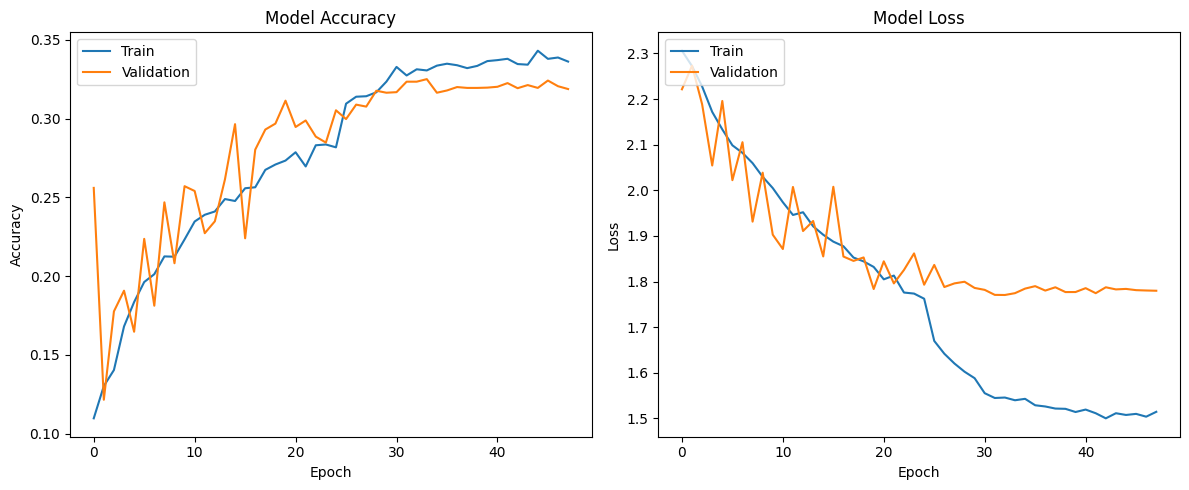

Evaluating the model...
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3282 - loss: 1.7640
Validation Loss: 1.7705
Validation Accuracy: 0.3234
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

       block       0.18      0.41      0.25       150
        pass       0.12      0.28      0.17       161
         run       0.42      0.41      0.41       888
     dribble       0.31      0.33      0.31       523
       shoot       0.09      0.23      0.13        64
ball in hand       0.20      0.13      0.16       354
     defense       0.45      0.41      0.43       580
        pick       0.06      0.39      0.11       107
   no_action       0.41      0.57      0.48       973
        walk       0.56      0.15      0.24      1763

    accuracy                           0.32      5563
   macro avg       0.28      0.33      0.27      5563
weighted avg       0.41      0.32      0.32      5563



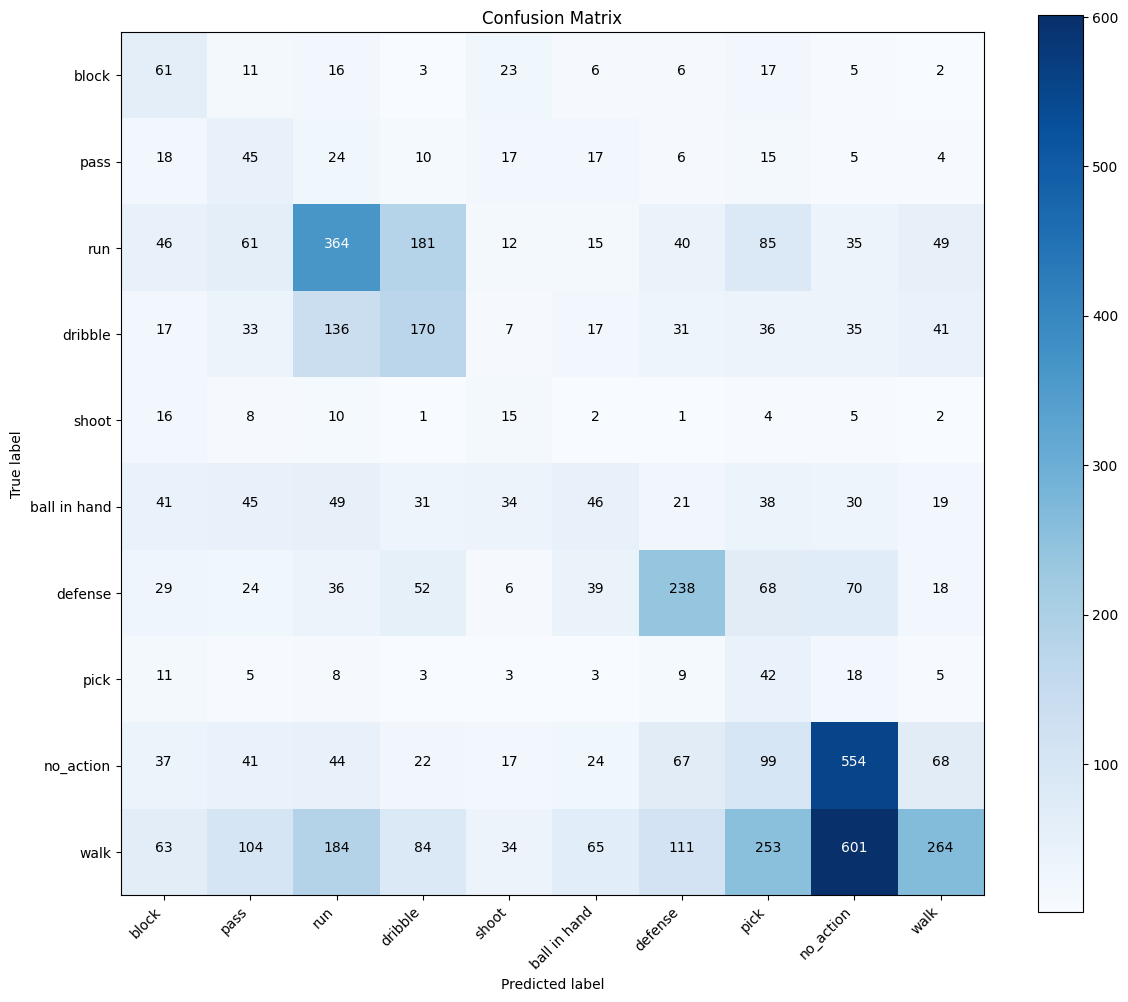

Model saved to /kaggle/working/lstm_action_recognition_model.h5
Class mapping saved to /kaggle/working/class_mapping.json


In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight


# Define and compile the LSTM model
print("Defining LSTM model...")
model = Sequential([
    LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.4),
    LSTM(128, return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Use a lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

# Add early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

# Train with class weights if needed
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

print("Training complete!")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png')
plt.show()

# Evaluate the model
print("Evaluating the model...")
loss, accuracy = model.evaluate(X_val, y_val_cat, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Make predictions on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_val

# Print classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
report = classification_report(y_true_classes, y_pred_classes, target_names=[labels_dict.get(str(i), f"Class {i}") for i in range(num_classes)])
print(report)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add class labels
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [labels_dict.get(str(i), f"Class {i}") for i in range(num_classes)], rotation=45, ha='right')
plt.yticks(tick_marks, [labels_dict.get(str(i), f"Class {i}") for i in range(num_classes)])

# Add counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# Save the model
model.save("/kaggle/working/lstm_action_recognition_model.h5")
print("Model saved to /kaggle/working/lstm_action_recognition_model.h5")

# Save the class mapping
class_mapping = {i: labels_dict.get(str(i), f"Class {i}") for i in range(num_classes)}
with open('/kaggle/working/class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)
print("Class mapping saved to /kaggle/working/class_mapping.json")


Train class distribution:
Class 0: 697 videos (2.69%)
Class 1: 749 videos (2.89%)
Class 2: 4147 videos (15.98%)
Class 3: 2443 videos (9.41%)
Class 4: 298 videos (1.15%)
Class 5: 1653 videos (6.37%)
Class 6: 2706 videos (10.42%)
Class 7: 499 videos (1.92%)
Class 8: 4543 videos (17.50%)
Class 9: 8224 videos (31.68%)

Validation class distribution:
Class 0: 150 videos (2.70%)
Class 1: 161 videos (2.89%)
Class 2: 888 videos (15.96%)
Class 3: 523 videos (9.40%)
Class 4: 64 videos (1.15%)
Class 5: 354 videos (6.36%)
Class 6: 580 videos (10.43%)
Class 7: 107 videos (1.92%)
Class 8: 973 videos (17.49%)
Class 9: 1763 videos (31.69%)


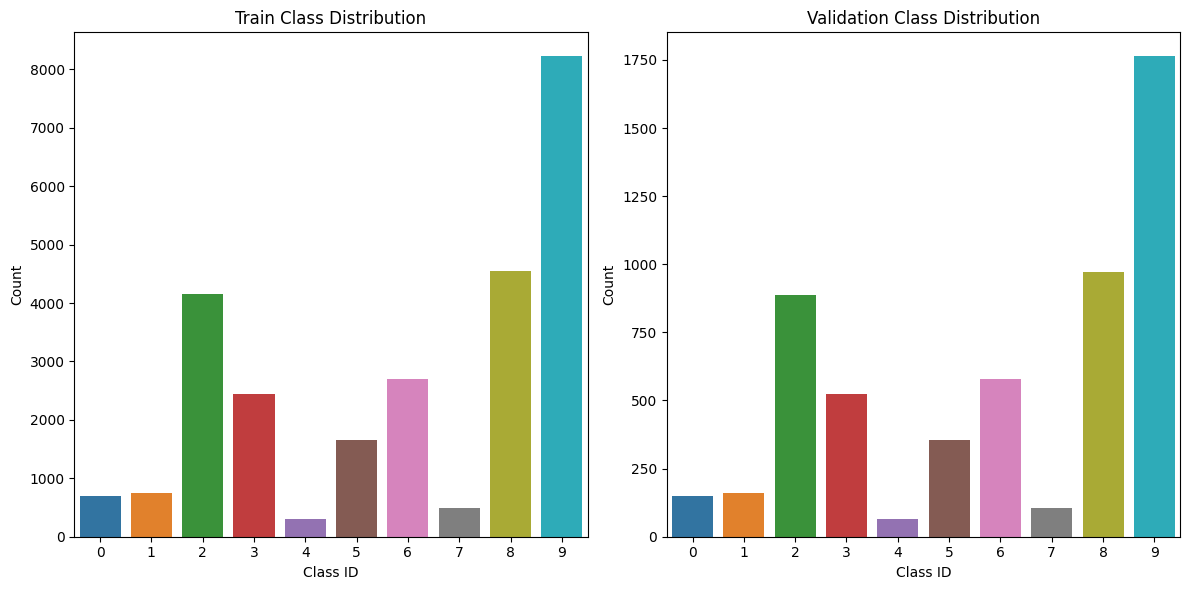


Missing values in train keypoints:
Total missing values: 1236240 (5.51%)

Missing values in validation keypoints:
Total missing values: 264639 (5.51%)

Train sequence length stats: min=16, max=16, mean=16.00
Validation sequence length stats: min=16, max=16, mean=16.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


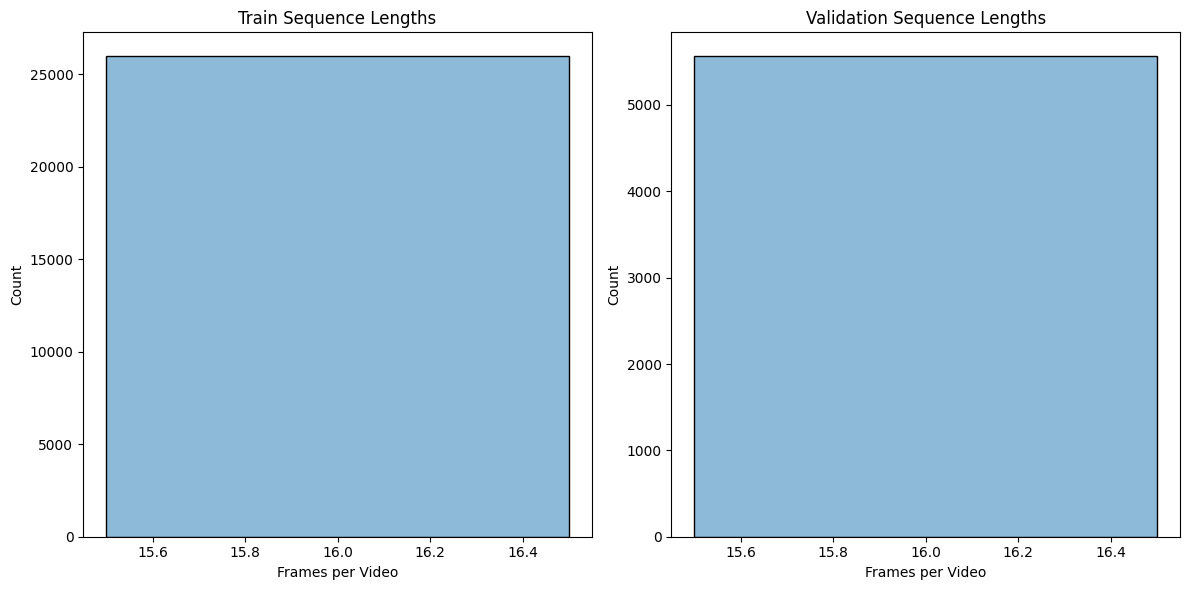

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load the data again
train_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/train_keypoints.csv")
val_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/val_keypoints.csv")

# Analyze class distribution
train_labels = train_keypoints.drop_duplicates('video_id')['label_id'].values
val_labels = val_keypoints.drop_duplicates('video_id')['label_id'].values

print("Train class distribution:")
train_counter = Counter(train_labels)
for class_id, count in sorted(train_counter.items()):
    print(f"Class {int(class_id)}: {count} videos ({count/len(train_labels)*100:.2f}%)")

print("\nValidation class distribution:")
val_counter = Counter(val_labels)
for class_id, count in sorted(val_counter.items()):
    print(f"Class {int(class_id)}: {count} videos ({count/len(val_labels)*100:.2f}%)")

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=train_labels)
plt.title("Train Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=val_labels)
plt.title("Validation Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('/kaggle/working/class_distribution.png')
plt.show()

# Check for missing values in keypoints
print("\nMissing values in train keypoints:")
missing_train = train_keypoints.isnull().sum().sum()
print(f"Total missing values: {missing_train} ({missing_train/(train_keypoints.shape[0]*train_keypoints.shape[1])*100:.2f}%)")

print("\nMissing values in validation keypoints:")
missing_val = val_keypoints.isnull().sum().sum()
print(f"Total missing values: {missing_val} ({missing_val/(val_keypoints.shape[0]*val_keypoints.shape[1])*100:.2f}%)")

# Check sequence lengths
train_seq_lengths = train_keypoints.groupby('video_id').size()
val_seq_lengths = val_keypoints.groupby('video_id').size()

print(f"\nTrain sequence length stats: min={train_seq_lengths.min()}, max={train_seq_lengths.max()}, mean={train_seq_lengths.mean():.2f}")
print(f"Validation sequence length stats: min={val_seq_lengths.min()}, max={val_seq_lengths.max()}, mean={val_seq_lengths.mean():.2f}")

# Plot sequence length distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_seq_lengths, kde=True)
plt.title("Train Sequence Lengths")
plt.xlabel("Frames per Video")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(val_seq_lengths, kde=True)
plt.title("Validation Sequence Lengths")
plt.xlabel("Frames per Video")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('/kaggle/working/sequence_lengths.png')
plt.show()


In [21]:
# Improved feature extraction and preprocessing
def preprocess_keypoints(df, max_seq_length=None):
    # Group by video_id
    video_groups = df.groupby('video_id')
    
    sequences = []
    labels = []
    video_ids = []
    
    for video_id, group in tqdm(video_groups, desc="Preprocessing videos"):
        # Sort by frame index
        group = group.sort_values('frame_idx')
        
        # Get label
        label = group['label_id'].iloc[0]
        
        # Extract keypoint columns
        keypoint_cols = [col for col in group.columns if any(x in col for x in ['_x', '_y', '_conf'])]
        keypoints = group[keypoint_cols].values
        
        # Handle missing values
        # Strategy: Interpolate missing values within sequences
        keypoints_df = pd.DataFrame(keypoints)
        keypoints_df = keypoints_df.interpolate(method='linear', limit_direction='both')
        keypoints = keypoints_df.values
        
        # Normalize coordinates to [0, 1] range if needed
        # This assumes keypoints are in pixel coordinates
        # Find columns that contain '_x' or '_y' (not confidence)
        x_cols = [i for i, col in enumerate(keypoint_cols) if '_x' in col]
        y_cols = [i for i, col in enumerate(keypoint_cols) if '_y' in col]
        
        # Get image dimensions (assuming they're consistent)
        if 'frame_width' in group.columns and 'frame_height' in group.columns:
            width = group['frame_width'].iloc[0]
            height = group['frame_height'].iloc[0]
        else:
            # Estimate from data - find max values
            width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
            height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
            
            # Use reasonable defaults if values are too small
            width = max(width, 640)
            height = max(height, 480)
        
        # Normalize coordinates
        keypoints[:, x_cols] = keypoints[:, x_cols] / width
        keypoints[:, y_cols] = keypoints[:, y_cols] / height
        
        # Replace any remaining NaNs with 0
        keypoints = np.nan_to_num(keypoints)
        
        # Handle sequence length
        if max_seq_length is not None:
            if len(keypoints) > max_seq_length:
                # Truncate or subsample
                indices = np.linspace(0, len(keypoints)-1, max_seq_length, dtype=int)
                keypoints = keypoints[indices]
            elif len(keypoints) < max_seq_length:
                # Pad with zeros
                padding = np.zeros((max_seq_length - len(keypoints), keypoints.shape[1]))
                keypoints = np.vstack([keypoints, padding])
        
        sequences.append(keypoints)
        labels.append(label)
        video_ids.append(video_id)
    
    return np.array(sequences), np.array(labels), video_ids


In [22]:
from tensorflow.keras.layers import Input, Bidirectional, Dense, Dropout, LSTM, Attention, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Model

def create_bilstm_attention_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Bidirectional LSTM layers
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm1 = Dropout(0.5)(lstm1)
    
    lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)
    lstm2 = Dropout(0.5)(lstm2)
    
    # Self-attention mechanism
    attention = Attention()([lstm2, lstm2])
    
    # Global pooling
    gap = GlobalAveragePooling1D()(attention)
    
    # Fully connected layers
    fc1 = Dense(128, activation='relu')(gap)
    fc1 = Dropout(0.5)(fc1)
    
    fc2 = Dense(64, activation='relu')(fc1)
    fc2 = Dropout(0.5)(fc2)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(fc2)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model


TensorFlow version: 2.17.1
Loading data...
Train data shape: (415344, 54)
Validation data shape: (89008, 54)

Train columns: ['video_id', 'label_id', 'frame_idx', 'NOSE_x', 'NOSE_y', 'NOSE_conf', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_EYE_conf', 'RIGHT_EYE_x', 'RIGHT_EYE_y', 'RIGHT_EYE_conf', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_EAR_conf', 'RIGHT_EAR_x', 'RIGHT_EAR_y', 'RIGHT_EAR_conf', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_conf', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_conf', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y', 'LEFT_ELBOW_conf', 'RIGHT_ELBOW_x', 'RIGHT_ELBOW_y', 'RIGHT_ELBOW_conf', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_conf', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RIGHT_WRIST_conf', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_HIP_conf', 'RIGHT_HIP_x', 'RIGHT_HIP_y', 'RIGHT_HIP_conf', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_KNEE_conf', 'RIGHT_KNEE_x', 'RIGHT_KNEE_y', 'RIGHT_KNEE_conf', 'LEFT_ANKLE_x', 'LEFT_ANKLE_y', 'LEFT_ANKLE_conf', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y', 'RIGHT_A

Preprocessing videos:  30%|██▉       | 7778/25959 [00:16<00:51, 355.37it/s]<ipython-input-24-1e7e83589cc6>:88: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-24-1e7e83589cc6>:89: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  30%|███       | 7885/25959 [00:16<00:53, 336.59it/s]<ipython-input-24-1e7e83589cc6>:88: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-24-1e7e83589cc6>:89: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  35%|███▌      | 9115/25959 [00:20<00:49, 340.00it/s]<ipython-input-24-1e7e83589cc6>:88: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[

Preprocessing validation data...


Preprocessing videos:  38%|███▊      | 2103/5563 [00:04<00:10, 340.87it/s]<ipython-input-24-1e7e83589cc6>:88: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-24-1e7e83589cc6>:89: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos: 100%|██████████| 5563/5563 [00:13<00:00, 422.73it/s]


Train data shape: (25959, 16, 51)
Validation data shape: (5563, 16, 51)
Number of classes: 10
Unique classes: [0 1 2 3 4 5 6 7 8 9]
Class weights: {0: 3.7243902439024392, 1: 3.4658210947930574, 2: 0.625970581142995, 3: 1.0625869832173558, 4: 8.711073825503355, 5: 1.5704174228675136, 6: 0.9593126385809313, 7: 5.202204408817635, 8: 0.5714065595421528, 9: 0.31564931906614785}


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 16, 51)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 16, 256)        │        184,320 │ input_layer_7[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 16, 256)        │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 16, 128)        │        164,352 │ dropout_22[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 16, 128)        │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 16, 128)        │              0 │ dropout_23[0][0],      │
│                           │                        │                │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ attention_1[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 128)            │         16,512 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 128)            │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 64)             │          8,256 │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 64)             │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 10)             │            650 │ dropout_25[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 374,090 (1.43 MB)

 Trainable params: 374,090 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model...
Epoch 1/100
809/812 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0854 - loss: 2.2850
Epoch 1: val_accuracy improved from -inf to 0.14920, saving model to /kaggle/working/best_model.keras
812/812 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.0854 - loss: 2.2851 - val_accuracy: 0.1492 - val_loss: 2.2837 - learning_rate: 1.0000e-04
Epoch 2/100
807/812 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0793 - loss: 2.2962
Epoch 2: val_accuracy did not improve from 0.14920
812/812 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.0792 - loss: 2.2963 - val_accuracy: 0.1100 - val_loss: 2.2785 - learning_rate: 1.0000e-04
Epoch 3/100
810/812 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0863 - loss: 2.2677
Epoch 3: val_accuracy did not improve from 0.14920
812/812 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.0863 - loss: 2.2677 - val_accuracy: 0.0489 - val_loss: 2.3568 - learning_rate: 1.0000e-04
Epoch 4/100
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.09

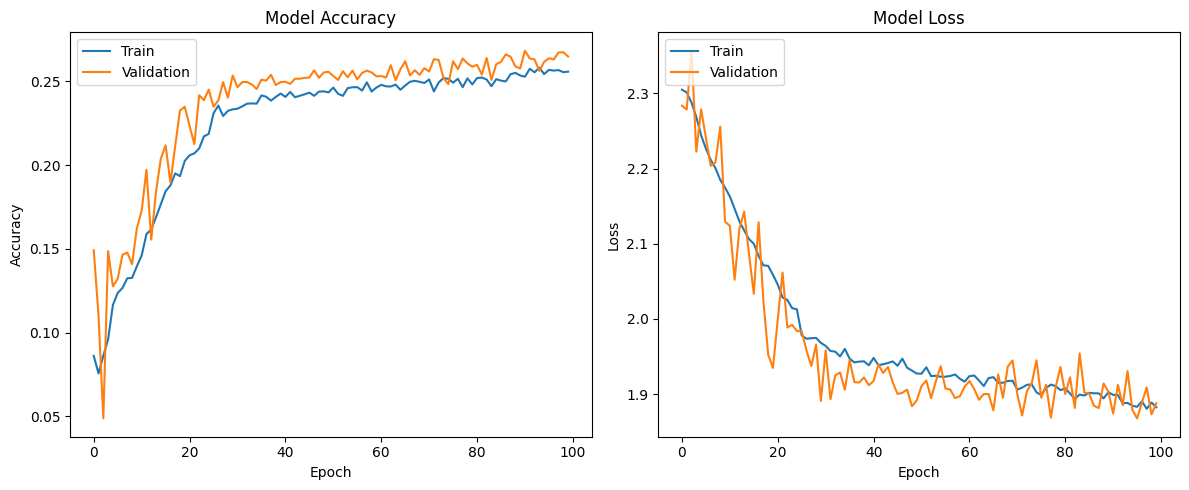

Evaluating model...
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2714 - loss: 1.8215
Validation Loss: 1.8677
Validation Accuracy: 0.2637
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.33      0.16       150
           1       0.10      0.28      0.15       161
           2       0.37      0.30      0.33       888
           3       0.26      0.32      0.28       523
           4       0.11      0.41      0.17        64
           5       0.28      0.04      0.07       354
           6       0.36      0.37      0.37       580
           7       0.05      0.33      0.08       107
           8       0.37      0.52      0.43       973
           9       0.50      0.08      0.14      1763

    accuracy                           0.26      5563
   macro avg       0.25      0.30      0.22      5563
weighted avg       0.37      0.26      0.25      5563



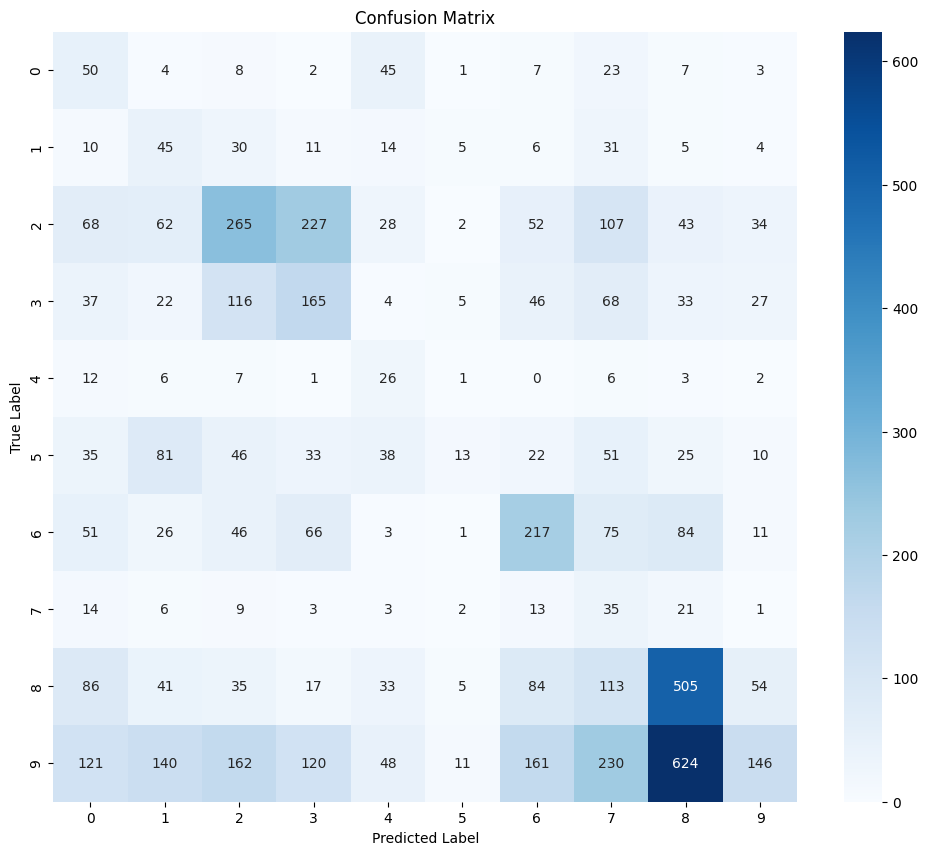

Model saved to /kaggle/working/final_model.keras


TypeError: Object of type int64 is not JSON serializable

In [24]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Bidirectional, Dense, Dropout, LSTM, Attention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Function to create BiLSTM model with attention
def create_bilstm_attention_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Bidirectional LSTM layers
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm1 = Dropout(0.5)(lstm1)
    
    lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)
    lstm2 = Dropout(0.5)(lstm2)
    
    # Self-attention mechanism
    attention = Attention()([lstm2, lstm2])
    
    # Global pooling
    gap = GlobalAveragePooling1D()(attention)
    
    # Fully connected layers
    fc1 = Dense(128, activation='relu')(gap)
    fc1 = Dropout(0.5)(fc1)
    
    fc2 = Dense(64, activation='relu')(fc1)
    fc2 = Dropout(0.5)(fc2)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(fc2)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Improved feature extraction and preprocessing
def preprocess_keypoints(df, max_seq_length=None):
    # Group by video_id
    video_groups = df.groupby('video_id')
    
    sequences = []
    labels = []
    video_ids = []
    
    for video_id, group in tqdm(video_groups, desc="Preprocessing videos"):
        # Sort by frame index
        group = group.sort_values('frame_idx')
        
        # Get label
        if 'label_id' in group.columns:
            label = group['label_id'].iloc[0]
        elif 'label' in group.columns:
            label = group['label'].iloc[0]
        else:
            print(f"Warning: No label column found for video {video_id}")
            continue
        
        # Extract keypoint columns
        keypoint_cols = [col for col in group.columns if any(x in col for x in ['_x', '_y', '_conf'])]
        keypoints = group[keypoint_cols].values
        
        # Handle missing values
        # Strategy: Interpolate missing values within sequences
        keypoints_df = pd.DataFrame(keypoints)
        keypoints_df = keypoints_df.interpolate(method='linear', limit_direction='both')
        keypoints = keypoints_df.values
        
        # Normalize coordinates to [0, 1] range
        # Find columns that contain '_x' or '_y' (not confidence)
        x_cols = [i for i, col in enumerate(keypoint_cols) if '_x' in col]
        y_cols = [i for i, col in enumerate(keypoint_cols) if '_y' in col]
        
        # Estimate from data - find max values
        width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
        height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
        
        # Use reasonable defaults if values are too small
        width = max(width, 640)
        height = max(height, 480)
        
        # Normalize coordinates
        keypoints[:, x_cols] = keypoints[:, x_cols] / width
        keypoints[:, y_cols] = keypoints[:, y_cols] / height
        
        # Replace any remaining NaNs with 0
        keypoints = np.nan_to_num(keypoints)
        
        # Handle sequence length
        if max_seq_length is not None:
            if len(keypoints) > max_seq_length:
                # Truncate or subsample
                indices = np.linspace(0, len(keypoints)-1, max_seq_length, dtype=int)
                keypoints = keypoints[indices]
            elif len(keypoints) < max_seq_length:
                # Pad with zeros
                padding = np.zeros((max_seq_length - len(keypoints), keypoints.shape[1]))
                keypoints = np.vstack([keypoints, padding])
        
        sequences.append(keypoints)
        labels.append(label)
        video_ids.append(video_id)
    
    return np.array(sequences), np.array(labels), video_ids

# Load data
print("Loading data...")
train_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/train_keypoints.csv")
val_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/val_keypoints.csv")

print(f"Train data shape: {train_keypoints.shape}")
print(f"Validation data shape: {val_keypoints.shape}")

# Check column names
print("\nTrain columns:", train_keypoints.columns.tolist())

# Check for label column
if 'label_id' not in train_keypoints.columns and 'label' not in train_keypoints.columns:
    print("Warning: No label column found in the data. Checking if we need to add it...")
    
    # Try to load annotations
    try:
        with open("/kaggle/input/spacejam-action-recognition/annotation_dict.json", "r") as f:
            annotation_content = f.read()
            annotation_content = annotation_content.replace("'", '"')
            annotation_dict = json.loads(annotation_content)
            print(f"Loaded {len(annotation_dict)} annotations")
            
            # Add labels to the dataframes
            train_keypoints['label_id'] = train_keypoints['video_id'].map(annotation_dict)
            val_keypoints['label_id'] = val_keypoints['video_id'].map(annotation_dict)
            
            print("Added labels to the dataframes")
    except Exception as e:
        print(f"Error loading annotations: {str(e)}")

# Determine max sequence length (or use a fixed value)
train_seq_lengths = train_keypoints.groupby('video_id').size()
val_seq_lengths = val_keypoints.groupby('video_id').size()
max_seq_length = int(np.percentile(np.concatenate([train_seq_lengths, val_seq_lengths]), 95))
print(f"Using max sequence length: {max_seq_length}")

# Preprocess data
print("Preprocessing training data...")
X_train, y_train, train_video_ids = preprocess_keypoints(train_keypoints, max_seq_length)
print("Preprocessing validation data...")
X_val, y_val, val_video_ids = preprocess_keypoints(val_keypoints, max_seq_length)

print(f"Train data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Get number of classes
num_classes = len(np.unique(np.concatenate([y_train, y_val])))
print(f"Number of classes: {num_classes}")
print(f"Unique classes: {np.unique(np.concatenate([y_train, y_val]))}")

# Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weight_dict)

# Create model
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_bilstm_attention_model(input_shape, num_classes)

# Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

# Callbacks - Note the .keras extension instead of .h5
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/kaggle/working/best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train model
print("Training model...")
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png')
plt.show()

# Evaluate model
print("Evaluating model...")
loss, accuracy = model.evaluate(X_val, y_val_cat, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
report = classification_report(y_val, y_pred_classes)
print(report)

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# Save model
model.save('/kaggle/working/final_model.keras')
print("Model saved to /kaggle/working/final_model.keras")

# Save class mapping for future reference
class_mapping = {int(i): i for i in np.unique(np.concatenate([y_train, y_val]))}
with open('/kaggle/working/class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)
print("Class mapping saved to /kaggle/working/class_mapping.json")


In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Bidirectional, Layer
from tensorflow.keras.models import Model
import keras.backend as K

# Custom attention layer implementation
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        # Use tf.math.tanh instead of K.tanh
        e = tf.math.tanh(tf.matmul(x, self.W) + self.b)
        
        # Remove dimension of size 1
        e = tf.squeeze(e, axis=-1)
        
        # Compute the weights
        alpha = tf.nn.softmax(e)
        
        # Reshape to tensorFlow format
        alpha = tf.expand_dims(alpha, axis=-1)
        
        # Compute the context vector
        context = x * alpha
        context = tf.reduce_sum(context, axis=1)
        
        return context
    
    def compute_output_shape(self, input_shape):
        # Output shape is (batch_size, features)
        return (input_shape[0], input_shape[2])
    
    # For newer Keras versions
    def get_config(self):
        return super(AttentionLayer, self).get_config()

# Define the attention-enhanced LSTM model
def create_attention_bilstm_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Bidirectional LSTM layers with return_sequences=True to keep the temporal dimension
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm1 = Dropout(0.5)(lstm1)
    
    lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)
    lstm2 = Dropout(0.5)(lstm2)
    
    # Apply attention mechanism
    attention_output = AttentionLayer()(lstm2)
    
    # Dense layers for classification
    dense1 = Dense(128, activation='relu')(attention_output)
    dense1 = Dropout(0.5)(dense1)
    
    dense2 = Dense(64, activation='relu')(dense1)
    dense2 = Dropout(0.3)(dense2)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(dense2)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Usage example
input_shape = (30, 51)  # (sequence_length, num_features)
num_classes = 11  # Number of action classes
model = create_attention_bilstm_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 30, 51)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 30, 256)             │         184,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 30, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 128)                 │             158 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 374,313 (1.43 MB)

 Trainable params: 374,313 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Evaluate the model
print("Evaluating model...")
loss, accuracy = model.evaluate(X_val, y_val_cat, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_cat, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
report = classification_report(y_true_classes, y_pred_classes)
print(report)

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/kaggle/working/attention_confusion_matrix.png')
plt.show()

# Save model
model.save('/kaggle/working/final_attention_model.keras')
print("Model saved to /kaggle/working/final_attention_model.keras")

# Analyze attention weights to understand which parts of the sequence the model focuses on
# This requires a custom function to extract attention weights from the model
def visualize_attention(model, X_sample, sample_idx=0):
    # Create a new model that outputs attention weights
    attention_layer = [layer for layer in model.layers if 'attention' in layer.name][0]
    attention_model = tf.keras.Model(inputs=model.input, outputs=attention_layer.output)
    
    # Get attention weights for a sample
    sample = X_sample[sample_idx:sample_idx+1]
    attention_weights = attention_model.predict(sample)
    
    # Plot attention weights
    plt.figure(figsize=(10, 6))
    plt.imshow(attention_weights.reshape(-1, 1), aspect='auto', cmap='viridis')
    plt.colorbar(label='Attention Weight')
    plt.title('Attention Weights Across Sequence')
    plt.xlabel('Weight Magnitude')
    plt.ylabel('Sequence Step')
    plt.savefig('/kaggle/working/attention_visualization.png')
    plt.show()
    
    return attention_weights

# Visualize attention for a few samples
for i in range(5):
    print(f"Sample {i}, True Label: {y_true_classes[i]}")
    weights = visualize_attention(model, X_val, i)


Evaluating model...


ValueError: Input 0 of layer "functional_8" is incompatible with the layer: expected shape=(None, 30, 51), found shape=(None, 16, 51)

Loading data...
Train data shape: (415344, 54)
Validation data shape: (89008, 54)

Train columns: ['video_id', 'label_id', 'frame_idx', 'NOSE_x', 'NOSE_y', 'NOSE_conf', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_EYE_conf', 'RIGHT_EYE_x', 'RIGHT_EYE_y', 'RIGHT_EYE_conf', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_EAR_conf', 'RIGHT_EAR_x', 'RIGHT_EAR_y', 'RIGHT_EAR_conf', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_conf', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_conf', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y', 'LEFT_ELBOW_conf', 'RIGHT_ELBOW_x', 'RIGHT_ELBOW_y', 'RIGHT_ELBOW_conf', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_conf', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RIGHT_WRIST_conf', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_HIP_conf', 'RIGHT_HIP_x', 'RIGHT_HIP_y', 'RIGHT_HIP_conf', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_KNEE_conf', 'RIGHT_KNEE_x', 'RIGHT_KNEE_y', 'RIGHT_KNEE_conf', 'LEFT_ANKLE_x', 'LEFT_ANKLE_y', 'LEFT_ANKLE_conf', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y', 'RIGHT_ANKLE_conf']

Train sequence

Preprocessing videos:  30%|██▉       | 7773/25959 [00:16<00:48, 378.63it/s]<ipython-input-28-dc63b6bff411>:145: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-28-dc63b6bff411>:146: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  30%|███       | 7887/25959 [00:16<00:50, 359.19it/s]<ipython-input-28-dc63b6bff411>:145: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-28-dc63b6bff411>:146: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  35%|███▌      | 9086/25959 [00:19<00:47, 352.52it/s]<ipython-input-28-dc63b6bff411>:145: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypo

Train data shape after preprocessing: (25959, 30, 51)
Validation data shape after preprocessing: (5563, 30, 51)
Number of classes: 10
Unique classes: [0 1 2 3 4 5 6 7 8 9]
Class weights: {0: 3.7243902439024392, 1: 3.4658210947930574, 2: 0.625970581142995, 3: 1.0625869832173558, 4: 8.711073825503355, 5: 1.5704174228675136, 6: 0.9593126385809313, 7: 5.202204408817635, 8: 0.5714065595421528, 9: 0.31564931906614785}
Creating model with input shape: (30, 51)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 30, 51)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 30, 256)             │         184,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 30, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_2 (AttentionLayer)   │ (None, 128)                 │             158 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 374,248 (1.43 MB)

 Trainable params: 374,248 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model...
Epoch 1/100
809/812 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1123 - loss: 2.3125
Epoch 1: val_accuracy improved from -inf to 0.16124, saving model to /kaggle/working/best_attention_model.keras
812/812 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.1123 - loss: 2.3124 - val_accuracy: 0.1612 - val_loss: 2.2811 - learning_rate: 1.0000e-04
Epoch 2/100
809/812 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1277 - loss: 2.2862
Epoch 2: val_accuracy did not improve from 0.16124
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.1276 - loss: 2.2863 - val_accuracy: 0.0884 - val_loss: 2.2882 - learning_rate: 1.0000e-04
Epoch 3/100
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1156 - loss: 2.2812
Epoch 3: val_accuracy improved from 0.16124 to 0.16951, saving model to /kaggle/working/best_attention_model.keras
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.1156 - loss: 2.2812 - val_accuracy: 0.1695 - val_loss: 2.2356 - learning_rate: 1.000

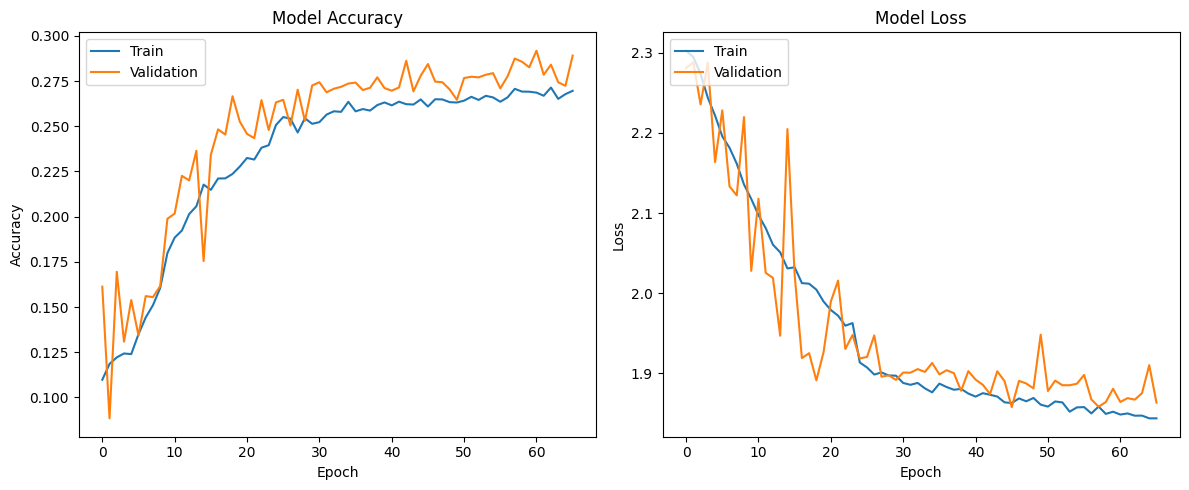

Evaluating model...
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2947 - loss: 1.8085
Validation Loss: 1.8577
Validation Accuracy: 0.2844
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.32      0.17       150
           1       0.15      0.27      0.19       161
           2       0.40      0.35      0.37       888
           3       0.25      0.31      0.28       523
           4       0.08      0.39      0.13        64
           5       0.27      0.11      0.16       354
           6       0.40      0.36      0.38       580
           7       0.05      0.39      0.10       107
           8       0.38      0.53      0.45       973
           9       0.53      0.11      0.18      1763

    accuracy                           0.28      5563
   macro avg       0.26      0.31      0.24      5563
weighted avg       0.39      0.28      0.28      5563



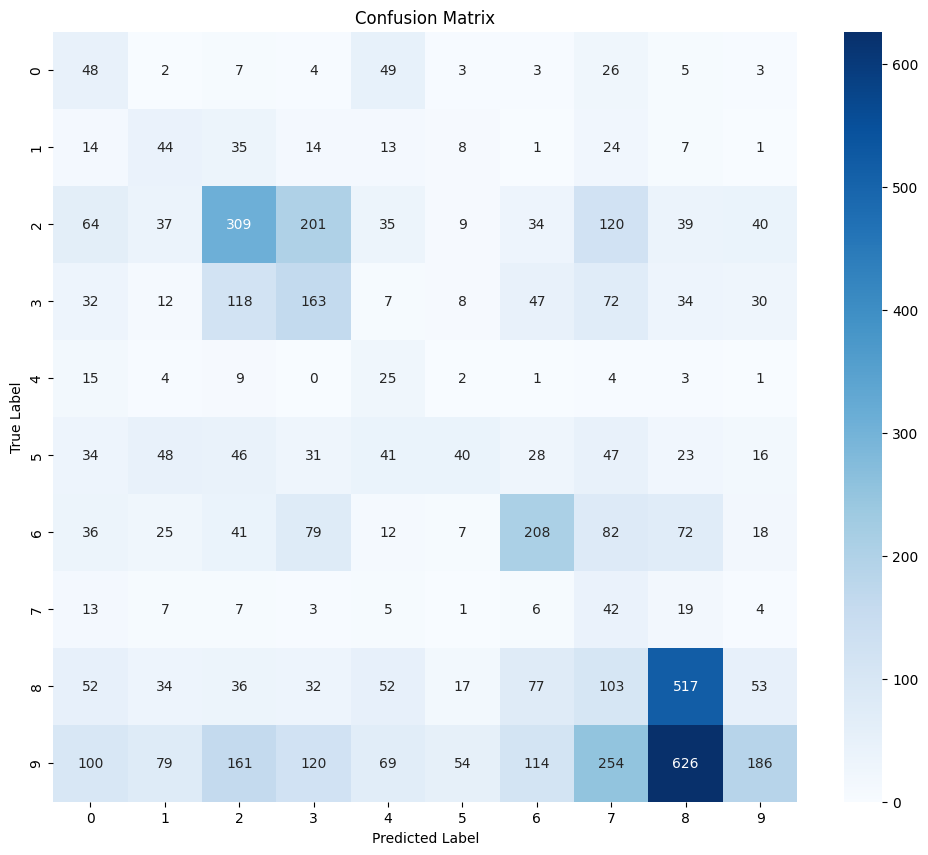


Visualizing attention weights for sample sequences:
Sample 0, True Label: 2, Predicted Label: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (30,) and arg 1 with shape (128,).

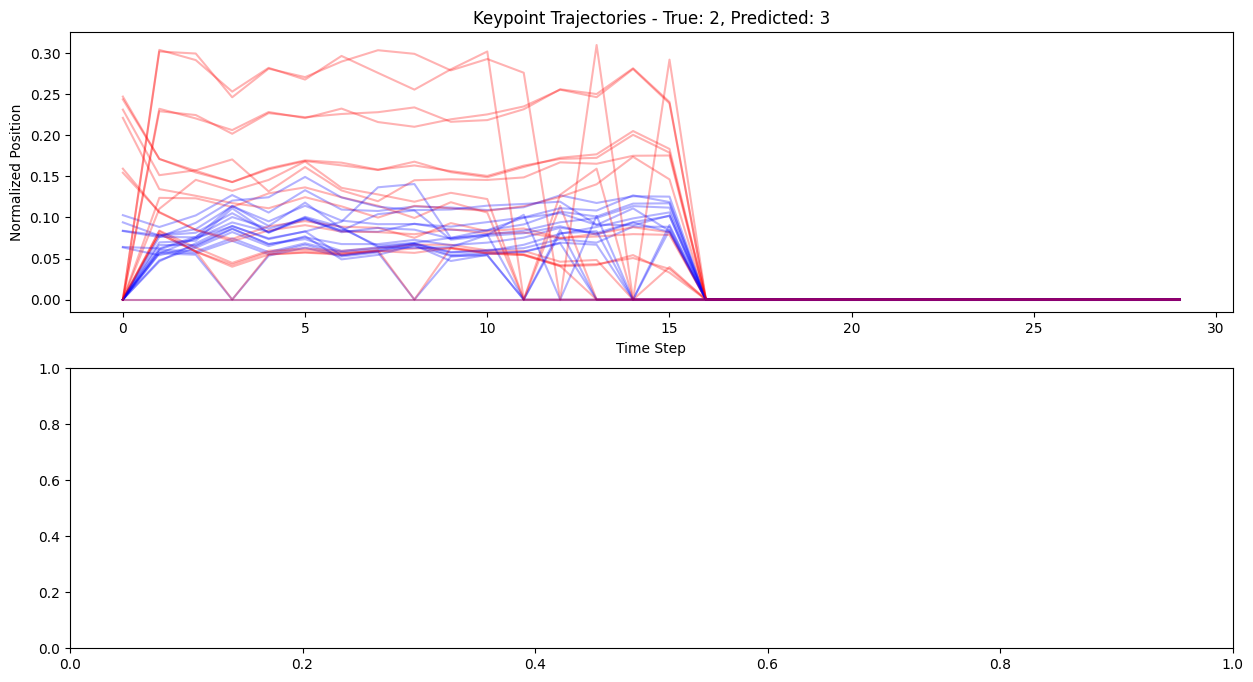

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Custom attention layer implementation with TF 2.x compatibility
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        # Use tf.math functions instead of K functions
        e = tf.math.tanh(tf.matmul(x, self.W) + self.b)
        e = tf.squeeze(e, axis=-1)
        alpha = tf.nn.softmax(e)
        alpha = tf.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = tf.reduce_sum(context, axis=1)
        return context
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])
    
    def get_config(self):
        return super(AttentionLayer, self).get_config()

# Define the attention-enhanced LSTM model
def create_attention_bilstm_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Bidirectional LSTM layers
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm1 = Dropout(0.5)(lstm1)
    
    lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)
    lstm2 = Dropout(0.5)(lstm2)
    
    # Apply attention mechanism
    attention_output = AttentionLayer()(lstm2)
    
    # Dense layers for classification
    dense1 = Dense(128, activation='relu')(attention_output)
    dense1 = Dropout(0.5)(dense1)
    
    dense2 = Dense(64, activation='relu')(dense1)
    dense2 = Dropout(0.3)(dense2)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(dense2)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Load data
print("Loading data...")
train_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/train_keypoints.csv")
val_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/val_keypoints.csv")

print(f"Train data shape: {train_keypoints.shape}")
print(f"Validation data shape: {val_keypoints.shape}")

# Check column names
print("\nTrain columns:", train_keypoints.columns.tolist())

# Check for label column
if 'label_id' not in train_keypoints.columns and 'label' not in train_keypoints.columns:
    print("Warning: No label column found in the data. Checking if we need to add it...")
    
    # Try to load annotations
    try:
        import json
        with open("/kaggle/input/spacejam-action-recognition/annotation_dict.json", "r") as f:
            annotation_content = f.read()
            annotation_content = annotation_content.replace("'", '"')
            annotation_dict = json.loads(annotation_content)
            print(f"Loaded {len(annotation_dict)} annotations")
            
            # Add labels to the dataframes
            train_keypoints['label_id'] = train_keypoints['video_id'].map(annotation_dict)
            val_keypoints['label_id'] = val_keypoints['video_id'].map(annotation_dict)
            
            print("Added labels to the dataframes")
    except Exception as e:
        print(f"Error loading annotations: {str(e)}")

# Function to preprocess keypoints with consistent sequence length
def preprocess_keypoints(df, max_seq_length):
    # Group by video_id
    video_groups = df.groupby('video_id')
    
    sequences = []
    labels = []
    video_ids = []
    
    for video_id, group in tqdm(video_groups, desc="Preprocessing videos"):
        # Sort by frame index
        group = group.sort_values('frame_idx')
        
        # Get label
        if 'label_id' in group.columns:
            label = group['label_id'].iloc[0]
        elif 'label' in group.columns:
            label = group['label'].iloc[0]
        else:
            print(f"Warning: No label column found for video {video_id}")
            continue
        
        # Extract keypoint columns
        keypoint_cols = [col for col in group.columns if any(x in col for x in ['_x', '_y', '_conf'])]
        keypoints = group[keypoint_cols].values
        
        # Handle missing values
        keypoints_df = pd.DataFrame(keypoints)
        keypoints_df = keypoints_df.interpolate(method='linear', limit_direction='both')
        keypoints = keypoints_df.values
        
        # Normalize coordinates to [0, 1] range
        x_cols = [i for i, col in enumerate(keypoint_cols) if '_x' in col]
        y_cols = [i for i, col in enumerate(keypoint_cols) if '_y' in col]
        
        # Estimate from data - find max values
        width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
        height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
        
        # Use reasonable defaults if values are too small
        width = max(width, 640)
        height = max(height, 480)
        
        # Normalize coordinates
        keypoints[:, x_cols] = keypoints[:, x_cols] / width
        keypoints[:, y_cols] = keypoints[:, y_cols] / height
        
        # Replace any remaining NaNs with 0
        keypoints = np.nan_to_num(keypoints)
        
        # Ensure consistent sequence length
        if len(keypoints) > max_seq_length:
            # Use evenly spaced indices to sample the sequence
            indices = np.linspace(0, len(keypoints)-1, max_seq_length, dtype=int)
            keypoints = keypoints[indices]
        elif len(keypoints) < max_seq_length:
            # Pad with zeros
            padding = np.zeros((max_seq_length - len(keypoints), keypoints.shape[1]))
            keypoints = np.vstack([keypoints, padding])
        
        sequences.append(keypoints)
        labels.append(label)
        video_ids.append(video_id)
    
    return np.array(sequences), np.array(labels), video_ids

# Determine max sequence length
# First, analyze the sequence lengths
train_seq_lengths = train_keypoints.groupby('video_id').size()
val_seq_lengths = val_keypoints.groupby('video_id').size()

print(f"\nTrain sequence length stats: min={train_seq_lengths.min()}, max={train_seq_lengths.max()}, mean={train_seq_lengths.mean():.2f}")
print(f"Validation sequence length stats: min={val_seq_lengths.min()}, max={val_seq_lengths.max()}, mean={val_seq_lengths.mean():.2f}")

# Choose a reasonable max sequence length (e.g., 95th percentile or a fixed value)
# Using a fixed value for clarity in this example
MAX_SEQ_LENGTH = 30  # Adjust this based on your data analysis

# Preprocess data with consistent sequence length
print(f"Preprocessing data with max sequence length: {MAX_SEQ_LENGTH}")
X_train, y_train, train_video_ids = preprocess_keypoints(train_keypoints, MAX_SEQ_LENGTH)
X_val, y_val, val_video_ids = preprocess_keypoints(val_keypoints, MAX_SEQ_LENGTH)

print(f"Train data shape after preprocessing: {X_train.shape}")
print(f"Validation data shape after preprocessing: {X_val.shape}")

# Get number of classes
num_classes = len(np.unique(np.concatenate([y_train, y_val])))
print(f"Number of classes: {num_classes}")
print(f"Unique classes: {np.unique(np.concatenate([y_train, y_val]))}")

# Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weight_dict)

# Create model with the correct input shape
input_shape = (MAX_SEQ_LENGTH, X_train.shape[2])  # Ensure this matches your preprocessed data
print(f"Creating model with input shape: {input_shape}")
model = create_attention_bilstm_model(input_shape, num_classes)

# Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/kaggle/working/best_attention_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train model
print("Training model...")
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('/kaggle/working/attention_training_history.png')
plt.show()

# Evaluate model
print("Evaluating model...")
loss, accuracy = model.evaluate(X_val, y_val_cat, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_cat, axis=1)

# Classification report
print("\nClassification Report:")
report = classification_report(y_true_classes, y_pred_classes)
print(report)

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/kaggle/working/attention_confusion_matrix.png')
plt.show()

# Visualize attention weights
def visualize_attention(model, X_sample, y_true, sample_idx=0):
    """
    Create a new model that outputs attention weights and visualize them
    """
    # Get the attention layer
    attention_layer = None
    for layer in model.layers:
        if isinstance(layer, AttentionLayer):
            attention_layer = layer
            break
    
    if attention_layer is None:
        print("Attention layer not found in model")
        return
    
    # Create a new model that outputs the attention weights
    attention_model = tf.keras.Model(
        inputs=model.input,
        outputs=[model.output, attention_layer.output]
    )
    
    # Get predictions and attention weights for a sample
    sample = X_sample[sample_idx:sample_idx+1]
    predictions, attention_output = attention_model.predict(sample)
    
    # Get the predicted class
    pred_class = np.argmax(predictions[0])
    true_class = y_true[sample_idx]
    
    # Plot the keypoints over time with attention weights
    plt.figure(figsize=(15, 8))
    
    # Plot keypoints
    plt.subplot(2, 1, 1)
    keypoints_data = sample[0]
    
    # Extract x and y coordinates (assuming they alternate in the feature dimension)
    x_coords = keypoints_data[:, ::3]  # Every 3rd feature starting from 0
    y_coords = keypoints_data[:, 1::3]  # Every 3rd feature starting from 1
    
    # Plot the trajectory of each keypoint
    for i in range(x_coords.shape[1]):
        plt.plot(range(len(keypoints_data)), x_coords[:, i], 'b-', alpha=0.3)
        plt.plot(range(len(keypoints_data)), y_coords[:, i], 'r-', alpha=0.3)
    
    plt.title(f'Keypoint Trajectories - True: {true_class}, Predicted: {pred_class}')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Position')
    
    # Plot attention weights
    plt.subplot(2, 1, 2)
    plt.bar(range(MAX_SEQ_LENGTH), attention_output[0])
    plt.title('Attention Weights Across Sequence')
    plt.xlabel('Time Step')
    plt.ylabel('Attention Weight')
    
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/attention_viz_sample_{sample_idx}.png')
    plt.show()

# Visualize attention for a few samples
print("\nVisualizing attention weights for sample sequences:")
for i in range(5):
    print(f"Sample {i}, True Label: {y_true_classes[i]}, Predicted Label: {y_pred_classes[i]}")
    visualize_attention(model, X_val, y_true_classes, i)

# Save model
model.save('/kaggle/working/final_attention_model.keras')
print("Model saved to /kaggle/working/final_attention_model.keras")

# Save class mapping for future reference
class_mapping = {int(i): i for i in np.unique(np.concatenate([y_train, y_val]))}
with open('/kaggle/working/class_mapping.json', 'w') as f:
    import json
    json.dump(class_mapping, f)
print("Class mapping saved to /kaggle/working/class_mapping.json")


In [29]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Data augmentation for keypoint data
def augment_keypoints(keypoints, label, augmentation_factor=2):
    """Apply augmentation to keypoint data to address class imbalance"""
    augmented_data = [keypoints]
    augmented_labels = [label]
    
    for _ in range(augmentation_factor):
        # 1. Add random noise to keypoints (jittering)
        noise_level = 0.02
        noisy_keypoints = keypoints + np.random.normal(0, noise_level, keypoints.shape)
        
        # 2. Apply random temporal shifting (shift frames slightly)
        shift_amount = np.random.randint(1, 3)
        shifted_keypoints = np.roll(noisy_keypoints, shift_amount, axis=0)
        
        # 3. Apply random scaling (simulate different distances)
        scale_factor = np.random.uniform(0.9, 1.1)
        # Only scale x,y coordinates (not confidence)
        x_cols = np.arange(0, keypoints.shape[1], 3)
        y_cols = np.arange(1, keypoints.shape[1], 3)
        scaled_keypoints = shifted_keypoints.copy()
        scaled_keypoints[:, x_cols] *= scale_factor
        scaled_keypoints[:, y_cols] *= scale_factor
        
        augmented_data.append(scaled_keypoints)
        augmented_labels.append(label)
    
    return augmented_data, augmented_labels

# Balanced dataset creation with augmentation
def create_balanced_dataset(X, y, max_samples_per_class=500):
    """Create a balanced dataset using augmentation for minority classes"""
    unique_classes, class_counts = np.unique(y, return_counts=True)
    print(f"Original class distribution: {dict(zip(unique_classes, class_counts))}")
    
    balanced_X = []
    balanced_y = []
    
    for cls in unique_classes:
        # Get samples for this class
        cls_indices = np.where(y == cls)[0]
        cls_samples = len(cls_indices)
        
        # Determine how many samples to keep/generate
        if cls_samples > max_samples_per_class:
            # Undersample majority classes
            selected_indices = np.random.choice(cls_indices, max_samples_per_class, replace=False)
            for idx in selected_indices:
                balanced_X.append(X[idx])
                balanced_y.append(y[idx])
        else:
            # Use all original samples
            for idx in cls_indices:
                balanced_X.append(X[idx])
                balanced_y.append(y[idx])
            
            # Augment minority classes if needed
            if cls_samples < max_samples_per_class:
                augmentation_needed = max_samples_per_class - cls_samples
                aug_factor = augmentation_needed // cls_samples + 1
                
                for idx in cls_indices:
                    aug_data, aug_labels = augment_keypoints(X[idx], y[idx], aug_factor)
                    # Add only what we need to reach target count
                    samples_to_add = min(len(aug_data) - 1, augmentation_needed)
                    balanced_X.extend(aug_data[1:samples_to_add+1])
                    balanced_y.extend(aug_labels[1:samples_to_add+1])
                    augmentation_needed -= samples_to_add
                    if augmentation_needed <= 0:
                        break
    
    balanced_X = np.array(balanced_X)
    balanced_y = np.array(balanced_y)
    
    unique_classes, class_counts = np.unique(balanced_y, return_counts=True)
    print(f"Balanced class distribution: {dict(zip(unique_classes, class_counts))}")
    
    return balanced_X, balanced_y


In [30]:
class SqueezeExcitation(tf.keras.layers.Layer):
    """Squeeze-and-Excitation block for recalibrating feature maps"""
    def __init__(self, filters, reduction_ratio=16):
        super(SqueezeExcitation, self).__init__()
        self.filters = filters
        self.reduction_ratio = reduction_ratio
        self.squeeze = tf.keras.layers.GlobalAveragePooling1D()
        self.excitation = tf.keras.Sequential([
            tf.keras.layers.Dense(filters // reduction_ratio, activation='relu'),
            tf.keras.layers.Dense(filters, activation='sigmoid')
        ])
        
    def call(self, inputs):
        # Squeeze (global information embedding)
        x = self.squeeze(inputs)
        
        # Excitation (adaptive recalibration)
        x = self.excitation(x)
        
        # Scale the input feature maps
        x = tf.reshape(x, [-1, 1, self.filters])
        return inputs * x


In [31]:
class SpatialAttention(tf.keras.layers.Layer):
    """Spatial attention mechanism to focus on important keypoints"""
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu')
        self.conv2 = tf.keras.layers.Conv1D(1, kernel_size=1, activation=None)
        
    def call(self, inputs):
        # Compute spatial attention weights
        x = self.conv1(inputs)
        attention_weights = self.conv2(x)
        attention_weights = tf.nn.softmax(attention_weights, axis=1)
        
        # Apply attention weights
        return inputs * attention_weights

class TemporalAttention(tf.keras.layers.Layer):
    """Temporal attention mechanism to focus on important frames"""
    def __init__(self):
        super(TemporalAttention, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(1, activation=None)
        
    def call(self, inputs):
        # Compute temporal attention weights
        x = self.dense1(inputs)
        attention_weights = self.dense2(x)
        attention_weights = tf.nn.softmax(attention_weights, axis=1)
        
        # Apply attention weights
        return inputs * attention_weights


In [32]:
def create_lstm_attention_se_model(input_shape, num_classes):
    """Create a model combining BiLSTM, Spatio-Temporal Attention, and SE blocks"""
    # Input layer
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Bidirectional LSTM layers
    lstm1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True)
    )(inputs)
    lstm1 = tf.keras.layers.Dropout(0.5)(lstm1)
    
    # Apply Spatial Attention
    spatial_attention = SpatialAttention()(lstm1)
    
    # Second BiLSTM layer
    lstm2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(spatial_attention)
    lstm2 = tf.keras.layers.Dropout(0.5)(lstm2)
    
    # Apply Temporal Attention
    temporal_attention = TemporalAttention()(lstm2)
    
    # Apply Squeeze-and-Excitation
    se_output = SqueezeExcitation(filters=128)(temporal_attention)
    
    # Global pooling
    pooled = tf.keras.layers.GlobalAveragePooling1D()(se_output)
    
    # Dense layers
    dense1 = tf.keras.layers.Dense(128, activation='relu')(pooled)
    dense1 = tf.keras.layers.Dropout(0.5)(dense1)
    
    dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
    dense2 = tf.keras.layers.Dropout(0.3)(dense2)
    
    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dense2)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


Loading data...
Train data shape: (415344, 54)
Validation data shape: (89008, 54)
Preprocessing data with max sequence length: 30


Preprocessing videos:  30%|██▉       | 7764/25959 [00:16<00:52, 349.39it/s]<ipython-input-33-caea88b71e11>:45: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-33-caea88b71e11>:46: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  30%|███       | 7873/25959 [00:17<00:52, 346.53it/s]<ipython-input-33-caea88b71e11>:45: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-33-caea88b71e11>:46: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  35%|███▌      | 9118/25959 [00:20<00:50, 334.65it/s]<ipython-input-33-caea88b71e11>:45: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[

Train data shape after preprocessing: (25959, 30, 51)
Validation data shape after preprocessing: (5563, 30, 51)
Creating balanced dataset...
Original class distribution: {0: 697, 1: 749, 2: 4147, 3: 2443, 4: 298, 5: 1653, 6: 2706, 7: 499, 8: 4543, 9: 8224}
Balanced class distribution: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500}
Number of classes: 10
Creating model with input shape: (30, 51)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 30, 51)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 30, 256)             │         184,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_attention (SpatialAttention) │ (None, 30, 256)             │          16,513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 30, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ temporal_attention                   │ (None, 30, 128)             │           8,321 │
│ (TemporalAttention)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ squeeze_excitation                   │ (None, 30, 128)             │           2,184 │
│ (SqueezeExcitation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 401,108 (1.53 MB)

 Trainable params: 401,108 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model...
Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0937 - loss: 2.3026
Epoch 1: val_accuracy improved from -inf to 0.15963, saving model to /kaggle/working/best_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.0937 - loss: 2.3026 - val_accuracy: 0.1596 - val_loss: 2.3022 - learning_rate: 1.0000e-04
Epoch 2/100
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0899 - loss: 2.3026
Epoch 2: val_accuracy did not improve from 0.15963
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0899 - loss: 2.3026 - val_accuracy: 0.0115 - val_loss: 2.3026 - learning_rate: 1.0000e-04
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1020 - loss: 2.3026
Epoch 3: val_accuracy did not improve from 0.15963
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.1020 - loss: 2.3026 - val_accuracy: 0.0115 - val_loss: 2.3026 - learning_rate: 1.0000e-04
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.09

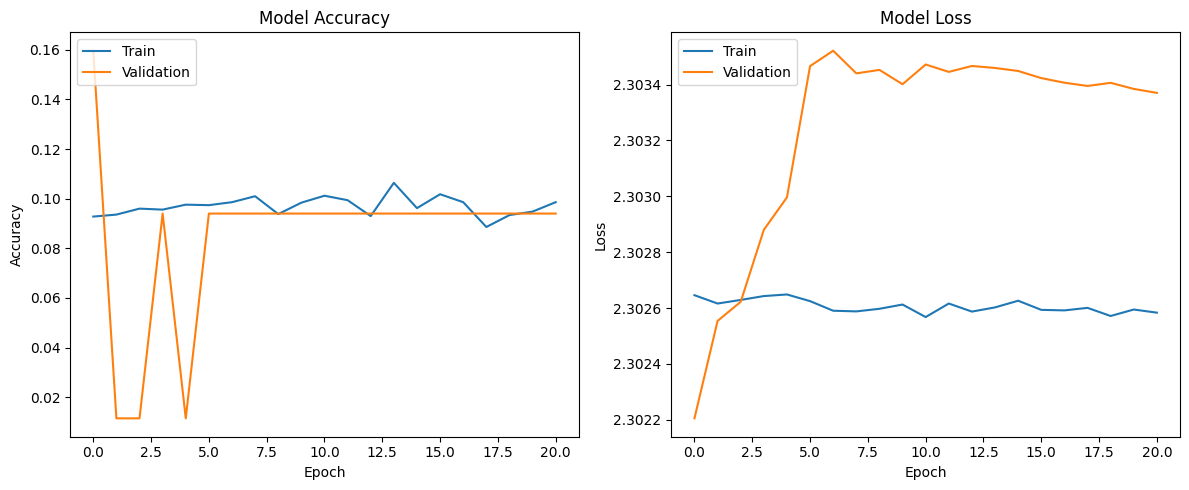

Evaluating model...
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1753 - loss: 2.3022
Validation Loss: 2.3022
Validation Accuracy: 0.1596
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.00      0.00      0.00       161
           2       0.16      1.00      0.28       888
           3       0.00      0.00      0.00       523
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00       354
           6       0.00      0.00      0.00       580
           7       0.00      0.00      0.00       107
           8       0.00      0.00      0.00       973
           9       0.00      0.00      0.00      1763

    accuracy                           0.16      5563
   macro avg       0.02      0.10      0.03      5563
weighted avg       0.03      0.16      0.04      5563



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


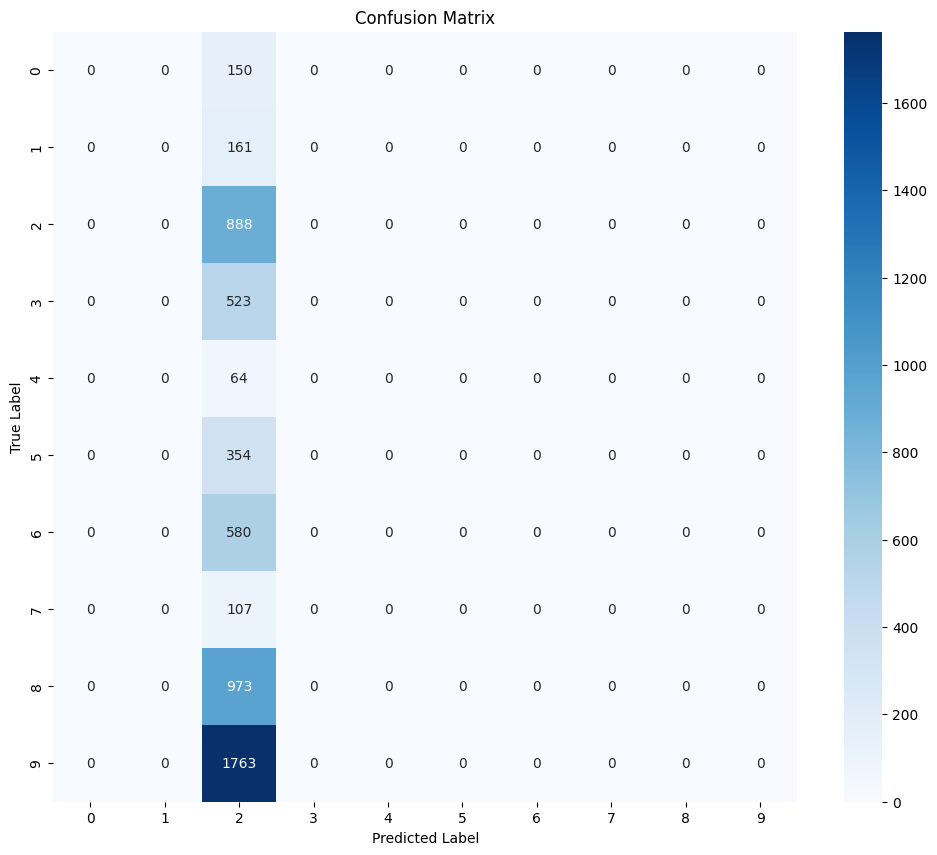

In [33]:
# Load and preprocess data
print("Loading data...")
train_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/train_keypoints.csv")
val_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/val_keypoints.csv")

print(f"Train data shape: {train_keypoints.shape}")
print(f"Validation data shape: {val_keypoints.shape}")

# Function to preprocess keypoints with consistent sequence length
def preprocess_keypoints(df, max_seq_length):
    # Group by video_id
    video_groups = df.groupby('video_id')
    
    sequences = []
    labels = []
    video_ids = []
    
    for video_id, group in tqdm(video_groups, desc="Preprocessing videos"):
        # Sort by frame index
        group = group.sort_values('frame_idx')
        
        # Get label
        if 'label_id' in group.columns:
            label = group['label_id'].iloc[0]
        elif 'label' in group.columns:
            label = group['label'].iloc[0]
        else:
            print(f"Warning: No label column found for video {video_id}")
            continue
        
        # Extract keypoint columns
        keypoint_cols = [col for col in group.columns if any(x in col for x in ['_x', '_y', '_conf'])]
        keypoints = group[keypoint_cols].values
        
        # Handle missing values
        keypoints_df = pd.DataFrame(keypoints)
        keypoints_df = keypoints_df.interpolate(method='linear', limit_direction='both')
        keypoints = keypoints_df.values
        
        # Normalize coordinates to [0, 1] range
        x_cols = [i for i, col in enumerate(keypoint_cols) if '_x' in col]
        y_cols = [i for i, col in enumerate(keypoint_cols) if '_y' in col]
        
        # Estimate from data - find max values
        width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
        height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
        
        # Use reasonable defaults if values are too small
        width = max(width, 640)
        height = max(height, 480)
        
        # Normalize coordinates
        keypoints[:, x_cols] = keypoints[:, x_cols] / width
        keypoints[:, y_cols] = keypoints[:, y_cols] / height
        
        # Replace any remaining NaNs with 0
        keypoints = np.nan_to_num(keypoints)
        
        # Ensure consistent sequence length
        if len(keypoints) > max_seq_length:
            # Use evenly spaced indices to sample the sequence
            indices = np.linspace(0, len(keypoints)-1, max_seq_length, dtype=int)
            keypoints = keypoints[indices]
        elif len(keypoints) < max_seq_length:
            # Pad with zeros
            padding = np.zeros((max_seq_length - len(keypoints), keypoints.shape[1]))
            keypoints = np.vstack([keypoints, padding])
        
        sequences.append(keypoints)
        labels.append(label)
        video_ids.append(video_id)
    
    return np.array(sequences), np.array(labels), video_ids

# Determine max sequence length
train_seq_lengths = train_keypoints.groupby('video_id').size()
val_seq_lengths = val_keypoints.groupby('video_id').size()
MAX_SEQ_LENGTH = 30  # Fixed length for all sequences

# Preprocess data
print(f"Preprocessing data with max sequence length: {MAX_SEQ_LENGTH}")
X_train, y_train, train_video_ids = preprocess_keypoints(train_keypoints, MAX_SEQ_LENGTH)
X_val, y_val, val_video_ids = preprocess_keypoints(val_keypoints, MAX_SEQ_LENGTH)

print(f"Train data shape after preprocessing: {X_train.shape}")
print(f"Validation data shape after preprocessing: {X_val.shape}")

# Create balanced dataset
print("Creating balanced dataset...")
X_train_balanced, y_train_balanced = create_balanced_dataset(X_train, y_train)

# Get number of classes
num_classes = len(np.unique(np.concatenate([y_train_balanced, y_val])))
print(f"Number of classes: {num_classes}")

# Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train_balanced, num_classes=num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# Create model with the correct input shape
input_shape = (MAX_SEQ_LENGTH, X_train.shape[2])
print(f"Creating model with input shape: {input_shape}")
model = create_lstm_attention_se_model(input_shape, num_classes)

# Compile model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=20, 
        restore_best_weights=True, 
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=0.00001, 
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '/kaggle/working/best_model.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        verbose=1
    )
]

# Train model with gradient clipping
print("Training model...")
history = model.fit(
    X_train_balanced, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png')
plt.show()

# Evaluate model
print("Evaluating model...")
loss, accuracy = model.evaluate(X_val, y_val_cat, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_cat, axis=1)

# Classification report
print("\nClassification Report:")
report = classification_report(y_true_classes, y_pred_classes)
print(report)

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()


Loading data...
Train data shape: (415344, 54)
Validation data shape: (89008, 54)
Preprocessing data with max sequence length: 30


Preprocessing videos:  30%|███       | 7796/25959 [00:16<00:49, 364.71it/s]<ipython-input-34-e642156bd255>:149: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-34-e642156bd255>:150: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  30%|███       | 7870/25959 [00:16<00:50, 360.95it/s]<ipython-input-34-e642156bd255>:149: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-34-e642156bd255>:150: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  35%|███▌      | 9086/25959 [00:20<00:47, 352.34it/s]<ipython-input-34-e642156bd255>:149: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypo

Train data shape after preprocessing: (25959, 30, 51)
Validation data shape after preprocessing: (5563, 30, 51)


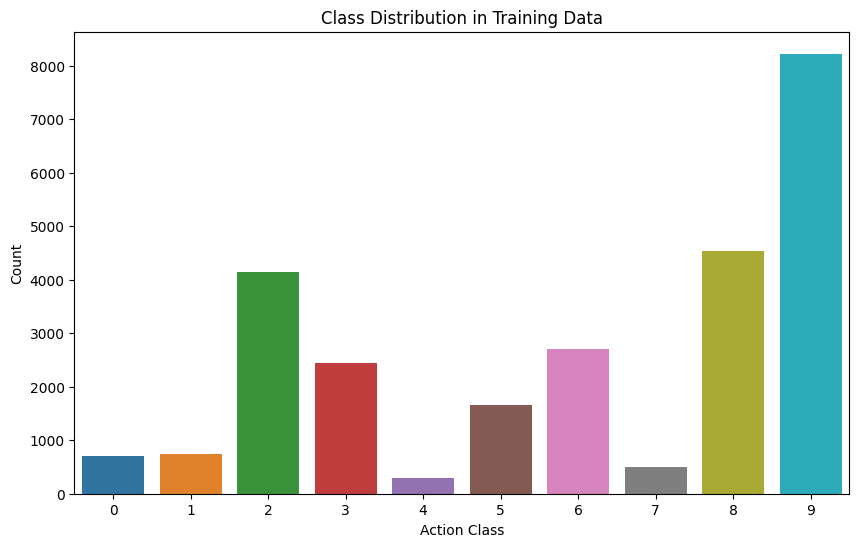

Balancing dataset...


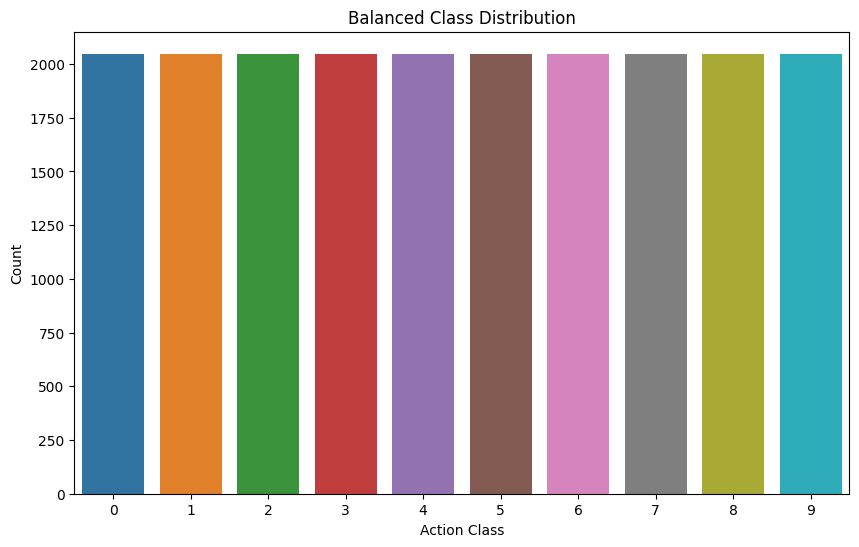

Number of classes: 10
Creating model with input shape: (30, 51)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 30, 51)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 30, 256)             │         184,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ squeeze_excitation_1                 │ (None, 30, 256)             │               0 │
│ (SqueezeExcitation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 30, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ temporal_attention_1                 │ (None, 128)                 │             158 │
│ (TemporalAttention)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 374,248 (1.43 MB)

 Trainable params: 374,248 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model...
Epoch 1/100
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1013 - loss: 2.3030
Epoch 1: val_accuracy improved from -inf to 0.15495, saving model to /kaggle/working/best_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.1013 - loss: 2.3030 - val_accuracy: 0.1550 - val_loss: 2.2899 - learning_rate: 1.0000e-04
Epoch 2/100
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1170 - loss: 2.2936
Epoch 2: val_accuracy did not improve from 0.15495
640/640 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1171 - loss: 2.2936 - val_accuracy: 0.1456 - val_loss: 2.2429 - learning_rate: 1.0000e-04
Epoch 3/100
637/640 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1546 - loss: 2.2428
Epoch 3: val_accuracy improved from 0.15495 to 0.17706, saving model to /kaggle/working/best_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1546 - loss: 2.2427 - val_accuracy: 0.1771 - val_loss: 2.2375 - learning_rate: 1.0000e-04
Epoch 4/100
64

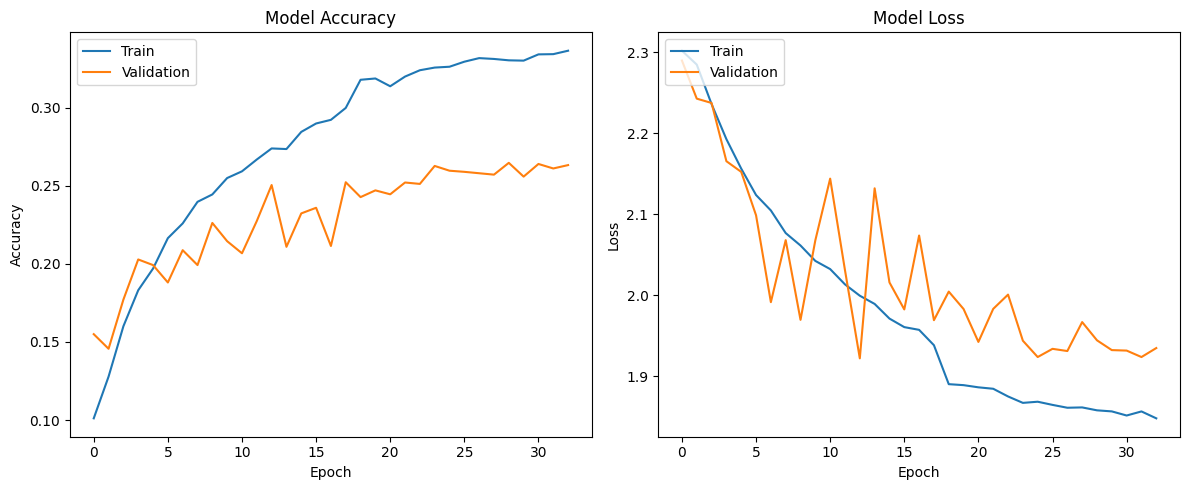

Evaluating model...
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2634 - loss: 1.8837
Validation Loss: 1.9220
Validation Accuracy: 0.2504
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.28      0.21       150
           1       0.07      0.14      0.10       161
           2       0.29      0.13      0.18       888
           3       0.20      0.48      0.28       523
           4       0.12      0.31      0.17        64
           5       0.24      0.04      0.06       354
           6       0.30      0.33      0.32       580
           7       0.04      0.33      0.07       107
           8       0.38      0.42      0.40       973
           9       0.50      0.17      0.25      1763

    accuracy                           0.25      5563
   macro avg       0.23      0.26      0.20      5563
weighted avg       0.35      0.25      0.25      5563



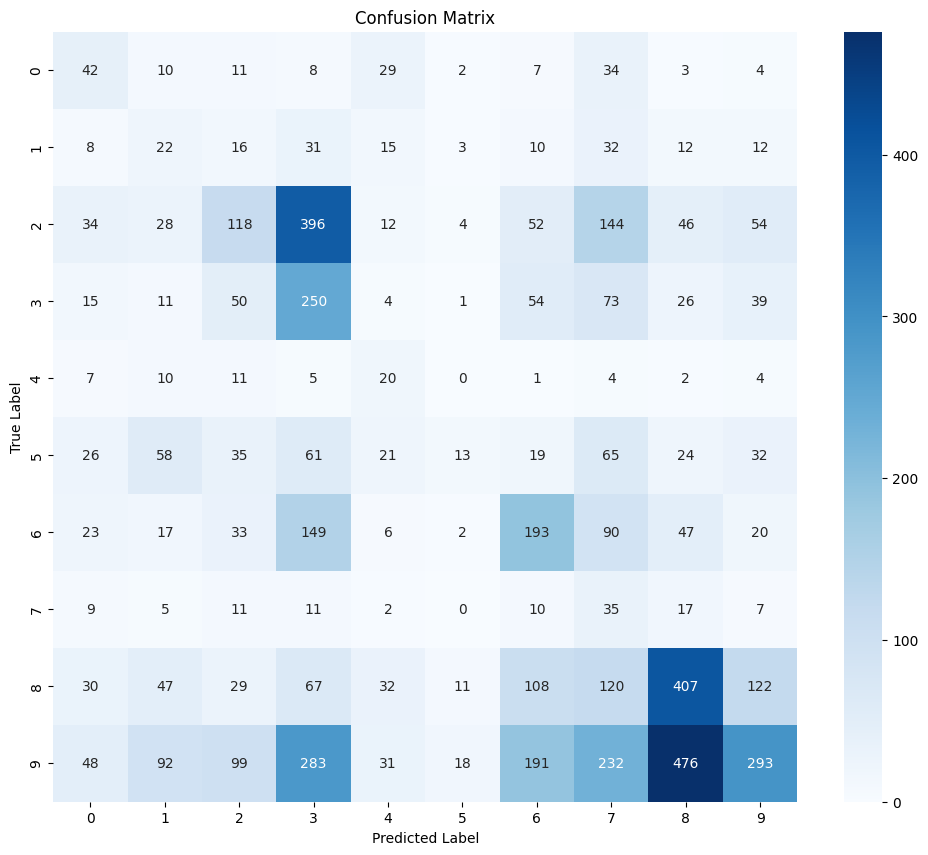

Model saved to /kaggle/working/final_model.keras


In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

# Custom Attention Layer
class TemporalAttention(Layer):
    def __init__(self, **kwargs):
        super(TemporalAttention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(TemporalAttention, self).build(input_shape)
    
    def call(self, x):
        # Alignment scores
        e = tf.math.tanh(tf.matmul(x, self.W) + self.b)
        e = tf.squeeze(e, axis=-1)
        
        # Attention weights
        alpha = tf.nn.softmax(e)
        alpha = tf.expand_dims(alpha, axis=-1)
        
        # Context vector
        context = x * alpha
        context = tf.reduce_sum(context, axis=1)
        
        return context
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

# Squeeze-and-Excitation Block
class SqueezeExcitation(Layer):
    def __init__(self, filters, reduction_ratio=16, **kwargs):
        super(SqueezeExcitation, self).__init__(**kwargs)
        self.filters = filters
        self.reduction_ratio = reduction_ratio
        
    def build(self, input_shape):
        self.squeeze = GlobalAveragePooling1D()
        self.excitation = tf.keras.Sequential([
            Dense(self.filters // self.reduction_ratio, activation='relu'),
            Dense(self.filters, activation='sigmoid')
        ])
        super(SqueezeExcitation, self).build(input_shape)
        
    def call(self, inputs):
        # Squeeze (global information embedding)
        x = self.squeeze(inputs)
        
        # Excitation (adaptive recalibration)
        x = self.excitation(x)
        
        # Scale the input feature maps
        x = tf.reshape(x, [-1, 1, self.filters])
        return inputs * x
    
    def compute_output_shape(self, input_shape):
        return input_shape

# Function to balance dataset through combination of undersampling and oversampling
def balance_dataset(X, y, target_samples_per_class=None):
    unique_classes = np.unique(y)
    
    if target_samples_per_class is None:
        # Use median count as target if not specified
        class_counts = [np.sum(y == c) for c in unique_classes]
        target_samples_per_class = int(np.median(class_counts))
    
    X_balanced = []
    y_balanced = []
    
    for cls in unique_classes:
        # Get samples for this class
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        n_samples = len(X_cls)
        
        if n_samples > target_samples_per_class:
            # Undersample majority classes
            indices = np.random.choice(n_samples, target_samples_per_class, replace=False)
            X_balanced.append(X_cls[indices])
            y_balanced.append(y_cls[indices])
        else:
            # Oversample minority classes
            X_resampled = resample(X_cls, 
                                  replace=True,
                                  n_samples=target_samples_per_class,
                                  random_state=42)
            y_resampled = np.full(target_samples_per_class, cls)
            X_balanced.append(X_resampled)
            y_balanced.append(y_resampled)
    
    return np.vstack(X_balanced), np.concatenate(y_balanced)

# Function to preprocess keypoints with consistent sequence length
def preprocess_keypoints(df, max_seq_length):
    # Group by video_id
    video_groups = df.groupby('video_id')
    
    sequences = []
    labels = []
    video_ids = []
    
    for video_id, group in tqdm(video_groups, desc="Preprocessing videos"):
        # Sort by frame index
        group = group.sort_values('frame_idx')
        
        # Get label
        if 'label_id' in group.columns:
            label = group['label_id'].iloc[0]
        elif 'label' in group.columns:
            label = group['label'].iloc[0]
        else:
            print(f"Warning: No label column found for video {video_id}")
            continue
        
        # Extract keypoint columns
        keypoint_cols = [col for col in group.columns if any(x in col for x in ['_x', '_y', '_conf'])]
        keypoints = group[keypoint_cols].values
        
        # Handle missing values
        keypoints_df = pd.DataFrame(keypoints)
        keypoints_df = keypoints_df.interpolate(method='linear', limit_direction='both')
        keypoints = keypoints_df.values
        
        # Normalize coordinates to [0, 1] range
        x_cols = [i for i, col in enumerate(keypoint_cols) if '_x' in col]
        y_cols = [i for i, col in enumerate(keypoint_cols) if '_y' in col]
        
        # Estimate from data - find max values
        width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
        height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
        
        # Use reasonable defaults if values are too small
        width = max(width, 640)
        height = max(height, 480)
        
        # Normalize coordinates
        keypoints[:, x_cols] = keypoints[:, x_cols] / width
        keypoints[:, y_cols] = keypoints[:, y_cols] / height
        
        # Replace any remaining NaNs with 0
        keypoints = np.nan_to_num(keypoints)
        
        # Ensure consistent sequence length
        if len(keypoints) > max_seq_length:
            # Use evenly spaced indices to sample the sequence
            indices = np.linspace(0, len(keypoints)-1, max_seq_length, dtype=int)
            keypoints = keypoints[indices]
        elif len(keypoints) < max_seq_length:
            # Pad with zeros
            padding = np.zeros((max_seq_length - len(keypoints), keypoints.shape[1]))
            keypoints = np.vstack([keypoints, padding])
        
        sequences.append(keypoints)
        labels.append(label)
        video_ids.append(video_id)
    
    return np.array(sequences), np.array(labels), video_ids

# Create the attention-enhanced LSTM model with SE blocks
def create_attention_se_lstm_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # First Bidirectional LSTM layer
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm1 = Dropout(0.5)(lstm1)
    
    # Apply Squeeze-and-Excitation to enhance feature representation
    se1 = SqueezeExcitation(filters=256)(lstm1)
    
    # Second Bidirectional LSTM layer
    lstm2 = Bidirectional(LSTM(64, return_sequences=True))(se1)
    lstm2 = Dropout(0.5)(lstm2)
    
    # Apply temporal attention to focus on important frames
    attention = TemporalAttention()(lstm2)
    
    # Dense layers for classification
    dense1 = Dense(128, activation='relu')(attention)
    dense1 = Dropout(0.5)(dense1)
    
    dense2 = Dense(64, activation='relu')(dense1)
    dense2 = Dropout(0.3)(dense2)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(dense2)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Main execution
def main():
    # Load data
    print("Loading data...")
    train_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/train_keypoints.csv")
    val_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/val_keypoints.csv")
    
    print(f"Train data shape: {train_keypoints.shape}")
    print(f"Validation data shape: {val_keypoints.shape}")
    
    # Check for label column
    if 'label_id' not in train_keypoints.columns and 'label' not in train_keypoints.columns:
        print("Warning: No label column found in the data. Checking if we need to add it...")
        
        # Try to load annotations
        try:
            import json
            with open("/kaggle/input/spacejam-action-recognition/annotation_dict.json", "r") as f:
                annotation_content = f.read()
                annotation_content = annotation_content.replace("'", '"')
                annotation_dict = json.loads(annotation_content)
                print(f"Loaded {len(annotation_dict)} annotations")
                
                # Add labels to the dataframes
                train_keypoints['label_id'] = train_keypoints['video_id'].map(annotation_dict)
                val_keypoints['label_id'] = val_keypoints['video_id'].map(annotation_dict)
                
                print("Added labels to the dataframes")
        except Exception as e:
            print(f"Error loading annotations: {str(e)}")
    
    # Set max sequence length
    MAX_SEQ_LENGTH = 30
    
    # Preprocess data
    print(f"Preprocessing data with max sequence length: {MAX_SEQ_LENGTH}")
    X_train, y_train, train_video_ids = preprocess_keypoints(train_keypoints, MAX_SEQ_LENGTH)
    X_val, y_val, val_video_ids = preprocess_keypoints(val_keypoints, MAX_SEQ_LENGTH)
    
    print(f"Train data shape after preprocessing: {X_train.shape}")
    print(f"Validation data shape after preprocessing: {X_val.shape}")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y_train)
    plt.title('Class Distribution in Training Data')
    plt.xlabel('Action Class')
    plt.ylabel('Count')
    plt.savefig('/kaggle/working/class_distribution.png')
    plt.show()
    
    # Balance the dataset
    print("Balancing dataset...")
    X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train)
    
    # Verify balanced distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y_train_balanced)
    plt.title('Balanced Class Distribution')
    plt.xlabel('Action Class')
    plt.ylabel('Count')
    plt.savefig('/kaggle/working/balanced_distribution.png')
    plt.show()
    
    # Get number of classes
    num_classes = len(np.unique(np.concatenate([y_train_balanced, y_val])))
    print(f"Number of classes: {num_classes}")
    
    # Convert labels to categorical
    y_train_cat = tf.keras.utils.to_categorical(y_train_balanced, num_classes=num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
    
    # Create model
    input_shape = (MAX_SEQ_LENGTH, X_train.shape[2])
    print(f"Creating model with input shape: {input_shape}")
    model = create_attention_se_lstm_model(input_shape, num_classes)
    
    # Compile model
    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(model.summary())
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1),
        ModelCheckpoint('/kaggle/working/best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]
    
    # Train model
    print("Training model...")
    history = model.fit(
        X_train_balanced, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_history.png')
    plt.show()
    
    # Evaluate model
    print("Evaluating model...")
    loss, accuracy = model.evaluate(X_val, y_val_cat, verbose=1)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_cat, axis=1)
    
    # Classification report
    print("\nClassification Report:")
    report = classification_report(y_true_classes, y_pred_classes)
    print(report)
    
    # Confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('/kaggle/working/confusion_matrix.png')
    plt.show()
    
    # Save model
    model.save('/kaggle/working/final_model.keras')
    print("Model saved to /kaggle/working/final_model.keras")

if __name__ == "__main__":
    main()


In [35]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.models import Model

def create_cnn_lstm_hybrid_model(input_shape, num_classes, sequence_length):
    """
    Create a hybrid CNN-LSTM model for action recognition
    
    Args:
        input_shape: Shape of input frames (height, width, channels)
        num_classes: Number of action classes to predict
        sequence_length: Number of frames in each sequence
    
    Returns:
        A compiled Keras model
    """
    # 1. CNN Feature Extractor
    # Using a pre-trained CNN model (InceptionResNetV2) for spatial feature extraction
    cnn_model = InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=input_shape
    )
    
    # Freeze the convolutional base to use pre-trained weights without modification
    for layer in cnn_model.layers:
        layer.trainable = False
    
    # 2. Create the input layer for sequences of frames
    frame_input = Input(shape=(sequence_length,) + input_shape)
    
    # 3. Apply CNN to each frame in the sequence using TimeDistributed
    encoded_frames = TimeDistributed(cnn_model)(frame_input)
    
    # 4. LSTM layers for temporal feature extraction
    lstm_1 = LSTM(256, return_sequences=True)(encoded_frames)
    lstm_1 = Dropout(0.5)(lstm_1)
    
    lstm_2 = LSTM(128)(lstm_1)
    lstm_2 = Dropout(0.5)(lstm_2)
    
    # 5. Dense layers for classification
    dense_1 = Dense(128, activation='relu')(lstm_2)
    dense_1 = Dropout(0.3)(dense_1)
    
    output = Dense(num_classes, activation='softmax')(dense_1)
    
    # 6. Create and compile the model
    model = Model(inputs=frame_input, outputs=output)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


Loading data...
Train data shape: (415344, 54)
Validation data shape: (89008, 54)
Preprocessing data with max sequence length: 30


Preprocessing videos:  30%|██▉       | 7772/25959 [00:17<00:53, 337.02it/s]<ipython-input-40-8f6eec58230d>:104: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-40-8f6eec58230d>:105: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  30%|███       | 7873/25959 [00:17<00:56, 321.27it/s]<ipython-input-40-8f6eec58230d>:104: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-40-8f6eec58230d>:105: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  35%|███▌      | 9096/25959 [00:20<00:49, 340.49it/s]<ipython-input-40-8f6eec58230d>:104: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypo

Train data shape after preprocessing: (25959, 30, 51)
Validation data shape after preprocessing: (5563, 30, 51)


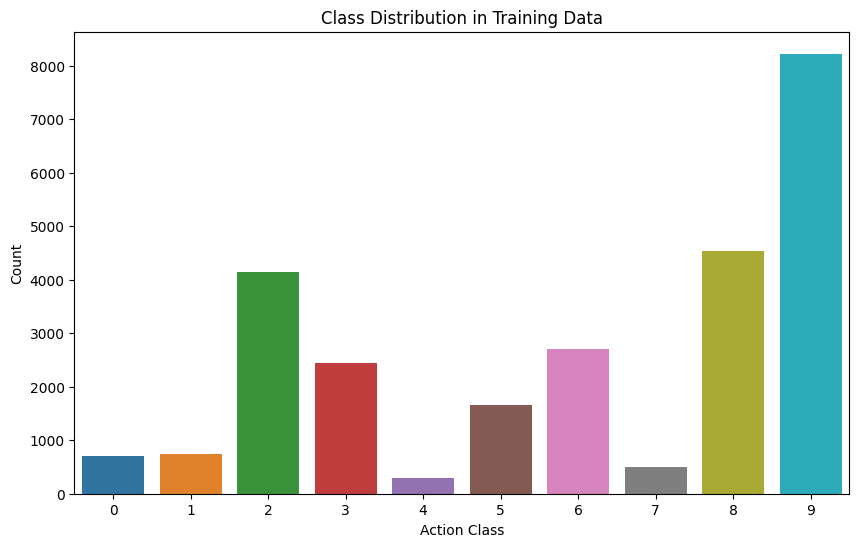

Balancing dataset...


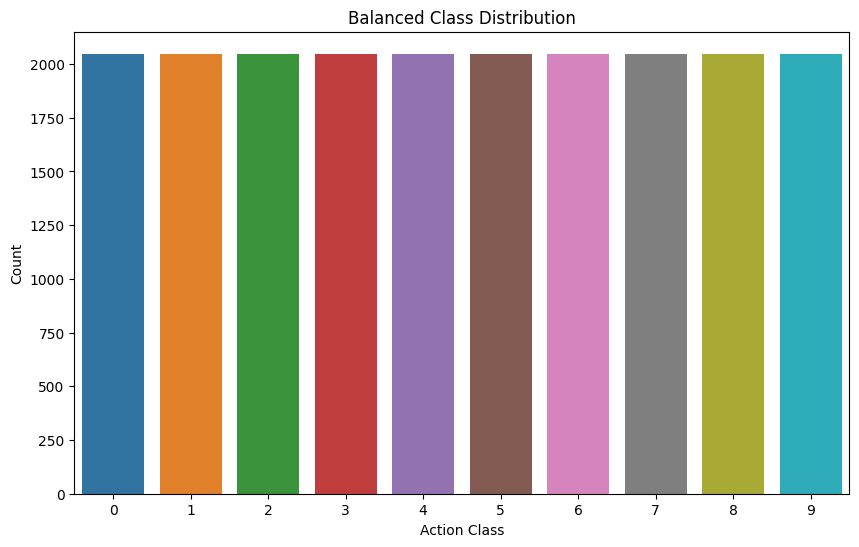

Number of classes: 10
Creating model with input shape: (30, 51)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 30, 51)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 30, 64)              │           9,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 15, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 15, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 7, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 7, 256)              │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 7, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 711,306 (2.71 MB)

 Trainable params: 710,410 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

None
Training model...
Epoch 1/100
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1375 - loss: 2.2770
Epoch 1: val_accuracy improved from -inf to 0.16592, saving model to /kaggle/working/best_hybrid_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.1376 - loss: 2.2769 - val_accuracy: 0.1659 - val_loss: 2.2512 - learning_rate: 1.0000e-04
Epoch 2/100
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2264 - loss: 2.1111
Epoch 2: val_accuracy improved from 0.16592 to 0.20834, saving model to /kaggle/working/best_hybrid_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.2264 - loss: 2.1110 - val_accuracy: 0.2083 - val_loss: 2.0470 - learning_rate: 1.0000e-04
Epoch 3/100
637/640 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2952 - loss: 1.9575
Epoch 3: val_accuracy improved from 0.20834 to 0.25436, saving model to /kaggle/working/best_hybrid_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.2953 - loss: 1.9573 - val_accu

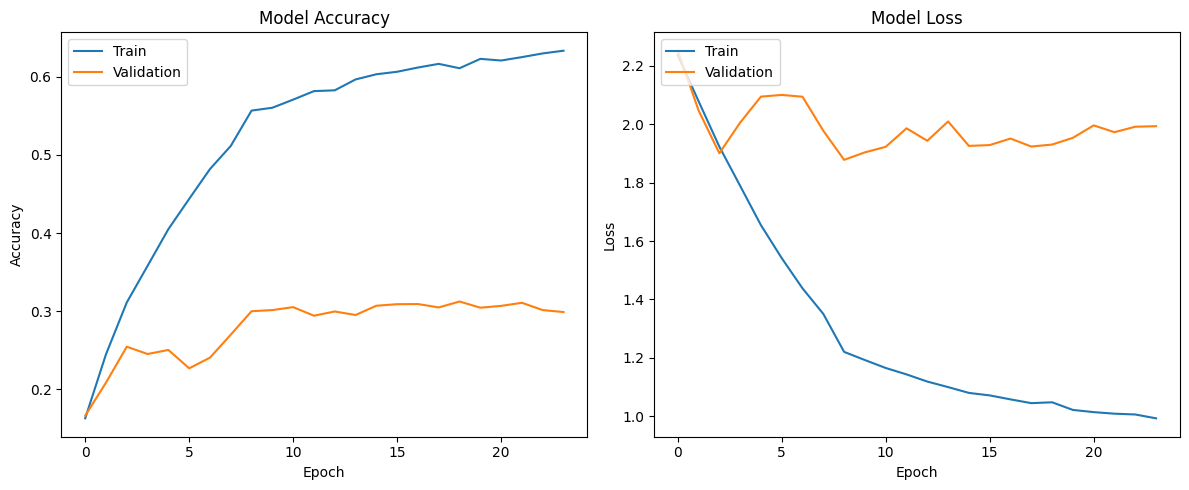

Evaluating model...
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3061 - loss: 1.8441
Validation Loss: 1.8777
Validation Accuracy: 0.2998
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.28      0.18       150
           1       0.10      0.24      0.14       161
           2       0.37      0.26      0.30       888
           3       0.27      0.38      0.31       523
           4       0.11      0.16      0.13        64
           5       0.22      0.17      0.19       354
           6       0.29      0.43      0.35       580
           7       0.07      0.21      0.10       107
           8       0.38      0.52      0.44       973
           9       0.50      0.18      0.26      1763

    accuracy                           0.30      5563
   macro avg       0.24      0.28      0.24      5563
weighted avg       0.36      0.30      0.30      5563



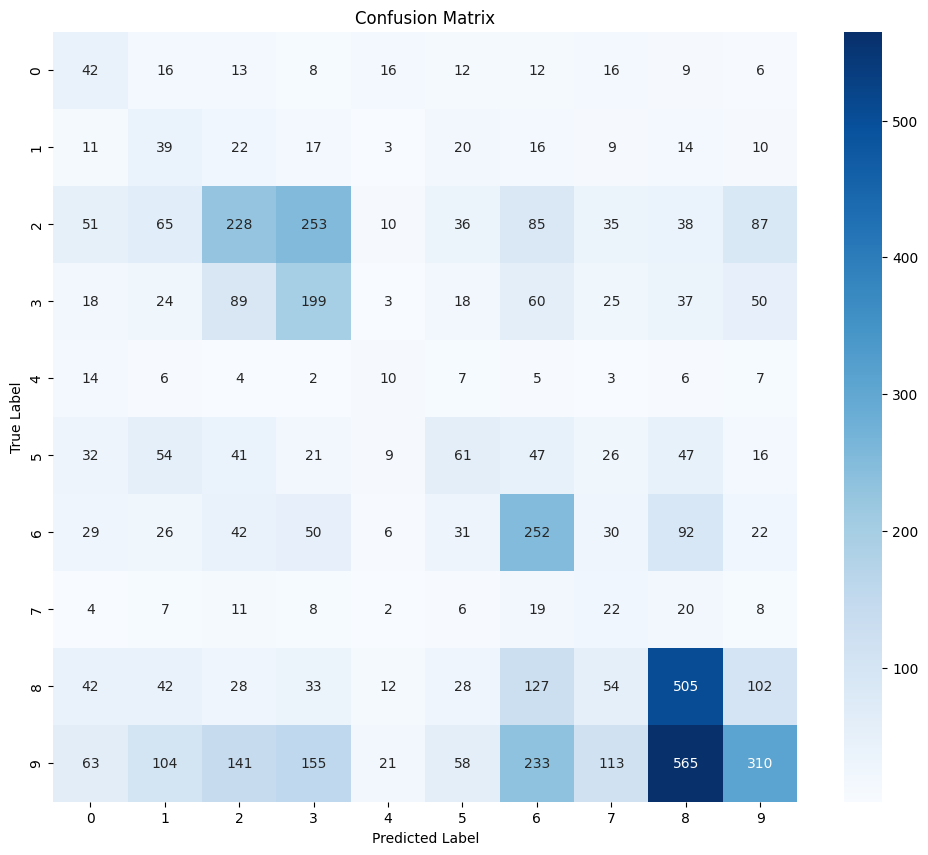

Model saved to /kaggle/working/final_hybrid_model.keras


In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, LSTM, Bidirectional, BatchNormalization, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

def create_hybrid_cnn_lstm_model(input_shape, num_classes):
    """
    Create a hybrid CNN-LSTM model for keypoint-based action recognition
    
    Args:
        input_shape: Shape of input sequences (timesteps, features)
        num_classes: Number of action classes to predict
    
    Returns:
        A compiled Keras model
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # 1D CNN layers for spatial feature extraction from keypoints
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Bidirectional LSTM layers for temporal feature extraction
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.5)(x)
    
    # Dense layers for classification
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def preprocess_keypoints(df, max_seq_length=30):
    """
    Preprocess keypoint data for CNN-LSTM model
    
    Args:
        df: DataFrame containing keypoint data
        max_seq_length: Maximum sequence length
    
    Returns:
        X: Processed sequences
        y: Labels
        video_ids: List of video IDs
    """
    # Group by video_id
    video_groups = df.groupby('video_id')
    
    sequences = []
    labels = []
    video_ids = []
    
    for video_id, group in tqdm(video_groups, desc="Preprocessing videos"):
        # Sort by frame index
        group = group.sort_values('frame_idx')
        
        # Get label
        label = group['label_id'].iloc[0]
        
        # Extract keypoint columns (exclude metadata columns)
        keypoint_cols = [col for col in group.columns if any(x in col for x in ['_x', '_y', '_conf'])]
        keypoints = group[keypoint_cols].values
        
        # Handle missing values
        keypoints_df = pd.DataFrame(keypoints)
        keypoints_df = keypoints_df.interpolate(method='linear', limit_direction='both')
        keypoints = keypoints_df.values
        
        # Normalize coordinates to [0, 1] range
        x_cols = [i for i, col in enumerate(keypoint_cols) if '_x' in col]
        y_cols = [i for i, col in enumerate(keypoint_cols) if '_y' in col]
        
        # Find max values for normalization
        width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
        height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
        
        # Use reasonable defaults if values are too small
        width = max(width, 640)
        height = max(height, 480)
        
        # Normalize coordinates
        keypoints[:, x_cols] = keypoints[:, x_cols] / width
        keypoints[:, y_cols] = keypoints[:, y_cols] / height
        
        # Replace any remaining NaNs with 0
        keypoints = np.nan_to_num(keypoints)
        
        # Ensure consistent sequence length
        if len(keypoints) > max_seq_length:
            # Use evenly spaced indices to sample the sequence
            indices = np.linspace(0, len(keypoints)-1, max_seq_length, dtype=int)
            keypoints = keypoints[indices]
        elif len(keypoints) < max_seq_length:
            # Pad with zeros
            padding = np.zeros((max_seq_length - len(keypoints), keypoints.shape[1]))
            keypoints = np.vstack([keypoints, padding])
        
        sequences.append(keypoints)
        labels.append(label)
        video_ids.append(video_id)
    
    return np.array(sequences), np.array(labels), video_ids

def balance_dataset(X, y, target_samples_per_class=None):
    """
    Balance dataset through combination of undersampling and oversampling
    
    Args:
        X: Input features
        y: Labels
        target_samples_per_class: Target number of samples per class
    
    Returns:
        X_balanced: Balanced features
        y_balanced: Balanced labels
    """
    from sklearn.utils import resample
    
    unique_classes = np.unique(y)
    
    if target_samples_per_class is None:
        # Use median count as target if not specified
        class_counts = [np.sum(y == c) for c in unique_classes]
        target_samples_per_class = int(np.median(class_counts))
    
    X_balanced = []
    y_balanced = []
    
    for cls in unique_classes:
        # Get samples for this class
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        n_samples = len(X_cls)
        
        if n_samples > target_samples_per_class:
            # Undersample majority classes
            indices = np.random.choice(n_samples, target_samples_per_class, replace=False)
            X_balanced.append(X_cls[indices])
            y_balanced.append(y_cls[indices])
        else:
            # Oversample minority classes
            X_resampled = resample(X_cls, 
                                  replace=True,
                                  n_samples=target_samples_per_class,
                                  random_state=42)
            y_resampled = np.full(target_samples_per_class, cls)
            X_balanced.append(X_resampled)
            y_balanced.append(y_resampled)
    
    return np.vstack(X_balanced), np.concatenate(y_balanced)

# Main execution
def main():
    # Load data
    print("Loading data...")
    train_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/train_keypoints.csv")
    val_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/val_keypoints.csv")
    
    print(f"Train data shape: {train_keypoints.shape}")
    print(f"Validation data shape: {val_keypoints.shape}")
    
    # Set max sequence length
    MAX_SEQ_LENGTH = 30
    
    # Preprocess data
    print(f"Preprocessing data with max sequence length: {MAX_SEQ_LENGTH}")
    X_train, y_train, train_video_ids = preprocess_keypoints(train_keypoints, MAX_SEQ_LENGTH)
    X_val, y_val, val_video_ids = preprocess_keypoints(val_keypoints, MAX_SEQ_LENGTH)
    
    print(f"Train data shape after preprocessing: {X_train.shape}")
    print(f"Validation data shape after preprocessing: {X_val.shape}")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y_train)
    plt.title('Class Distribution in Training Data')
    plt.xlabel('Action Class')
    plt.ylabel('Count')
    plt.savefig('/kaggle/working/class_distribution.png')
    plt.show()
    
    # Balance the dataset
    print("Balancing dataset...")
    X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train)
    
    # Verify balanced distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y_train_balanced)
    plt.title('Balanced Class Distribution')
    plt.xlabel('Action Class')
    plt.ylabel('Count')
    plt.savefig('/kaggle/working/balanced_distribution.png')
    plt.show()
    
    # Get number of classes
    num_classes = len(np.unique(np.concatenate([y_train_balanced, y_val])))
    print(f"Number of classes: {num_classes}")
    
    # Convert labels to categorical
    y_train_cat = tf.keras.utils.to_categorical(y_train_balanced, num_classes=num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
    
    # Create model
    input_shape = (MAX_SEQ_LENGTH, X_train.shape[2])
    print(f"Creating model with input shape: {input_shape}")
    model = create_hybrid_cnn_lstm_model(input_shape, num_classes)
    
    print(model.summary())
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1),
        ModelCheckpoint('/kaggle/working/best_hybrid_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]
    
    # Train model
    print("Training model...")
    history = model.fit(
        X_train_balanced, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.savefig('/kaggle/working/hybrid_training_history.png')
    plt.show()
    
    # Evaluate model
    print("Evaluating model...")
    loss, accuracy = model.evaluate(X_val, y_val_cat, verbose=1)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_cat, axis=1)
    
    # Classification report
    print("\nClassification Report:")
    report = classification_report(y_true_classes, y_pred_classes)
    print(report)
    
    # Confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('/kaggle/working/hybrid_confusion_matrix.png')
    plt.show()
    
    # Save model
    model.save('/kaggle/working/final_hybrid_model.keras')
    print("Model saved to /kaggle/working/final_hybrid_model.keras")

if __name__ == "__main__":
    main()


Loading data...
Train data shape: (415344, 54)
Validation data shape: (89008, 54)
Preprocessing data with max sequence length: 30


Preprocessing videos:  30%|██▉       | 7779/25959 [00:16<00:49, 369.45it/s]<ipython-input-41-56fa8b64e67c>:104: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-41-56fa8b64e67c>:105: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  30%|███       | 7854/25959 [00:16<00:50, 357.98it/s]<ipython-input-41-56fa8b64e67c>:104: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-41-56fa8b64e67c>:105: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  35%|███▌      | 9097/25959 [00:20<00:48, 347.80it/s]<ipython-input-41-56fa8b64e67c>:104: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypo

Train data shape after preprocessing: (25959, 30, 51)
Validation data shape after preprocessing: (5563, 30, 51)


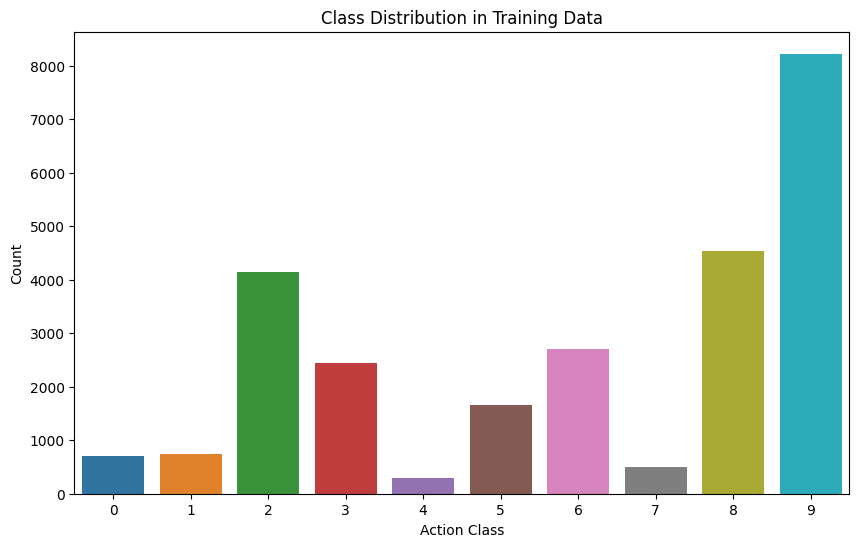

Balancing dataset...


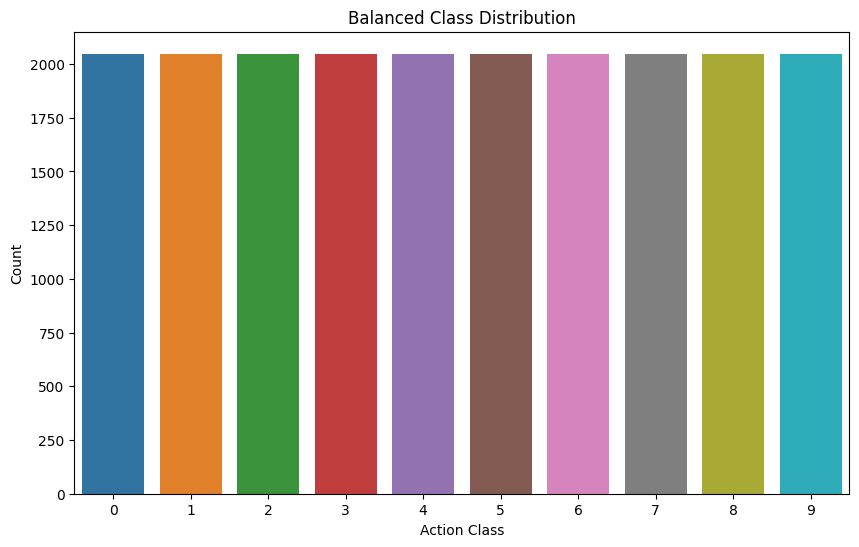

Number of classes: 10
Creating model with input shape: (30, 51)


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 30, 51)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 30, 64)              │           9,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 15, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 15, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 7, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 7, 256)              │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 7, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 711,306 (2.71 MB)

 Trainable params: 710,410 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

None
Training model...
Epoch 1/50
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1388 - loss: 2.2704
Epoch 1: val_accuracy improved from -inf to 0.13806, saving model to /kaggle/working/best_hybrid_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.1389 - loss: 2.2703 - val_accuracy: 0.1381 - val_loss: 2.2903 - learning_rate: 1.0000e-04
Epoch 2/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2275 - loss: 2.1103
Epoch 2: val_accuracy improved from 0.13806 to 0.20888, saving model to /kaggle/working/best_hybrid_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.2276 - loss: 2.1103 - val_accuracy: 0.2089 - val_loss: 1.9933 - learning_rate: 1.0000e-04
Epoch 3/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2918 - loss: 1.9567
Epoch 3: val_accuracy did not improve from 0.20888
640/640 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.2919 - loss: 1.9567 - val_accuracy: 0.1852 - val_loss: 2.1522 - learning_rate: 1.0000e-04
Epoch

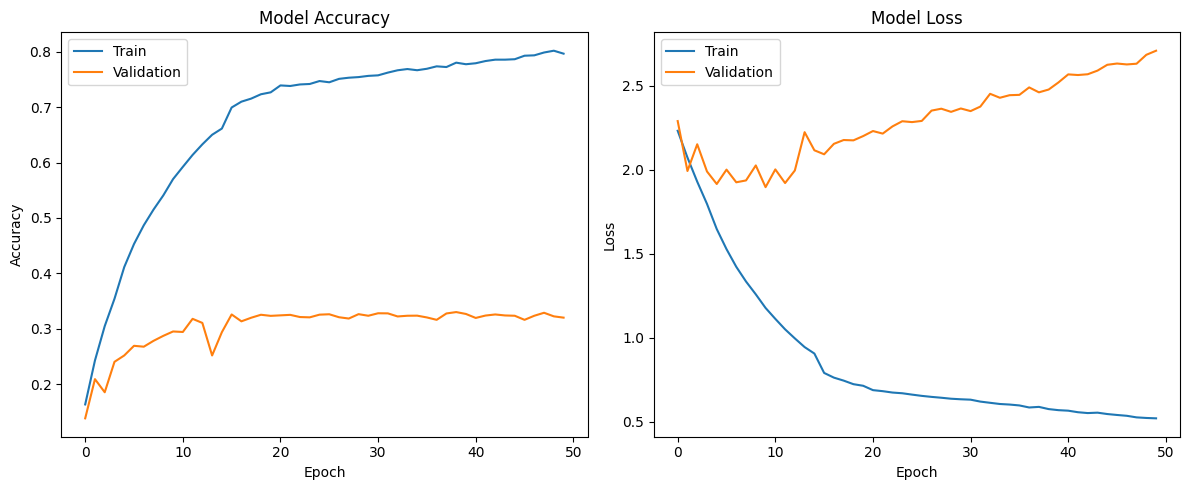

Evaluating model...
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3236 - loss: 2.6454
Validation Loss: 2.7089
Validation Accuracy: 0.3200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.20      0.17       150
           1       0.11      0.17      0.13       161
           2       0.36      0.34      0.35       888
           3       0.22      0.30      0.26       523
           4       0.14      0.12      0.13        64
           5       0.19      0.28      0.23       354
           6       0.31      0.45      0.37       580
           7       0.08      0.10      0.09       107
           8       0.41      0.45      0.43       973
           9       0.46      0.26      0.33      1763

    accuracy                           0.32      5563
   macro avg       0.24      0.27      0.25      5563
weighted avg       0.35      0.32      0.32      5563



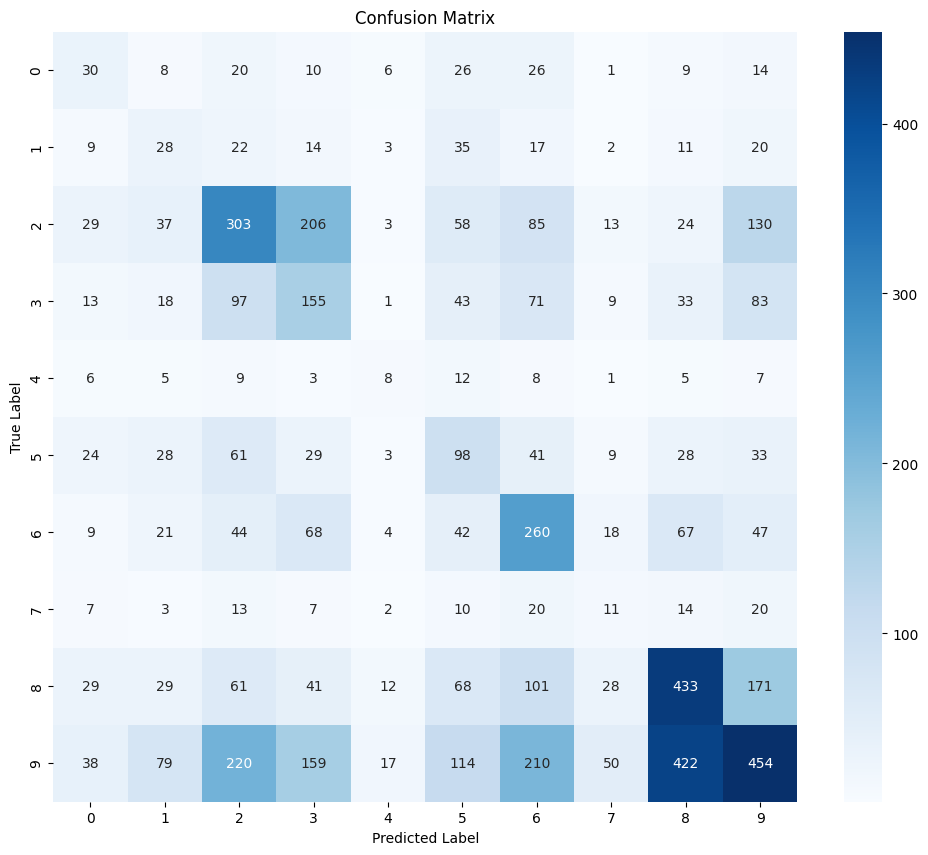

Model saved to /kaggle/working/final_hybrid_model.keras


In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, LSTM, Bidirectional, BatchNormalization, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

def create_hybrid_cnn_lstm_model(input_shape, num_classes):
    """
    Create a hybrid CNN-LSTM model for keypoint-based action recognition
    
    Args:
        input_shape: Shape of input sequences (timesteps, features)
        num_classes: Number of action classes to predict
    
    Returns:
        A compiled Keras model
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # 1D CNN layers for spatial feature extraction from keypoints
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Bidirectional LSTM layers for temporal feature extraction
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.5)(x)
    
    # Dense layers for classification
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def preprocess_keypoints(df, max_seq_length=30):
    """
    Preprocess keypoint data for CNN-LSTM model
    
    Args:
        df: DataFrame containing keypoint data
        max_seq_length: Maximum sequence length
    
    Returns:
        X: Processed sequences
        y: Labels
        video_ids: List of video IDs
    """
    # Group by video_id
    video_groups = df.groupby('video_id')
    
    sequences = []
    labels = []
    video_ids = []
    
    for video_id, group in tqdm(video_groups, desc="Preprocessing videos"):
        # Sort by frame index
        group = group.sort_values('frame_idx')
        
        # Get label
        label = group['label_id'].iloc[0]
        
        # Extract keypoint columns (exclude metadata columns)
        keypoint_cols = [col for col in group.columns if any(x in col for x in ['_x', '_y', '_conf'])]
        keypoints = group[keypoint_cols].values
        
        # Handle missing values
        keypoints_df = pd.DataFrame(keypoints)
        keypoints_df = keypoints_df.interpolate(method='linear', limit_direction='both')
        keypoints = keypoints_df.values
        
        # Normalize coordinates to [0, 1] range
        x_cols = [i for i, col in enumerate(keypoint_cols) if '_x' in col]
        y_cols = [i for i, col in enumerate(keypoint_cols) if '_y' in col]
        
        # Find max values for normalization
        width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
        height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
        
        # Use reasonable defaults if values are too small
        width = max(width, 640)
        height = max(height, 480)
        
        # Normalize coordinates
        keypoints[:, x_cols] = keypoints[:, x_cols] / width
        keypoints[:, y_cols] = keypoints[:, y_cols] / height
        
        # Replace any remaining NaNs with 0
        keypoints = np.nan_to_num(keypoints)
        
        # Ensure consistent sequence length
        if len(keypoints) > max_seq_length:
            # Use evenly spaced indices to sample the sequence
            indices = np.linspace(0, len(keypoints)-1, max_seq_length, dtype=int)
            keypoints = keypoints[indices]
        elif len(keypoints) < max_seq_length:
            # Pad with zeros
            padding = np.zeros((max_seq_length - len(keypoints), keypoints.shape[1]))
            keypoints = np.vstack([keypoints, padding])
        
        sequences.append(keypoints)
        labels.append(label)
        video_ids.append(video_id)
    
    return np.array(sequences), np.array(labels), video_ids

def balance_dataset(X, y, target_samples_per_class=None):
    """
    Balance dataset through combination of undersampling and oversampling
    
    Args:
        X: Input features
        y: Labels
        target_samples_per_class: Target number of samples per class
    
    Returns:
        X_balanced: Balanced features
        y_balanced: Balanced labels
    """
    from sklearn.utils import resample
    
    unique_classes = np.unique(y)
    
    if target_samples_per_class is None:
        # Use median count as target if not specified
        class_counts = [np.sum(y == c) for c in unique_classes]
        target_samples_per_class = int(np.median(class_counts))
    
    X_balanced = []
    y_balanced = []
    
    for cls in unique_classes:
        # Get samples for this class
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        n_samples = len(X_cls)
        
        if n_samples > target_samples_per_class:
            # Undersample majority classes
            indices = np.random.choice(n_samples, target_samples_per_class, replace=False)
            X_balanced.append(X_cls[indices])
            y_balanced.append(y_cls[indices])
        else:
            # Oversample minority classes
            X_resampled = resample(X_cls, 
                                  replace=True,
                                  n_samples=target_samples_per_class,
                                  random_state=42)
            y_resampled = np.full(target_samples_per_class, cls)
            X_balanced.append(X_resampled)
            y_balanced.append(y_resampled)
    
    return np.vstack(X_balanced), np.concatenate(y_balanced)

# Main execution
def main():
    # Load data
    print("Loading data...")
    train_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/train_keypoints.csv")
    val_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/val_keypoints.csv")
    
    print(f"Train data shape: {train_keypoints.shape}")
    print(f"Validation data shape: {val_keypoints.shape}")
    
    # Set max sequence length
    MAX_SEQ_LENGTH = 30
    
    # Preprocess data
    print(f"Preprocessing data with max sequence length: {MAX_SEQ_LENGTH}")
    X_train, y_train, train_video_ids = preprocess_keypoints(train_keypoints, MAX_SEQ_LENGTH)
    X_val, y_val, val_video_ids = preprocess_keypoints(val_keypoints, MAX_SEQ_LENGTH)
    
    print(f"Train data shape after preprocessing: {X_train.shape}")
    print(f"Validation data shape after preprocessing: {X_val.shape}")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y_train)
    plt.title('Class Distribution in Training Data')
    plt.xlabel('Action Class')
    plt.ylabel('Count')
    plt.savefig('/kaggle/working/class_distribution.png')
    plt.show()
    
    # Balance the dataset
    print("Balancing dataset...")
    X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train)
    
    # Verify balanced distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y_train_balanced)
    plt.title('Balanced Class Distribution')
    plt.xlabel('Action Class')
    plt.ylabel('Count')
    plt.savefig('/kaggle/working/balanced_distribution.png')
    plt.show()
    
    # Get number of classes
    num_classes = len(np.unique(np.concatenate([y_train_balanced, y_val])))
    print(f"Number of classes: {num_classes}")
    
    # Convert labels to categorical
    y_train_cat = tf.keras.utils.to_categorical(y_train_balanced, num_classes=num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
    
    # Create model
    input_shape = (MAX_SEQ_LENGTH, X_train.shape[2])
    print(f"Creating model with input shape: {input_shape}")
    model = create_hybrid_cnn_lstm_model(input_shape, num_classes)
    
    print(model.summary())
    
    # Callbacks - early stopping removed
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1),
        ModelCheckpoint('/kaggle/working/best_hybrid_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]
    
    # Train model
    print("Training model...")
    history = model.fit(
        X_train_balanced, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,  # Fixed number of epochs since early stopping is removed
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.savefig('/kaggle/working/hybrid_training_history.png')
    plt.show()
    
    # Evaluate model
    print("Evaluating model...")
    loss, accuracy = model.evaluate(X_val, y_val_cat, verbose=1)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_cat, axis=1)
    
    # Classification report
    print("\nClassification Report:")
    report = classification_report(y_true_classes, y_pred_classes)
    print(report)
    
    # Confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('/kaggle/working/hybrid_confusion_matrix.png')
    plt.show()
    
    # Save model
    model.save('/kaggle/working/final_hybrid_model.keras')
    print("Model saved to /kaggle/working/final_hybrid_model.keras")

if __name__ == "__main__":
    main()


Loading data...
Train data shape: (415344, 54)
Validation data shape: (89008, 54)
Preprocessing data with max sequence length: 30


Preprocessing videos:  30%|██▉       | 7771/25959 [00:22<01:04, 281.63it/s]<ipython-input-44-1c511d9d7823>:174: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-44-1c511d9d7823>:175: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  30%|███       | 7888/25959 [00:22<01:05, 274.96it/s]<ipython-input-44-1c511d9d7823>:174: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
<ipython-input-44-1c511d9d7823>:175: RuntimeWarning: All-NaN slice encountered
  height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
Preprocessing videos:  35%|███▌      | 9103/25959 [00:27<01:05, 258.35it/s]<ipython-input-44-1c511d9d7823>:174: RuntimeWarning: All-NaN slice encountered
  width = np.nanmax(keypoints[:, x_cols]) if keypo

Train data shape after preprocessing: (77877, 30, 89)
Validation data shape after preprocessing: (5563, 30, 89)


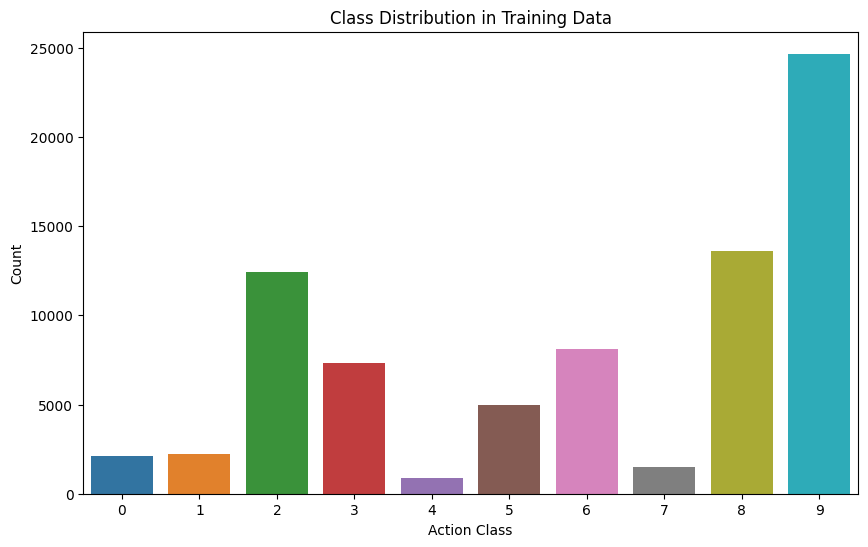

Balancing dataset...


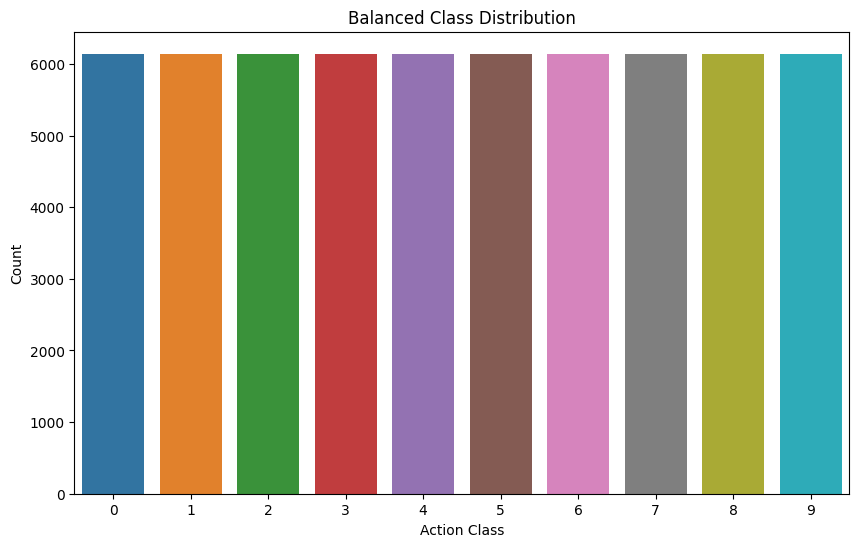

Number of classes: 10
Creating model with input shape: (30, 89)
Performing 5-fold cross-validation...
Training fold 1/5
Epoch 1/100
1532/1536 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1204 - loss: 2.3917
Epoch 1: val_accuracy improved from -inf to 0.20190, saving model to /kaggle/working/fold1_model.keras
1536/1536 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.1204 - loss: 2.3915 - val_accuracy: 0.2019 - val_loss: 2.2575 - learning_rate: 1.0000e-04
Epoch 2/100
1532/1536 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1764 - loss: 2.2661
Epoch 2: val_accuracy improved from 0.20190 to 0.23649, saving model to /kaggle/working/fold1_model.keras
1536/1536 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1764 - loss: 2.2660 - val_accuracy: 0.2365 - val_loss: 2.1438 - learning_rate: 1.0000e-04
Epoch 3/100
1535/1536 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2226 - loss: 2.1703
Epoch 3: val_accuracy improved from 0.23649 to 0.27458, saving model to /kaggle/working/fold1_model.keras


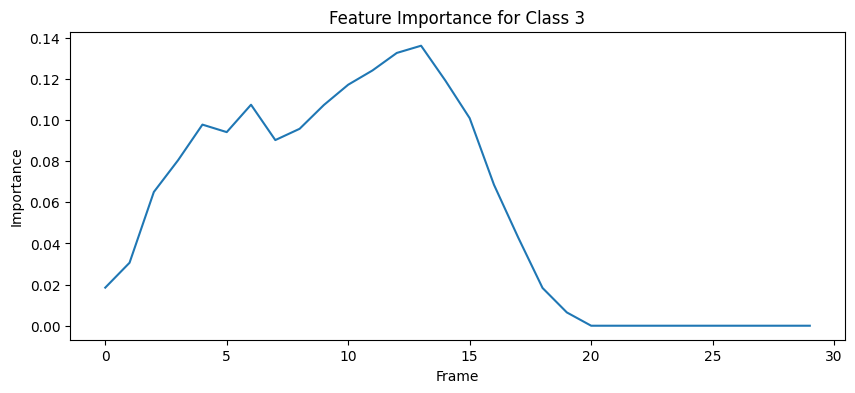

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

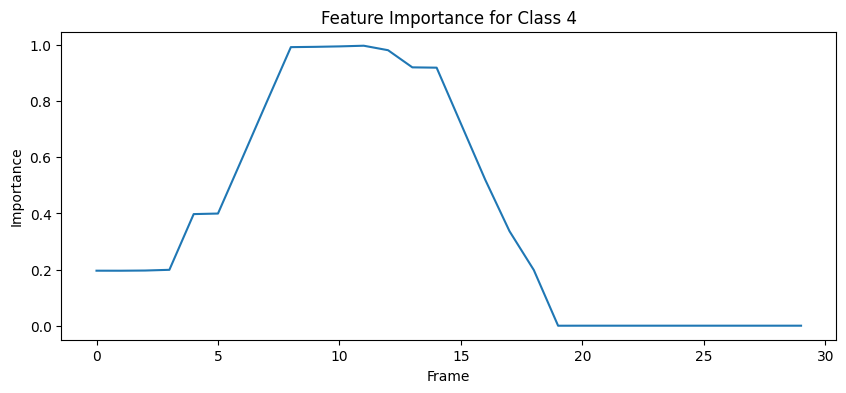

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

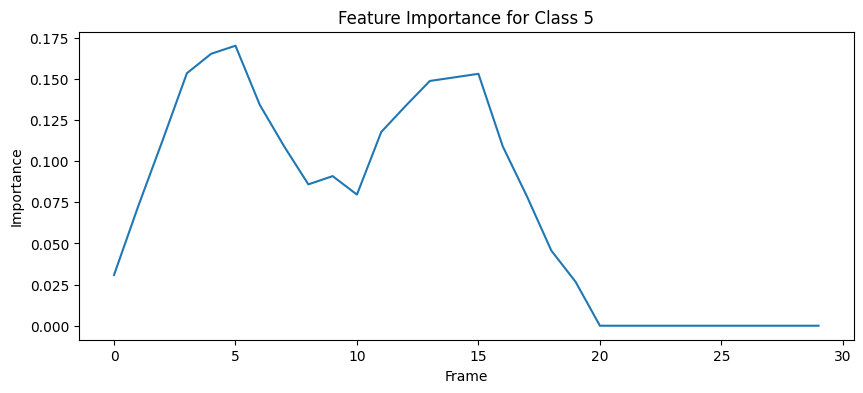

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

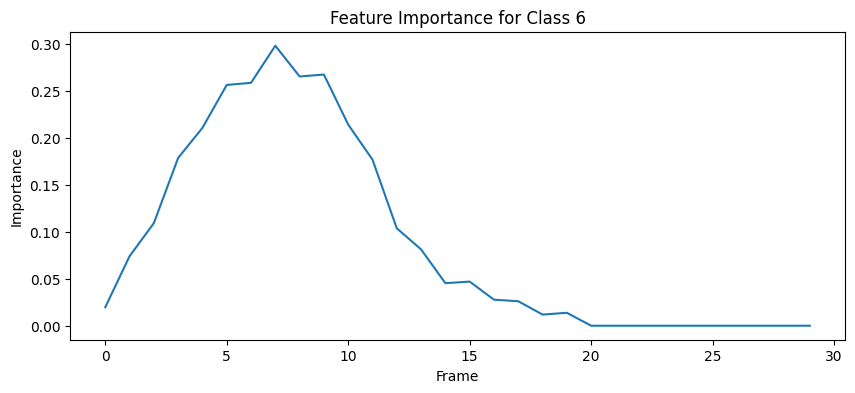

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

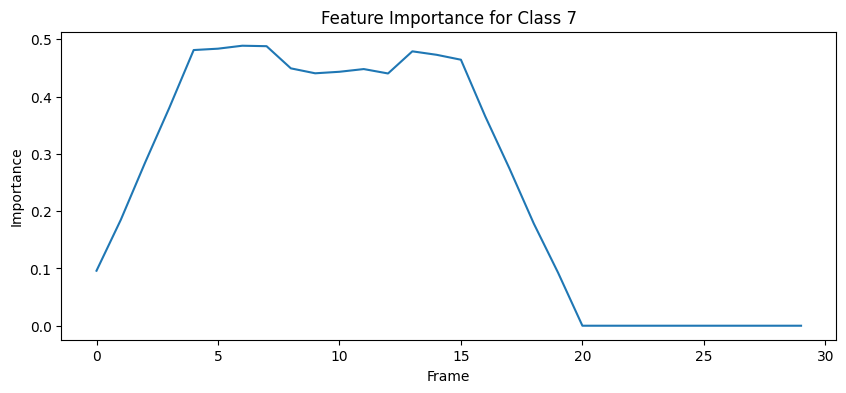

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

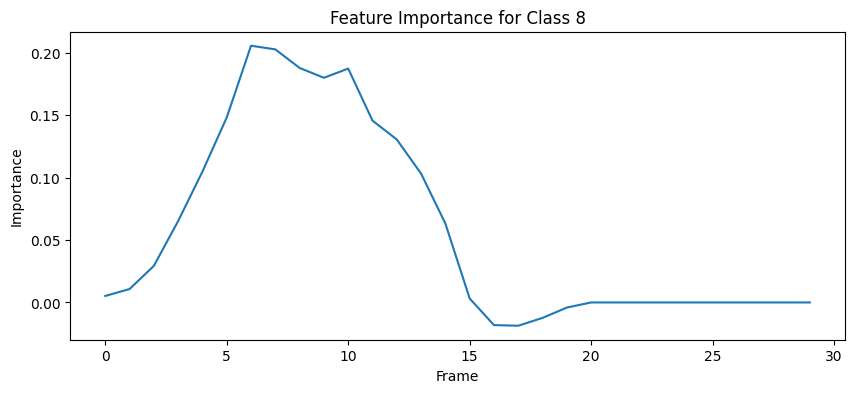

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

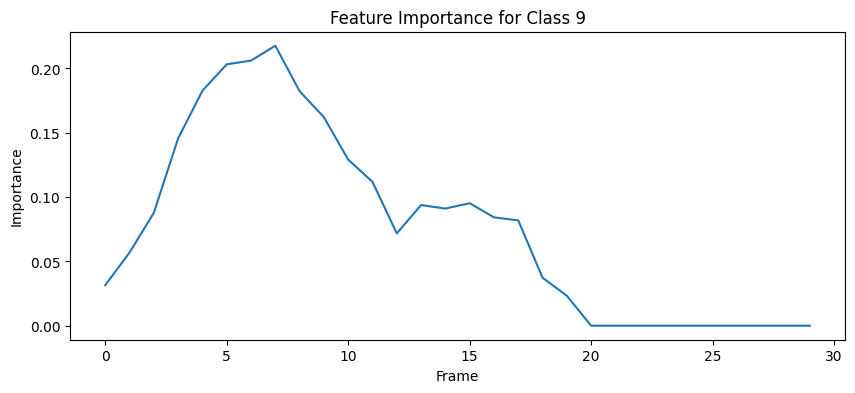

Model saved to /kaggle/working/final_hybrid_model.keras


Complete! Check the working directory for output files.


In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, LSTM, Bidirectional, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

def augment_keypoint_sequence(sequence):
    """Apply augmentation to keypoint sequence"""
    augmented = sequence.copy()
    
    # Add small random noise to coordinates
    x_cols = np.arange(0, sequence.shape[1], 3)  # X coordinates
    y_cols = np.arange(1, sequence.shape[1], 3)  # Y coordinates
    
    # Add noise to x coordinates
    noise_x = np.random.normal(0, 0.02, (sequence.shape[0], len(x_cols)))
    for i, col in enumerate(x_cols):
        augmented[:, col] += noise_x[:, i]
    
    # Add noise to y coordinates
    noise_y = np.random.normal(0, 0.02, (sequence.shape[0], len(y_cols)))
    for i, col in enumerate(y_cols):
        augmented[:, col] += noise_y[:, i]
    
    # Random temporal shift
    if sequence.shape[0] > 5:
        shift = np.random.randint(1, 5)
        augmented = np.roll(augmented, shift, axis=0)
    
    return augmented

def create_simpler_hybrid_model(input_shape, num_classes):
    """Create a simpler hybrid model to reduce overfitting"""
    inputs = Input(shape=input_shape)
    
    # Fewer CNN filters
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Single LSTM layer
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.5)(x)
    
    # Smaller dense layer
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def extract_engineered_features(keypoints):
    """Extract engineered features from keypoints"""
    # Get dimensions
    n_frames, n_features = keypoints.shape
    
    # Identify x, y, and confidence columns
    x_cols = np.arange(0, n_features, 3)  # Every 3rd column starting from 0
    y_cols = np.arange(1, n_features, 3)  # Every 3rd column starting from 1
    conf_cols = np.arange(2, n_features, 3)  # Every 3rd column starting from 2
    
    # Extract coordinates for easier processing
    x_coords = keypoints[:, x_cols]
    y_coords = keypoints[:, y_cols]
    conf = keypoints[:, conf_cols]
    
    # Calculate velocities (frame-to-frame differences)
    if n_frames > 1:
        x_velocity = np.diff(x_coords, axis=0)
        y_velocity = np.diff(y_coords, axis=0)
        
        # Pad to maintain original shape
        x_velocity = np.vstack([np.zeros((1, x_velocity.shape[1])), x_velocity])
        y_velocity = np.vstack([np.zeros((1, y_velocity.shape[1])), y_velocity])
    else:
        x_velocity = np.zeros_like(x_coords)
        y_velocity = np.zeros_like(y_coords)
    
    # Calculate joint angles for key body parts
    # Example: Calculate angle at elbow (using shoulder, elbow, wrist)
    # Note: This is a simplified example. Adjust indices based on your keypoint order
    angles = np.zeros((n_frames, 4))  # Store 4 key angles
    
    # Assuming indices: 5=left_shoulder, 7=left_elbow, 9=left_wrist
    # Calculate left elbow angle
    for i in range(n_frames):
        # Left elbow angle (shoulder-elbow-wrist)
        if conf[i, 5] > 0.5 and conf[i, 7] > 0.5 and conf[i, 9] > 0.5:
            shoulder = np.array([x_coords[i, 5], y_coords[i, 5]])
            elbow = np.array([x_coords[i, 7], y_coords[i, 7]])
            wrist = np.array([x_coords[i, 9], y_coords[i, 9]])
            
            vec1 = shoulder - elbow
            vec2 = wrist - elbow
            
            # Calculate angle
            dot = np.dot(vec1, vec2)
            norm = np.linalg.norm(vec1) * np.linalg.norm(vec2)
            if norm > 0:
                angles[i, 0] = np.arccos(np.clip(dot / norm, -1.0, 1.0))
    
    # Similar calculations for other angles (right elbow, knees, etc.)
    # ...
    
    # Combine all features
    engineered_features = np.hstack([
        keypoints,  # Original keypoints
        np.hstack([x_velocity, y_velocity]),  # Velocities
        angles  # Joint angles
    ])
    
    return engineered_features

def preprocess_keypoints(df, max_seq_length=30, augment=False, engineer_features=True):
    """
    Preprocess keypoint data for CNN-LSTM model
    
    Args:
        df: DataFrame containing keypoint data
        max_seq_length: Maximum sequence length
        augment: Whether to apply data augmentation
        engineer_features: Whether to extract engineered features
    
    Returns:
        X: Processed sequences
        y: Labels
        video_ids: List of video IDs
    """
    # Group by video_id
    video_groups = df.groupby('video_id')
    
    sequences = []
    labels = []
    video_ids = []
    
    for video_id, group in tqdm(video_groups, desc="Preprocessing videos"):
        # Sort by frame index
        group = group.sort_values('frame_idx')
        
        # Get label
        label = group['label_id'].iloc[0]
        
        # Extract keypoint columns (exclude metadata columns)
        keypoint_cols = [col for col in group.columns if any(x in col for x in ['_x', '_y', '_conf'])]
        keypoints = group[keypoint_cols].values
        
        # Handle missing values
        keypoints_df = pd.DataFrame(keypoints)
        keypoints_df = keypoints_df.interpolate(method='linear', limit_direction='both')
        keypoints = keypoints_df.values
        
        # Normalize coordinates to [0, 1] range
        x_cols = [i for i, col in enumerate(keypoint_cols) if '_x' in col]
        y_cols = [i for i, col in enumerate(keypoint_cols) if '_y' in col]
        
        # Find max values for normalization
        width = np.nanmax(keypoints[:, x_cols]) if keypoints[:, x_cols].size > 0 else 1
        height = np.nanmax(keypoints[:, y_cols]) if keypoints[:, y_cols].size > 0 else 1
        
        # Use reasonable defaults if values are too small
        width = max(width, 640)
        height = max(height, 480)
        
        # Normalize coordinates
        keypoints[:, x_cols] = keypoints[:, x_cols] / width
        keypoints[:, y_cols] = keypoints[:, y_cols] / height
        
        # Replace any remaining NaNs with 0
        keypoints = np.nan_to_num(keypoints)
        
        # Extract engineered features if requested
        if engineer_features:
            keypoints = extract_engineered_features(keypoints)
        
        # Ensure consistent sequence length
        if len(keypoints) > max_seq_length:
            # Use evenly spaced indices to sample the sequence
            indices = np.linspace(0, len(keypoints)-1, max_seq_length, dtype=int)
            keypoints = keypoints[indices]
        elif len(keypoints) < max_seq_length:
            # Pad with zeros
            padding = np.zeros((max_seq_length - len(keypoints), keypoints.shape[1]))
            keypoints = np.vstack([keypoints, padding])
        
        # Add the original sequence
        sequences.append(keypoints)
        labels.append(label)
        video_ids.append(video_id)
        
        # Add augmented sequences for training data if requested
        if augment:
            # Create 2 augmented versions of each sequence
            for _ in range(2):
                aug_keypoints = augment_keypoint_sequence(keypoints)
                sequences.append(aug_keypoints)
                labels.append(label)
                video_ids.append(video_id + f"_aug{_}")
    
    return np.array(sequences), np.array(labels), video_ids

def balance_dataset(X, y, target_samples_per_class=None):
    """
    Balance dataset through combination of undersampling and oversampling
    
    Args:
        X: Input features
        y: Labels
        target_samples_per_class: Target number of samples per class
    
    Returns:
        X_balanced: Balanced features
        y_balanced: Balanced labels
    """
    from sklearn.utils import resample
    
    unique_classes = np.unique(y)
    
    if target_samples_per_class is None:
        # Use median count as target if not specified
        class_counts = [np.sum(y == c) for c in unique_classes]
        target_samples_per_class = int(np.median(class_counts))
    
    X_balanced = []
    y_balanced = []
    
    for cls in unique_classes:
        # Get samples for this class
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        n_samples = len(X_cls)
        
        if n_samples > target_samples_per_class:
            # Undersample majority classes
            indices = np.random.choice(n_samples, target_samples_per_class, replace=False)
            X_balanced.append(X_cls[indices])
            y_balanced.append(y_cls[indices])
        else:
            # Oversample minority classes
            X_resampled = resample(X_cls, 
                                  replace=True,
                                  n_samples=target_samples_per_class,
                                  random_state=42)
            y_resampled = np.full(target_samples_per_class, cls)
            X_balanced.append(X_resampled)
            y_balanced.append(y_resampled)
    
    return np.vstack(X_balanced), np.concatenate(y_balanced)

# Main execution
def main():
    # Load data
    print("Loading data...")
    train_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/train_keypoints.csv")
    val_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/val_keypoints.csv")
    
    print(f"Train data shape: {train_keypoints.shape}")
    print(f"Validation data shape: {val_keypoints.shape}")
    
    # Set max sequence length
    MAX_SEQ_LENGTH = 30
    
    # Preprocess data with augmentation for training set
    print(f"Preprocessing data with max sequence length: {MAX_SEQ_LENGTH}")
    X_train, y_train, train_video_ids = preprocess_keypoints(
        train_keypoints, 
        max_seq_length=MAX_SEQ_LENGTH,
        augment=True,  # Apply augmentation to training data
        engineer_features=True  # Extract engineered features
    )
    
    X_val, y_val, val_video_ids = preprocess_keypoints(
        val_keypoints, 
        max_seq_length=MAX_SEQ_LENGTH,
        augment=False,  # No augmentation for validation data
        engineer_features=True  # Extract engineered features
    )
    
    print(f"Train data shape after preprocessing: {X_train.shape}")
    print(f"Validation data shape after preprocessing: {X_val.shape}")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y_train)
    plt.title('Class Distribution in Training Data')
    plt.xlabel('Action Class')
    plt.ylabel('Count')
    plt.savefig('/kaggle/working/class_distribution.png')
    plt.show()
    
    # Balance the dataset
    print("Balancing dataset...")
    X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train)
    
    # Verify balanced distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y_train_balanced)
    plt.title('Balanced Class Distribution')
    plt.xlabel('Action Class')
    plt.ylabel('Count')
    plt.savefig('/kaggle/working/balanced_distribution.png')
    plt.show()
    
    # Get number of classes
    num_classes = len(np.unique(np.concatenate([y_train_balanced, y_val])))
    print(f"Number of classes: {num_classes}")
    
    # Convert labels to categorical
    y_train_cat = tf.keras.utils.to_categorical(y_train_balanced, num_classes=num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
    
    # Create model
    input_shape = (MAX_SEQ_LENGTH, X_train_balanced.shape[2])
    print(f"Creating model with input shape: {input_shape}")
    
    # Use cross-validation to get a better estimate of model performance
    print("Performing 5-fold cross-validation...")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_balanced)):
        print(f"Training fold {fold+1}/5")
        
        # Split data for this fold
        X_fold_train, X_fold_val = X_train_balanced[train_idx], X_train_balanced[val_idx]
        y_fold_train, y_fold_val = y_train_balanced[train_idx], y_train_balanced[val_idx]
        
        # Convert to categorical
        y_fold_train_cat = tf.keras.utils.to_categorical(y_fold_train, num_classes)
        y_fold_val_cat = tf.keras.utils.to_categorical(y_fold_val, num_classes)
        
        # Create and train model
        model = create_simpler_hybrid_model(input_shape, num_classes)
        
        # Callbacks
        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1),
            ModelCheckpoint(f'/kaggle/working/fold{fold+1}_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
        ]
        
        # Train model
        history = model.fit(
            X_fold_train, y_fold_train_cat,
            validation_data=(X_fold_val, y_fold_val_cat),
            epochs=100,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate
        _, accuracy = model.evaluate(X_fold_val, y_fold_val_cat, verbose=0)
        fold_accuracies.append(accuracy)
        
        print(f"Fold {fold+1} accuracy: {accuracy:.4f}")
    
    print(f"Average cross-validation accuracy: {np.mean(fold_accuracies):.4f}")
    
    # Train final model on all training data
    print("Training final model on all training data...")
    final_model = create_simpler_hybrid_model(input_shape, num_classes)
    
    # Callbacks
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1),
        ModelCheckpoint('/kaggle/working/best_hybrid_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]
    
    # Train model
    history = final_model.fit(
        X_train_balanced, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=30,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.savefig('/kaggle/working/hybrid_training_history.png')
    plt.show()
    
    # Evaluate model
    print("Evaluating model...")
    loss, accuracy = final_model.evaluate(X_val, y_val_cat, verbose=1)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Make predictions
    y_pred = final_model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_cat, axis=1)
    
    # Classification report
    print("\nClassification Report:")
    report = classification_report(y_true_classes, y_pred_classes)
    print(report)
    
    # Confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('/kaggle/working/hybrid_confusion_matrix.png')
    plt.show()
    
    # Analyze misclassifications
    misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]
    if len(misclassified_indices) > 0:
        print(f"\nAnalyzing {min(10, len(misclassified_indices))} misclassified examples:")
        for i in range(min(10, len(misclassified_indices))):
            idx = misclassified_indices[i]
            true_class = y_true_classes[idx]
            pred_class = y_pred_classes[idx]
            confidence = y_pred[idx, pred_class]
            print(f"Example {i+1}: True class {true_class}, Predicted class {pred_class}, Confidence: {confidence:.4f}")
    
    # Feature importance analysis
    # For CNN-LSTM models, we can analyze which parts of the input sequence
    # contribute most to the predictions using occlusion sensitivity
    def occlusion_sensitivity(model, input_sequence, true_class, window_size=5):
        """Analyze which parts of the sequence are most important for classification"""
        seq_length = input_sequence.shape[0]
        importances = np.zeros(seq_length)
        
        # Get original prediction
        original_pred = model.predict(np.expand_dims(input_sequence, axis=0))[0]
        original_score = original_pred[true_class]
        
        # Occlude parts of the sequence and see how prediction changes
        for i in range(0, seq_length - window_size + 1):
            # Create a copy of the input
            occluded = input_sequence.copy()
            
            # Occlude a window of the sequence
            occluded[i:i+window_size, :] = 0
            
            # Get new prediction
            new_pred = model.predict(np.expand_dims(occluded, axis=0))[0]
            new_score = new_pred[true_class]
            
            # Calculate importance as the drop in prediction score
            importance = original_score - new_score
            
            # Assign importance to all frames in the window
            importances[i:i+window_size] += importance / window_size
        
        return importances
    
    # Analyze a correctly classified example from each class
    print("\nAnalyzing feature importance for correctly classified examples:")
    for cls in range(num_classes):
        # Find correctly classified examples of this class
        correct_indices = np.where((y_true_classes == cls) & (y_pred_classes == cls))[0]
        
        if len(correct_indices) > 0:
            # Select the first correctly classified example
            idx = correct_indices[0]
            
            # Get the input sequence
            sequence = X_val[idx]
            
            # Calculate feature importance
            importances = occlusion_sensitivity(final_model, sequence, cls)
            
            # Plot importance
            plt.figure(figsize=(10, 4))
            plt.plot(importances)
            plt.title(f'Feature Importance for Class {cls}')
            plt.xlabel('Frame')
            plt.ylabel('Importance')
            plt.savefig(f'/kaggle/working/importance_class_{cls}.png')
            plt.show()
    
    # Save model
    final_model.save('/kaggle/working/final_hybrid_model.keras')
    print("Model saved to /kaggle/working/final_hybrid_model.keras")
    
    # Save a model summary to file
    with open('/kaggle/working/model_summary.txt', 'w') as f:
        # Redirect summary to file
        final_model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    print("Complete! Check the working directory for output files.")

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import numpy as np
import json
import re
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight, shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Bidirectional, Attention, Concatenate, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

# Configuration
IMG_SIZE = 640
SEQ_LENGTH = 30
MAX_FRAMES = 120  # Maximum number of frames to consider
MIN_FRAMES = 10   # Minimum number of frames for a valid sequence
BATCH_SIZE = 16
EPOCHS = 50
INITIAL_LR = 0.0005  # Lower initial learning rate
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("Loading data...")

# Load keypoints data
train_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/train_keypoints.csv")
val_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/val_keypoints.csv")

print(f"Loaded {len(train_keypoints)} train samples and {len(val_keypoints)} validation samples")

# Load labels with error handling
print("Loading labels dictionary...")
try:
    # First try to load from primary location
    with open("/kaggle/input/spacejam-action-recognition/labels_dict.json", "r") as f:
        labels_content = f.read()
        # Fix common JSON formatting issues
        labels_content = labels_content.replace("'", '"')
        # Fix missing quotes around keys
        labels_content = re.sub(r'(\d+)\s*:', r'"\1":', labels_content)
        try:
            labels_dict = json.loads(labels_content)
            print("Successfully fixed JSON format!")
        except:
            # Manual parsing for this specific format
            labels_dict = {}
            content = labels_content.strip().strip('{}').split(',')
            for item in content:
                if ':' in item:
                    key, value = item.split(':', 1)
                    key = key.strip().strip('"\'')
                    value = value.strip().strip('"\'')
                    labels_dict[str(key)] = value
except Exception as e:
    print(f"Error loading labels: {str(e)}")
    # Fallback to hardcoded labels if file can't be loaded
    labels_dict = {
        "0": "block", "1": "pass", "2": "run", "3": "dribble",
        "4": "shoot", "5": "ball in hand", "6": "defense", 
        "7": "pick", "8": "no_action", "9": "walk", "10": "discard"
    }

print(f"Loaded {len(labels_dict)} action labels")

# Load annotations with error handling
print("Loading annotations...")
try:
    with open("/kaggle/input/spacejam-action-recognition/annotation_dict.json", "r") as f:
        annotation_content = f.read()
        try:
            annotation_dict = json.loads(annotation_content)
        except json.JSONDecodeError:
            # Fix common JSON formatting issues
            annotation_content = annotation_content.replace("'", '"')
            annotation_dict = json.loads(annotation_content)
            print("Successfully fixed JSON format!")
except Exception as e:
    print(f"Error loading annotations: {str(e)}")
    # Use the label_id from the keypoints CSV as fallback
    print("Using label_id from keypoints CSV as fallback...")
    annotation_dict = {}
    for _, row in train_keypoints.drop_duplicates('video_id').iterrows():
        annotation_dict[row['video_id']] = row['label_id']
    for _, row in val_keypoints.drop_duplicates('video_id').iterrows():
        annotation_dict[row['video_id']] = row['label_id']

print(f"Loaded {len(annotation_dict)} annotations")

# Check if label_id already exists in the keypoints data
if 'label_id' in train_keypoints.columns:
    print("Using existing label_id from keypoints data")
    train_keypoints['label'] = train_keypoints['label_id']
    val_keypoints['label'] = val_keypoints['label_id']
else:
    # Map annotations to keypoints
    print("Mapping annotations to keypoints...")
    train_keypoints["label"] = train_keypoints["video_id"].map(annotation_dict)
    val_keypoints["label"] = val_keypoints["video_id"].map(annotation_dict)

# Check for missing labels
missing_train = train_keypoints["label"].isna().sum()
missing_val = val_keypoints["label"].isna().sum()
if missing_train > 0 or missing_val > 0:
    print(f"Warning: {missing_train} train samples and {missing_val} validation samples have missing labels")
    # Drop rows with missing labels
    train_keypoints = train_keypoints.dropna(subset=["label"])
    val_keypoints = val_keypoints.dropna(subset=["label"])
    print(f"After dropping: {len(train_keypoints)} train samples and {len(val_keypoints)} validation samples")

# Convert labels to integers
train_keypoints["label"] = train_keypoints["label"].astype(int)
val_keypoints["label"] = val_keypoints["label"].astype(int)

# Analyze class distribution
print("\nClass distribution:")
train_dist = train_keypoints.groupby("video_id")["label"].first().value_counts().sort_index()
val_dist = val_keypoints.groupby("video_id")["label"].first().value_counts().sort_index()

for label_id in sorted(set(train_dist.index) | set(val_dist.index)):
    label_name = labels_dict.get(str(int(label_id)), f"Unknown ({label_id})")
    train_count = train_dist.get(label_id, 0)
    val_count = val_dist.get(label_id, 0)
    print(f"  {label_name} (ID: {int(label_id)}): {train_count} train, {val_count} validation")

# Check for corrupt or problematic data
print("\nChecking for data issues...")
# Check for videos with too few frames
video_frame_counts = train_keypoints.groupby("video_id")["frame_idx"].count()
too_short_videos = video_frame_counts[video_frame_counts < MIN_FRAMES].index.tolist()
if too_short_videos:
    print(f"Found {len(too_short_videos)} videos with fewer than {MIN_FRAMES} frames")
    train_keypoints = train_keypoints[~train_keypoints["video_id"].isin(too_short_videos)]

# Check for NaN values in keypoints
keypoint_cols = [col for col in train_keypoints.columns if any(kp in col for kp in ['_x', '_y', '_conf'])]
nan_train = train_keypoints[keypoint_cols].isna().sum().sum()
nan_val = val_keypoints[keypoint_cols].isna().sum().sum()
print(f"NaN values in train keypoints: {nan_train}")
print(f"NaN values in validation keypoints: {nan_val}")

# Function to extract better features from keypoints
def extract_advanced_keypoint_features(df, normalize=True):
    """Extract richer features from keypoints including velocity and acceleration"""
    # Select only the keypoint columns (excluding metadata)
    keypoint_cols = [col for col in df.columns if any(kp in col for kp in ['_x', '_y', '_conf'])]
    
    # Extract raw keypoints
    keypoints = df[keypoint_cols].values
    
    # Replace NaN with 0
    keypoints = np.nan_to_num(keypoints)
    
    if normalize:
        # Normalize coordinates by image size
        for i in range(0, keypoints.shape[1], 3):
            keypoints[:, i] /= IMG_SIZE      # x coordinates
            keypoints[:, i+1] /= IMG_SIZE    # y coordinates
    
    return keypoints

# Function to create bounded sequences from the data
def create_sequences(keypoints, labels, seq_length=30, stride=15, max_sequences=None):
    """
    Create sequences of fixed length from keypoints with overlap
    
    Args:
        keypoints: List of arrays containing keypoint data for each video
        labels: List of labels for each video
        seq_length: Length of each sequence
        stride: How many frames to move forward for each new sequence
        max_sequences: Maximum number of sequences to extract per video
        
    Returns:
        X: List of sequences
        y: List of labels for each sequence
    """
    X, y = [], []
    
    for i, (video_points, label) in enumerate(zip(keypoints, labels)):
        # Skip if too short
        if len(video_points) < seq_length:
            continue
            
        # Determine how many sequences we can extract
        num_sequences = (len(video_points) - seq_length) // stride + 1
        
        # Limit the number of sequences per video if specified
        if max_sequences is not None and num_sequences > max_sequences:
            # Take sequences evenly spread across the video
            step = num_sequences / max_sequences
            sequence_indices = [int(j * step) for j in range(max_sequences)]
            num_sequences = max_sequences
        else:
            sequence_indices = range(num_sequences)
            
        # Extract sequences
        for j in sequence_indices:
            start_idx = j * stride
            end_idx = start_idx + seq_length
            
            if end_idx <= len(video_points):
                X.append(video_points[start_idx:end_idx])
                y.append(label)
    
    return np.array(X), np.array(y)

# Function to balance dataset by oversampling
def balance_dataset(X, y, target_count=None, oversample_factor=None):
    """
    Balance dataset by oversampling minority classes
    """
    class_counts = Counter(y)
    max_count = max(class_counts.values())
    
    if target_count is None:
        if oversample_factor is None:
            oversample_factor = 0.5  # Default to 50% of majority class
        target_count = int(max_count * oversample_factor)
    
    balanced_X = []
    balanced_y = []
    
    # Go through each class
    for class_id in sorted(set(y)):
        indices = np.where(y == class_id)[0]
        count = len(indices)
        
        # If we have fewer samples than target, oversample
        if count < target_count:
            # How many times to sample each instance on average
            multiplier = target_count / count
            
            # Full copies
            full_copies = int(multiplier)
            for _ in range(full_copies):
                balanced_X.extend(X[indices])
                balanced_y.extend(y[indices])
            
            # Partial random sampling for remainder
            remainder = int((multiplier - full_copies) * count)
            if remainder > 0:
                extra_indices = np.random.choice(indices, remainder, replace=False)
                balanced_X.extend(X[extra_indices])
                balanced_y.extend(y[extra_indices])
        else:
            # If we have more samples than target, just take up to target_count
            sampled_indices = np.random.choice(indices, target_count, replace=False)
            balanced_X.extend(X[sampled_indices])
            balanced_y.extend(y[sampled_indices])
    
    # Shuffle the balanced dataset
    balanced_X, balanced_y = np.array(balanced_X), np.array(balanced_y)
    indices = np.arange(len(balanced_y))
    np.random.shuffle(indices)
    
    return balanced_X[indices], balanced_y[indices]

# Function to extract relative motion features
def compute_relative_motion(sequences):
    """Compute relative motion between keypoints"""
    result = []
    
    for seq in sequences:
        # Get positions of key points (e.g., shoulders, hips, hands)
        # These indices will depend on your keypoint format
        # For COCO format, typical points are:
        # 5,6: shoulders, 11,12: hips, 9,10: wrists
        
        # Extract every 3rd column (x coords) and every 3rd+1 column (y coords)
        x_coords = seq[:, ::3]
        y_coords = seq[:, 1::3]
        
        # Calculate center point (mid-point between shoulders or hips)
        # Assuming indices 5,6 are shoulders
        center_x = (x_coords[:, 5] + x_coords[:, 6]) / 2
        center_y = (y_coords[:, 5] + y_coords[:, 6]) / 2
        
        # Normalize positions relative to center
        rel_x = x_coords - center_x[:, np.newaxis]
        rel_y = y_coords - center_y[:, np.newaxis]
        
        # Combine into relative positions
        rel_pos = np.zeros((seq.shape[0], seq.shape[1]))
        rel_pos[:, ::3] = rel_x
        rel_pos[:, 1::3] = rel_y
        rel_pos[:, 2::3] = seq[:, 2::3]  # Keep confidence values
        
        result.append(rel_pos)
    
    return np.array(result)

# Prepare data for model
print("\nPreparing data for model...")

# Group by video_id and create sequences
train_videos = []
train_labels = []
val_videos = []
val_labels = []

# Process train videos
train_video_ids = train_keypoints["video_id"].unique()
for video_id in tqdm(train_video_ids, desc="Processing train videos"):
    video_data = train_keypoints[train_keypoints["video_id"] == video_id]
    
    # Sort by frame index to ensure correct sequence
    video_data = video_data.sort_values('frame_idx')
    
    # Extract features
    features = extract_advanced_keypoint_features(video_data)
    
    # Limit to maximum number of frames to keep memory usage reasonable
    if len(features) > MAX_FRAMES:
        features = features[:MAX_FRAMES]
    
    train_videos.append(features)
    train_labels.append(int(video_data["label"].iloc[0]))

# Process validation videos
val_video_ids = val_keypoints["video_id"].unique()
for video_id in tqdm(val_video_ids, desc="Processing validation videos"):
    video_data = val_keypoints[val_keypoints["video_id"] == video_id]
    
    # Sort by frame index to ensure correct sequence
    video_data = video_data.sort_values('frame_idx')
    
    # Extract features
    features = extract_advanced_keypoint_features(video_data)
    
    # Limit to maximum number of frames to keep memory usage reasonable
    if len(features) > MAX_FRAMES:
        features = features[:MAX_FRAMES]
    
    val_videos.append(features)
    val_labels.append(int(video_data["label"].iloc[0]))

print(f"Processed {len(train_videos)} train videos and {len(val_videos)} validation videos")

# Create sequences from videos
print("Creating fixed-length sequences...")
X_train, y_train = create_sequences(
    train_videos, 
    train_labels, 
    seq_length=SEQ_LENGTH, 
    stride=15,
    max_sequences=5  # Limit sequences per video to control dataset size
)

X_val, y_val = create_sequences(
    val_videos, 
    val_labels, 
    seq_length=SEQ_LENGTH, 
    stride=15,
    max_sequences=3  # Fewer for validation
)

print(f"Created sequences - Train: {X_train.shape}, Validation: {X_val.shape}")

# Add relative motion features
print("Computing relative motion features...")
X_train_rel = compute_relative_motion(X_train)
X_val_rel = compute_relative_motion(X_val)

# Analyze class balance in sequences
train_seq_dist = Counter(y_train)
val_seq_dist = Counter(y_val)

print("\nSequence class distribution:")
for label_id in sorted(set(train_seq_dist.keys()) | set(val_seq_dist.keys())):
    label_name = labels_dict.get(str(int(label_id)), f"Unknown ({label_id})")
    train_count = train_seq_dist.get(label_id, 0)
    val_count = val_seq_dist.get(label_id, 0)
    print(f"  {label_name} (ID: {int(label_id)}): {train_count} train, {val_count} validation")

# Balance training dataset
print("Balancing training dataset...")
X_train_balanced, y_train_balanced = balance_dataset(
    X_train, y_train, 
    oversample_factor=0.6  # Target 60% of majority class count
)

# Verify balanced distribution
balanced_dist = Counter(y_train_balanced)
print("\nBalanced sequence distribution:")
for label_id, count in sorted(balanced_dist.items()):
    label_name = labels_dict.get(str(int(label_id)), f"Unknown ({label_id})")
    print(f"  {label_name} (ID: {int(label_id)}): {count}")

# Encode labels
print("Encoding labels...")
num_classes = len(set(y_train_balanced) | set(y_val))
print(f"Total number of classes: {num_classes}")

y_train_cat = to_categorical(y_train_balanced, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

# Calculate class weights despite having balanced the dataset (as additional help)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)
class_weights = dict(enumerate(class_weights))

print(f"Class weights: {class_weights}")

# Define improved attention-based model
def build_attention_lstm_model(input_shape, num_classes):
    """Build an improved model with attention mechanism"""
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Bidirectional LSTM layers
    x = Bidirectional(LSTM(256, return_sequences=True))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Self-attention mechanism
    attention = Dense(128, activation='tanh')(x)
    attention = Dense(1, activation='softmax')(attention)
    attention = Dropout(0.3)(attention)
    
    # Apply attention
    context = tf.reduce_sum(x * attention, axis=1)
    
    # Combine with global pooling for better feature extraction
    pooled = GlobalAveragePooling1D()(x)
    combined = Concatenate()([context, pooled])
    
    # Dense layers
    x = Dense(128, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile with focal loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
        loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0),
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'), 
                tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

# Define a simpler model for comparison
def build_simple_lstm_model(input_shape, num_classes):
    """Build a simpler LSTM model"""
    model = Sequential([
        # Input layer
        Input(shape=input_shape),
        
        # LSTM layers
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        
        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile with focal loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
        loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0),
        metrics=['accuracy']
    )
    
    return model

# Create a custom callback to print F1 score during training
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, class_mapping):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.class_mapping = class_mapping
        self.best_f1 = 0
        
    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val_true = self.validation_data
        y_val_true_classes = np.argmax(y_val_true, axis=1)
        
        y_pred = self.model.predict(x_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # Calculate F1 scores
        f1_macro = f1_score(y_val_true_classes, y_pred_classes, average='macro')
        f1_weighted = f1_score(y_val_true_classes, y_pred_classes, average='weighted')
        
        if f1_macro > self.best_f1:
            self.best_f1 = f1_macro
            print(f"\nNew best F1: {f1_macro:.4f}")
            
            # Save detailed class report for best model
            report = classification_report(
                y_val_true_classes, 
                y_pred_classes,
                target_names=[self.class_mapping.get(str(i), f"Class {i}") for i in range(len(set(y_val_true_classes)))],
                output_dict=True
            )
            
            # Find worst classes
            worst_classes = []
            for i, label in enumerate([self.class_mapping.get(str(i), f"Class {i}") for i in range(len(set(y_val_true_classes)))]):
                if label in report and report[label]['support'] > 5:
                    worst_classes.append((label, report[label]['f1-score'], report[label]['support']))
            
            if worst_classes:
                worst_classes.sort(key=lambda x: x[1])
                print("\nWorst performing classes:")
                for name, f1, support in worst_classes[:3]:
                    print(f"  {name}: F1={f1:.4f}, Support={support}")
        
        print(f"\nEpoch {epoch+1} - val_f1_macro: {f1_macro:.4f}, val_f1_weighted: {f1_weighted:.4f}")
        
        # Add to logs so they appear in History
        logs['val_f1_macro'] = f1_macro
        logs['val_f1_weighted'] = f1_weighted

# Create class mapping for the callback
class_mapping = {str(i): labels_dict.get(str(i), f"Class {i}") for i in range(num_classes)}

# Build the advanced model
print("Building attention-based LSTM model...")
model = build_attention_lstm_model(
    input_shape=(SEQ_LENGTH, X_train_balanced.shape[2]),
    num_classes=num_classes
)

print(model.summary())

# Train the model with class weights and callbacks
print("Training the model...")
history = model.fit(
    X_train_balanced, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,  # Still use class weights for additional balancing
    callbacks=[
        ModelCheckpoint(
            filepath='/kaggle/working/best_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        F1ScoreCallback(validation_data=(X_val, y_val_cat), class_mapping=class_mapping)
    ],
    verbose=1
)

print("Training complete!")

# Plot training history
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot F1 if available
if 'val_f1_macro' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['val_f1_macro'])
    plt.plot(history.history['val_f1_weighted'])
    plt.title('Validation F1 Scores')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Macro F1', 'Weighted F1'], loc='lower right')

# Plot learning rate if available
if 'lr' in history.history:
    plt.subplot(2, 2, 4)
    plt.semilogy(history.history['lr'])
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png')
plt.show()

# Evaluate the model
print("Evaluating the model...")
loss, accuracy, precision, recall = model.evaluate(X_val, y_val_cat, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")

# Make predictions on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_cat, axis=1)

# Calculate F1 scores
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')
f1_per_class = f1_score(y_true_classes, y_pred_classes, average=None)

print(f"Macro F1 Score: {f1_macro:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")

# Print classification report
print("\nClassification Report:")
report = classification_report(
    y_true_classes, 
    y_pred_classes, 
    target_names=[class_mapping[str(i)] for i in range(num_classes)],
    digits=4
)
print(report)

# Plot enhanced confusion matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)  # Replace NaN with 0

sns.heatmap(
    cm_norm, 
    annot=cm,  # Show raw counts
    fmt='d', 
    cmap='Blues',
    xticklabels=[class_mapping[str(i)] for i in range(num_classes)],
    yticklabels=[class_mapping[str(i)] for i in range(num_classes)]
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# Analyze problematic classes
print("\nClass-wise Performance Analysis:")
for i in range(cm.shape[0]):
    total = np.sum(cm[i, :])
    correct = cm[i, i]
    accuracy = correct / total if total > 0 else 0
    
    class_name = class_mapping[str(i)]
    print(f"{class_name}: {accuracy:.2%} accuracy ({correct}/{total})")
    
    # Identify main confusion classes
    if total > 0 and accuracy < 0.5:  # Focus on problematic classes
        confusion_indices = np.argsort(cm[i, :])[-3:]
        confusion_indices = confusion_indices[confusion_indices != i]  # Exclude self
        confusion_classes = [class_mapping[str(j)] for j in confusion_indices if cm[i, j] > 0]
        
        if confusion_classes:
            print(f"  Main confusions: {', '.join(confusion_classes)}")
            print(f"  Recommendation: Focus on distinguishing {class_name} from {confusion_classes[0]}")

# Identify the worst performing classes
worst_classes = []
for i in range(cm.shape[0]):
    total = np.sum(cm[i, :])
    correct = cm[i, i]
    accuracy = correct / total if total > 0 else 0
    
    if total >= 20 and accuracy < 0.4:  # At least 20 samples and less than 40% accuracy
        worst_classes.append((i, accuracy, total))

if worst_classes:
    print("\nClasses needing most improvement:")
    for class_id, acc, total in sorted(worst_classes, key=lambda x: x[1]):
        print(f"  {class_mapping[str(class_id)]}: {acc:.2%} accuracy ({int(acc * total)}/{total})")

# Analyze mistakes for "shoot" class specifically
shoot_class_id = [i for i, v in class_mapping.items() if v == "shoot"][0]
shoot_class_id = int(shoot_class_id)

if shoot_class_id in range(num_classes):
    print("\nSpecific analysis for 'shoot' class:")
    # False positives (predicted as shoot when it wasn't)
    false_positives = np.sum(cm[:, shoot_class_id]) - cm[shoot_class_id, shoot_class_id]
    # False negatives (actual shoot predicted as something else)
    false_negatives = np.sum(cm[shoot_class_id, :]) - cm[shoot_class_id, shoot_class_id]
    
    print(f"  False positives: {false_positives} (wrongly classified as shoot)")
    print(f"  False negatives: {false_negatives} (shoot missed)")
    
    # Which classes are confused with shoot
    fp_classes = []
    for i in range(num_classes):
        if i != shoot_class_id and cm[i, shoot_class_id] > 0:
            fp_classes.append((class_mapping[str(i)], cm[i, shoot_class_id]))
    
    if fp_classes:
        print("  Classes wrongly classified as shoot:")
        for class_name, count in sorted(fp_classes, key=lambda x: x[1], reverse=True):
            print(f"    {class_name}: {count} samples")

# Plot class-wise accuracy
plt.figure(figsize=(15, 8))
class_accuracies = []
class_names = []
class_supports = []
for i in range(cm.shape[0]):
    total = np.sum(cm[i, :])
    if total > 0:  # Only include classes with samples
        correct = cm[i, i]
        accuracy = correct / total
        class_accuracies.append(accuracy)
        class_names.append(class_mapping[str(i)])
        class_supports.append(total)

# Sort by accuracy
sorted_indices = np.argsort(class_accuracies)
sorted_accuracies = [class_accuracies[i] for i in sorted_indices]
sorted_names = [class_names[i] for i in sorted_indices]
sorted_supports = [class_supports[i] for i in sorted_indices]

# Create plot with size representing support
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(sorted_names)), sorted_accuracies, color='skyblue')

# Add support numbers to labels
ytick_labels = [f"{name} (n={support})" for name, support in zip(sorted_names, sorted_supports)]
plt.yticks(range(len(sorted_names)), ytick_labels)
plt.xlabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.tight_layout()
plt.savefig('/kaggle/working/class_accuracies.png')
plt.show()

# Save the model
model.save("/kaggle/working/action_recognition_model.h5")
print("Model saved to /kaggle/working/action_recognition_model.h5")

# Save the class mapping
with open('/kaggle/working/class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)
print("Class mapping saved to /kaggle/working/class_mapping.json")

# Save detailed results
with open('/kaggle/working/detailed_results.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report)
    f.write("\n\nClass-wise Performance:\n")
    for i in range(cm.shape[0]):
        total = np.sum(cm[i, :])
        correct = cm[i, i]
        accuracy = correct / total if total > 0 else 0
        f.write(f"{class_mapping[str(i)]}: {accuracy:.2%} accuracy ({correct}/{total})\n")

print("\nDetailed results saved to /kaggle/working/detailed_results.txt")

# Additional section: Test individual sequence prediction
print("\nTesting individual sample predictions...")

# Pick a few random samples from the validation set
np.random.seed(42)  # For reproducibility
test_indices = np.random.choice(len(X_val), min(10, len(X_val)), replace=False)

for idx in test_indices:
    # Get the sample and its true label
    sample = X_val[idx:idx+1]
    true_label = y_true_classes[idx]
    true_class = class_mapping[str(true_label)]
    
    # Make prediction
    pred = model.predict(sample, verbose=0)
    pred_class_id = np.argmax(pred)
    pred_class = class_mapping[str(pred_class_id)]
    confidence = pred[0][pred_class_id]
    
    # Get top 3 predictions
    top3_indices = np.argsort(pred[0])[-3:][::-1]
    top3_classes = [(class_mapping[str(i)], pred[0][i]) for i in top3_indices]
    
    print(f"\nSample #{idx}")
    print(f"  True class: {true_class}")
    print(f"  Predicted: {pred_class} (confidence: {confidence:.4f})")
    print(f"  Top 3 predictions:")
    for class_name, conf in top3_classes:
        print(f"    {class_name}: {conf:.4f}")

# Function for inference
def predict_action(model, video_sequence, class_mapping):
    """
    Predict action from a video sequence
    
    Args:
        model: Trained model
        video_sequence: Numpy array of shape (frames, keypoints)
        class_mapping: Dictionary mapping class IDs to class names
        
    Returns:
        predicted_class: String name of predicted class
        confidence: Confidence score
        top3: List of (class_name, confidence) tuples for top 3 predictions
    """
    # Normalize coordinates
    normalized_seq = video_sequence.copy()
    normalized_seq[:, ::3] /= IMG_SIZE  # x-coordinates
    normalized_seq[:, 1::3] /= IMG_SIZE  # y-coordinates
    
    # Ensure sequence length
    if len(normalized_seq) < SEQ_LENGTH:
        # Pad with zeros if too short
        padding = np.zeros((SEQ_LENGTH - len(normalized_seq), normalized_seq.shape[1]))
        normalized_seq = np.vstack([normalized_seq, padding])
    elif len(normalized_seq) > SEQ_LENGTH:
        # Take center or most recent frames if too long
        normalized_seq = normalized_seq[-SEQ_LENGTH:]
    
    # Add batch dimension
    normalized_seq = np.expand_dims(normalized_seq, axis=0)
    
    # Make prediction
    pred = model.predict(normalized_seq, verbose=0)
    pred_class_id = np.argmax(pred)
    confidence = pred[0][pred_class_id]
    
    # Get top 3 predictions
    top3_indices = np.argsort(pred[0])[-3:][::-1]
    top3 = [(class_mapping[str(i)], pred[0][i]) for i in top3_indices]
    
    return class_mapping[str(pred_class_id)], confidence, top3

# Create a simple inference code example
print("\nExample code for using the model for inference:")
print("""
# Load model and class mapping
model = tf.keras.models.load_model('/path/to/action_recognition_model.h5')
with open('/path/to/class_mapping.json', 'r') as f:
    class_mapping = json.load(f)

# Process video sequence (example)
def process_video(video_path):
    # This function would extract keypoints from the video
    # using your preferred pose estimation model
    # ...
    return keypoints_sequence  # shape: (frames, keypoints)

# Make prediction
video_sequence = process_video('example_video.mp4')
predicted_class, confidence, top3 = predict_action(model, video_sequence, class_mapping)
print(f"Predicted action: {predicted_class} (confidence: {confidence:.2f})")
print("Top 3 predictions:")
for class_name, conf in top3:
    print(f"  {class_name}: {conf:.2f}")
""")

print("\nModel training and evaluation complete!")

# Generate recommendations for further improvements
print("\nRecommendations for further improvement:")
print("1. Data augmentation: Add more augmentation techniques like rotation, speed variation")
print("2. Feature engineering: Extract higher-level features from raw keypoints")
print("3. Ensemble methods: Train multiple models with different architectures")
print("4. Temporal modeling: Consider using Transformers for better temporal understanding")
print("5. Post-processing: Apply temporal smoothing to predictions")
print("6. Transfer learning: Pre-train on a larger pose dataset")
print("7. Cross-validation: Use k-fold validation for more robust training")
print("8. Focus on confusing classes: Collect more data for classes with poor performance")

In [ ]:
import pandas as pd
import numpy as np
import json
import re
import os
import gc
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight, shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Bidirectional, Attention, Concatenate, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, TimeDistributed
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

# Try to enable mixed precision for faster training
try:
    # TF 2.4+ syntax
    mixed_precision = tf.keras.mixed_precision.experimental
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled")
except:
    print("Mixed precision not available")

# Configuration
IMG_SIZE = 640
SEQ_LENGTH = 30  # Will be adjusted dynamically if needed
MAX_FRAMES = 120  # Maximum number of frames to consider
MIN_FRAMES = 5    # Reduced minimum frames for a valid sequence (was 10)
BATCH_SIZE = 16
EPOCHS = 50
INITIAL_LR = 0.0003  # Lower initial learning rate
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("Loading data...")

# Load keypoints data
train_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/train_keypoints.csv")
val_keypoints = pd.read_csv("/kaggle/input/yolo-pose-keypoints/val_keypoints.csv")

print(f"Loaded {len(train_keypoints)} train samples and {len(val_keypoints)} validation samples")

# Load labels with error handling
print("Loading labels dictionary...")
try:
    # First try to load from primary location
    with open("/kaggle/input/spacejam-action-recognition/labels_dict.json", "r") as f:
        labels_content = f.read()
        # Fix common JSON formatting issues
        labels_content = labels_content.replace("'", '"')
        # Fix missing quotes around keys
        labels_content = re.sub(r'(\d+)\s*:', r'"\1":', labels_content)
        try:
            labels_dict = json.loads(labels_content)
            print("Successfully fixed JSON format!")
        except:
            # Manual parsing for this specific format
            labels_dict = {}
            content = labels_content.strip().strip('{}').split(',')
            for item in content:
                if ':' in item:
                    key, value = item.split(':', 1)
                    key = key.strip().strip('"\'')
                    value = value.strip().strip('"\'')
                    labels_dict[str(key)] = value
except Exception as e:
    print(f"Error loading labels: {str(e)}")
    # Fallback to hardcoded labels if file can't be loaded
    labels_dict = {
        "0": "block", "1": "pass", "2": "run", "3": "dribble",
        "4": "shoot", "5": "ball in hand", "6": "defense", 
        "7": "pick", "8": "no_action", "9": "walk", "10": "discard"
    }

print(f"Loaded {len(labels_dict)} action labels")

# Load annotations with error handling
print("Loading annotations...")
try:
    with open("/kaggle/input/spacejam-action-recognition/annotation_dict.json", "r") as f:
        annotation_content = f.read()
        try:
            annotation_dict = json.loads(annotation_content)
        except json.JSONDecodeError:
            # Fix common JSON formatting issues
            annotation_content = annotation_content.replace("'", '"')
            annotation_dict = json.loads(annotation_content)
            print("Successfully fixed JSON format!")
except Exception as e:
    print(f"Error loading annotations: {str(e)}")
    # Use the label_id from the keypoints CSV as fallback
    print("Using label_id from keypoints CSV as fallback...")
    annotation_dict = {}
    for _, row in train_keypoints.drop_duplicates('video_id').iterrows():
        annotation_dict[row['video_id']] = row['label_id']
    for _, row in val_keypoints.drop_duplicates('video_id').iterrows():
        annotation_dict[row['video_id']] = row['label_id']

print(f"Loaded {len(annotation_dict)} annotations")

# Check if label_id already exists in the keypoints data
if 'label_id' in train_keypoints.columns:
    print("Using existing label_id from keypoints data")
    train_keypoints['label'] = train_keypoints['label_id']
    val_keypoints['label'] = val_keypoints['label_id']
else:
    # Map annotations to keypoints
    print("Mapping annotations to keypoints...")
    train_keypoints["label"] = train_keypoints["video_id"].map(annotation_dict)
    val_keypoints["label"] = val_keypoints["video_id"].map(annotation_dict)

# Check for missing labels
missing_train = train_keypoints["label"].isna().sum()
missing_val = val_keypoints["label"].isna().sum()
if missing_train > 0 or missing_val > 0:
    print(f"Warning: {missing_train} train samples and {missing_val} validation samples have missing labels")
    # Drop rows with missing labels
    train_keypoints = train_keypoints.dropna(subset=["label"])
    val_keypoints = val_keypoints.dropna(subset=["label"])
    print(f"After dropping: {len(train_keypoints)} train samples and {len(val_keypoints)} validation samples")

# Convert labels to integers
train_keypoints["label"] = train_keypoints["label"].astype(int)
val_keypoints["label"] = val_keypoints["label"].astype(int)

# Analyze class distribution
print("\nClass distribution:")
train_dist = train_keypoints.groupby("video_id")["label"].first().value_counts().sort_index()
val_dist = val_keypoints.groupby("video_id")["label"].first().value_counts().sort_index()

for label_id in sorted(set(train_dist.index) | set(val_dist.index)):
    label_name = labels_dict.get(str(int(label_id)), f"Unknown ({label_id})")
    train_count = train_dist.get(label_id, 0)
    val_count = val_dist.get(label_id, 0)
    print(f"  {label_name} (ID: {int(label_id)}): {train_count} train, {val_count} validation")

# Check for corrupt or problematic data
print("\nChecking for data issues...")
# Check for videos with too few frames
video_frame_counts = train_keypoints.groupby("video_id")["frame_idx"].count()
too_short_videos = video_frame_counts[video_frame_counts < MIN_FRAMES].index.tolist()
if too_short_videos:
    print(f"Found {len(too_short_videos)} videos with fewer than {MIN_FRAMES} frames")
    train_keypoints = train_keypoints[~train_keypoints["video_id"].isin(too_short_videos)]

# Check for NaN values in keypoints
keypoint_cols = [col for col in train_keypoints.columns if any(kp in col for kp in ['_x', '_y', '_conf'])]
nan_train = train_keypoints[keypoint_cols].isna().sum().sum()
nan_val = val_keypoints[keypoint_cols].isna().sum().sum()
print(f"NaN values in train keypoints: {nan_train}")
print(f"NaN values in validation keypoints: {nan_val}")

# Function to extract enhanced features from keypoints
def extract_enhanced_features(df, normalize=True):
    """Extract richer features from keypoints including velocity and acceleration"""
    # Select only the keypoint columns (excluding metadata)
    keypoint_cols = [col for col in df.columns if any(kp in col for kp in ['_x', '_y', '_conf'])]
    
    # Extract raw keypoints
    keypoints = df[keypoint_cols].values
    
    # Replace NaN with 0
    keypoints = np.nan_to_num(keypoints)
    
    if normalize:
        # Normalize coordinates by image size
        for i in range(0, keypoints.shape[1], 3):
            keypoints[:, i] /= IMG_SIZE      # x coordinates
            keypoints[:, i+1] /= IMG_SIZE    # y coordinates
    
    return keypoints

# Function to calculate relative motion features
def calculate_motion_features(keypoints):
    """Calculate velocity and acceleration features from keypoints"""
    if len(keypoints) < 3:  # Need at least 3 frames for acceleration
        return keypoints
    
    # Calculate velocity (first derivative of position)
    velocity = np.zeros_like(keypoints)
    velocity[1:] = keypoints[1:, :] - keypoints[:-1, :]
    
    # Calculate acceleration (second derivative of position)
    acceleration = np.zeros_like(keypoints)
    acceleration[2:] = velocity[2:, :] - velocity[1:-1, :]
    
    # Stack features
    features = np.concatenate([keypoints, velocity], axis=1)
    
    return features

# Improved function to create bounded sequences from the data with padding
def create_sequences_with_padding(keypoints, labels, seq_length=30, stride=15, max_sequences=None):
    """
    Create sequences of fixed length from keypoints with padding for short sequences
    
    Args:
        keypoints: List of arrays containing keypoint data for each video
        labels: List of labels for each video
        seq_length: Length of each sequence
        stride: How many frames to move forward for each new sequence
        max_sequences: Maximum number of sequences to extract per video
        
    Returns:
        X: List of sequences
        y: List of labels for each sequence
    """
    X, y = [], []
    
    for i, (video_points, label) in enumerate(zip(keypoints, labels)):
        # For very short videos, pad with zeros
        if len(video_points) < seq_length:
            # Pad with zeros
            padding = np.zeros((seq_length - len(video_points), video_points.shape[1]))
            padded_sequence = np.vstack([video_points, padding])
            X.append(padded_sequence)
            y.append(label)
        else:
            # Regular sequence extraction
            num_sequences = (len(video_points) - seq_length) // stride + 1
            
            # Limit the number of sequences per video if specified
            if max_sequences is not None and num_sequences > max_sequences:
                # Take sequences evenly spread across the video
                step = num_sequences / max_sequences
                sequence_indices = [int(j * step) for j in range(max_sequences)]
                num_sequences = max_sequences
            else:
                sequence_indices = range(num_sequences)
                
            # Extract sequences
            for j in sequence_indices:
                start_idx = j * stride
                end_idx = start_idx + seq_length
                
                if end_idx <= len(video_points):
                    X.append(video_points[start_idx:end_idx])
                    y.append(label)
    
    return np.array(X), np.array(y)

# Function to apply data augmentation to sequences
def augment_sequences(X, y, augment_factor=0.5):
    """Apply various augmentations to sequences"""
    X_aug, y_aug = [], []
    
    for i in range(len(X)):
        # Original sequence
        X_aug.append(X[i])
        y_aug.append(y[i])
        
        # Only augment some sequences
        if np.random.random() < augment_factor:
            seq = X[i].copy()
            label = y[i]
            
            # Random time warping (speed up/slow down)
            if np.random.random() < 0.5:
                # Speed up or slow down by randomly selecting frames
                factor = np.random.uniform(0.8, 1.2)
                num_frames = len(seq)
                new_num_frames = int(num_frames * factor)
                
                if new_num_frames > num_frames:
                    # Slow down (interpolate frames)
                    indices = np.linspace(0, num_frames-1, new_num_frames)
                    indices = np.clip(indices, 0, num_frames-1).astype(int)
                    warped_seq = seq[indices]
                    # Resize back to original sequence length
                    indices = np.linspace(0, new_num_frames-1, num_frames)
                    indices = np.clip(indices, 0, new_num_frames-1).astype(int)
                    warped_seq = warped_seq[indices]
                else:
                    # Speed up (skip frames)
                    indices = np.linspace(0, num_frames-1, new_num_frames)
                    indices = np.clip(indices, 0, num_frames-1).astype(int)
                    warped_seq = seq[indices]
                    # Resize back to original sequence length
                    indices = np.linspace(0, new_num_frames-1, num_frames)
                    indices = np.clip(indices, 0, new_num_frames-1).astype(int) 
                    warped_seq = warped_seq[indices]
                
                X_aug.append(warped_seq)
                y_aug.append(label)
            
            # Add noise to keypoints
            elif np.random.random() < 0.5:
                # Add small gaussian noise to coordinates
                noisy_seq = seq.copy()
                noise_level = 0.01  # Small noise
                
                # Only add noise to coordinates (x, y), not confidence
                for j in range(0, seq.shape[1], 3):
                    noisy_seq[:, j] += np.random.normal(0, noise_level, size=seq.shape[0])
                    noisy_seq[:, j+1] += np.random.normal(0, noise_level, size=seq.shape[0])
                
                X_aug.append(noisy_seq)
                y_aug.append(label)
    
    return np.array(X_aug), np.array(y_aug)

# Improved function to balance dataset by oversampling
def balance_dataset(X, y, target_count=None, oversample_factor=None):
    """
    Balance dataset by oversampling minority classes
    """
    if len(y) == 0:
        print("Error: Empty dataset passed to balance_dataset()")
        return X, y
        
    class_counts = Counter(y)
    if not class_counts:
        print("Error: No classes found in the dataset")
        return X, y
        
    print(f"Class counts before balancing: {class_counts}")
    max_count = max(class_counts.values())
    
    if target_count is None:
        if oversample_factor is None:
            oversample_factor = 0.5  # Default to 50% of majority class
        target_count = max(int(max_count * oversample_factor), 10)  # At least 10 samples
    
    print(f"Target samples per class: {target_count}")
    balanced_X = []
    balanced_y = []
    
    # Go through each class
    for class_id in sorted(set(y)):
        indices = np.where(y == class_id)[0]
        count = len(indices)
        
        if count == 0:
            continue
        
        # If we have fewer samples than target, oversample
        if count < target_count:
            # How many times to sample each instance on average
            multiplier = target_count / count
            
            # Full copies
            full_copies = int(multiplier)
            for _ in range(full_copies):
                balanced_X.extend(X[indices])
                balanced_y.extend(y[indices])
            
            # Partial random sampling for remainder
            remainder = int((multiplier - full_copies) * count)
            if remainder > 0:
                extra_indices = np.random.choice(indices, remainder, replace=True)  # Using replace=True for very small classes
                balanced_X.extend(X[extra_indices])
                balanced_y.extend(y[extra_indices])
        else:
            # If we have more samples than target, just take up to target_count
            sampled_indices = np.random.choice(indices, target_count, replace=False)
            balanced_X.extend(X[sampled_indices])
            balanced_y.extend(y[sampled_indices])
    
    # Shuffle the balanced dataset
    if balanced_X and balanced_y:
        balanced_X, balanced_y = np.array(balanced_X), np.array(balanced_y)
        indices = np.arange(len(balanced_y))
        np.random.shuffle(indices)
        
        print(f"After balancing - X shape: {balanced_X.shape}, y shape: {balanced_y.shape}")
        return balanced_X[indices], balanced_y[indices]
    else:
        print("Warning: No samples after balancing! Returning original dataset.")
        return X, y

# Function to compute relative motion between keypoints
def compute_relative_motion(sequences):
    """Compute relative motion between keypoints"""
    result = []
    
    for seq in sequences:
        # Extract every 3rd column (x coords) and every 3rd+1 column (y coords)
        x_coords = seq[:, ::3]
        y_coords = seq[:, 1::3]
        
        # Calculate center point (mid-point between shoulders or hips)
        # For COCO format, typical indices are 5,6 for shoulders
        # Calculate center as average of all keypoints if specific ones not available
        if x_coords.shape[1] > 6:  # Make sure we have enough keypoints
            center_x = (x_coords[:, 5] + x_coords[:, 6]) / 2
            center_y = (y_coords[:, 5] + y_coords[:, 6]) / 2
        else:
            # Use average of all keypoints as center
            center_x = np.mean(x_coords, axis=1)
            center_y = np.mean(y_coords, axis=1)
        
        # Normalize positions relative to center
        rel_x = x_coords - center_x[:, np.newaxis]
        rel_y = y_coords - center_y[:, np.newaxis]
        
        # Combine into relative positions
        rel_pos = np.zeros((seq.shape[0], seq.shape[1]))
        rel_pos[:, ::3] = rel_x
        rel_pos[:, 1::3] = rel_y
        rel_pos[:, 2::3] = seq[:, 2::3]  # Keep confidence values
        
        result.append(rel_pos)
    
    return np.array(result)

# Function to smooth predictions temporally
def smooth_predictions(predictions, window_size=5):
    """Apply temporal smoothing to predictions"""
    smoothed = []
    half_window = window_size // 2
    
    for i in range(len(predictions)):
        # Define window boundaries
        start = max(0, i - half_window)
        end = min(len(predictions), i + half_window + 1)
        
        # Get predictions in window and count them
        window_preds = predictions[start:end]
        pred_counts = Counter(window_preds)
        
        # Take most common prediction
        most_common = pred_counts.most_common(1)[0][0]
        smoothed.append(most_common)
    
    return smoothed

# Build improved attention-based model with auxiliary inputs
def build_improved_model(input_shape, num_classes):
    """Build an improved model with attention and multiple branches"""
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Convolutional branch for spatial patterns
    conv_branch = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    conv_branch = BatchNormalization()(conv_branch)
    conv_branch = MaxPooling1D(pool_size=2)(conv_branch)
    
    conv_branch = Conv1D(128, kernel_size=3, activation='relu', padding='same')(conv_branch)
    conv_branch = BatchNormalization()(conv_branch)
    
    # Bidirectional LSTM branch for temporal patterns
    lstm_branch = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm_branch = BatchNormalization()(lstm_branch)
    lstm_branch = Dropout(0.3)(lstm_branch)
    
    lstm_branch = Bidirectional(LSTM(64, return_sequences=True))(lstm_branch)
    lstm_branch = BatchNormalization()(lstm_branch)
    lstm_branch = Dropout(0.3)(lstm_branch)
    
    # Combine branches
    combined = Concatenate()([conv_branch, lstm_branch])
    
    # Self-attention mechanism
    attention = Dense(64, activation='tanh')(combined)
    attention = Dense(1, activation='softmax')(attention)
    
    # Apply attention
    weighted = combined * attention
    context = tf.reduce_sum(weighted, axis=1)
    
    # Global pooling for better feature extraction
    pooled = GlobalAveragePooling1D()(combined)
    merged = Concatenate()([context, pooled])
    
    # Dense layers
    x = Dense(128, activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile with focal loss for class imbalance
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
        loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0),
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'), 
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Custom callback to print F1 score during training
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, class_mapping):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.class_mapping = class_mapping
        self.best_f1 = 0
        
    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val_true = self.validation_data
        y_val_true_classes = np.argmax(y_val_true, axis=1)
        
        y_pred = self.model.predict(x_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # Calculate F1 scores
        f1_macro = f1_score(y_val_true_classes, y_pred_classes, average='macro')
        f1_weighted = f1_score(y_val_true_classes, y_pred_classes, average='weighted')
        
        if f1_macro > self.best_f1:
            self.best_f1 = f1_macro
            print(f"\nNew best F1: {f1_macro:.4f}")
            
            # Save detailed class report for best model
            report = classification_report(
                y_val_true_classes, 
                y_pred_classes,
                target_names=[self.class_mapping.get(str(i), f"Class {i}") for i in range(len(set(y_val_true_classes)))],
                output_dict=True
            )
            
            # Find worst classes
            worst_classes = []
            for i, label in enumerate([self.class_mapping.get(str(i), f"Class {i}") for i in range(len(set(y_val_true_classes)))]):
                if label in report and report[label]['support'] > 5:
                    worst_classes.append((label, report[label]['f1-score'], report[label]['support']))
            
            if worst_classes:
                worst_classes.sort(key=lambda x: x[1])
                print("\nWorst performing classes:")
                for name, f1, support in worst_classes[:3]:
                    print(f"  {name}: F1={f1:.4f}, Support={support}")
        
        print(f"\nEpoch {epoch+1} - val_f1_macro: {f1_macro:.4f}, val_f1_weighted: {f1_weighted:.4f}")
        
        # Add to logs so they appear in History
        logs['val_f1_macro'] = f1_macro
        logs['val_f1_weighted'] = f1_weighted

# Custom learning rate scheduler with warmup
class WarmUpCosineDecayScheduler(tf.keras.callbacks.Callback):
    def __init__(self, learning_rate_base, total_epochs, warmup_epochs=5, hold_epochs=0, min_learning_rate=1e-6):
        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_epochs = total_epochs
        self.warmup_epochs = warmup_epochs
        self.hold_epochs = hold_epochs
        self.min_learning_rate = min_learning_rate
        self.learning_rates = []
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.learning_rate_base * ((epoch + 1) / self.warmup_epochs)
        elif epoch < self.warmup_epochs + self.hold_epochs:
            # Hold at base learning rate
            lr = self.learning_rate_base
        else:
            # Cosine decay
            progress = (epoch - self.warmup_epochs - self.hold_epochs) / (self.total_epochs - self.warmup_epochs - self.hold_epochs)
            progress = min(1.0, progress)
            lr = self.min_learning_rate + 0.5 * (self.learning_rate_base - self.min_learning_rate) * (1 + np.cos(np.pi * progress))
        
        # Set learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.learning_rates.append(lr)
        print(f"\nEpoch {epoch+1} - Learning rate: {lr:.6f}")

# Prepare data for model
print("\nPreparing data for model...")

# Group by video_id and create sequences
train_videos = []
train_labels = []
val_videos = []
val_labels = []

# Process train videos
train_video_ids = train_keypoints["video_id"].unique()
for video_id in tqdm(train_video_ids, desc="Processing train videos"):
    video_data = train_keypoints[train_keypoints["video_id"] == video_id]
    
    # Sort by frame index to ensure correct sequence
    video_data = video_data.sort_values('frame_idx')
    
    # Extract features
    features = extract_enhanced_features(video_data)
    
    # Limit to maximum number of frames to keep memory usage reasonable
    if len(features) > MAX_FRAMES:
        features = features[:MAX_FRAMES]
    
    # Calculate motion features
    if len(features) > 1:
        motion_features = calculate_motion_features(features)
        train_videos.append(motion_features)
    else:
        train_videos.append(features)
    
    train_labels.append(int(video_data["label"].iloc[0]))

# Process validation videos
val_video_ids = val_keypoints["video_id"].unique()
for video_id in tqdm(val_video_ids, desc="Processing validation videos"):
    video_data = val_keypoints[val_keypoints["video_id"] == video_id]
    
    # Sort by frame index to ensure correct sequence
    video_data = video_data.sort_values('frame_idx')
    
    # Extract features
    features = extract_enhanced_features(video_data)
    
    # Limit to maximum number of frames to keep memory usage reasonable
    if len(features) > MAX_FRAMES:
        features = features[:MAX_FRAMES]
    
    # Calculate motion features
    if len(features) > 1:
        motion_features = calculate_motion_features(features)
        val_videos.append(motion_features)
    else:
        val_videos.append(features)
    
    val_labels.append(int(video_data["label"].iloc[0]))

print(f"Processed {len(train_videos)} train videos and {len(val_videos)} validation videos")

# Check if we need to adjust sequence length based on available data
video_lengths = [len(video) for video in train_videos]
median_length = np.median(video_lengths)
print(f"Median video length: {median_length} frames")

# If median is less than our target sequence length, adjust it
if median_length < SEQ_LENGTH:
    new_seq_length = max(int(median_length * 0.8), MIN_FRAMES)
    print(f"Adjusting sequence length from {SEQ_LENGTH} to {new_seq_length} based on available data")
    SEQ_LENGTH = new_seq_length

# Create sequences from videos with padding for short sequences
print(f"Creating fixed-length sequences (length={SEQ_LENGTH})...")
X_train, y_train = create_sequences_with_padding(
    train_videos, 
    train_labels, 
    seq_length=SEQ_LENGTH, 
    stride=max(SEQ_LENGTH // 4, 5),  # Adjusted stride
    max_sequences=5  # Limit sequences per video to control dataset size
)

X_val, y_val = create_sequences_with_padding(
    val_videos, 
    val_labels, 
    seq_length=SEQ_LENGTH, 
    stride=max(SEQ_LENGTH // 4, 5),
    max_sequences=3  # Fewer for validation
)

print(f"Created sequences - Train: {X_train.shape}, Validation: {X_val.shape}")

# Check if sequences were created
if len(X_train) == 0 or len(y_train) == 0:
    print("Error: No training sequences were created!")
    # Emergency fallback - use even shorter sequences
    SEQ_LENGTH = max(5, SEQ_LENGTH // 2)
    print(f"Emergency fallback: Reducing sequence length to {SEQ_LENGTH}")
    
    X_train, y_train = create_sequences_with_padding(
        train_videos, 
        train_labels, 
        seq_length=SEQ_LENGTH,
        stride=SEQ_LENGTH // 2,
        max_sequences=10  # Allow more sequences to ensure sufficient data
    )

    X_val, y_val = create_sequences_with_padding(
        val_videos, 
        val_labels, 
        seq_length=SEQ_LENGTH, 
        stride=SEQ_LENGTH,
        max_sequences=5
    )

print(f"After emergency fallback - Train: {X_train.shape}, Validation: {X_val.shape}")

# Apply data augmentation to balance training data
print("\nApplying data augmentation...")
X_train_aug, y_train_aug = augment_sequences(X_train, y_train, augment_factor=0.7)  # Increased augmentation
print(f"After augmentation - Train: {X_train_aug.shape}")

# Balance dataset more aggressively for minority classes
print("\nBalancing dataset...")
target_samples = 800  # Set target samples per class
X_train_balanced, y_train_balanced = balance_dataset(X_train_aug, y_train_aug, target_count=target_samples)
print(f"After balancing - Train: {X_train_balanced.shape}")

# Apply relative motion computation for better spatial understanding
print("\nComputing relative motion features...")
X_train_rel = compute_relative_motion(X_train_balanced)
X_val_rel = compute_relative_motion(X_val)
print(f"After relative motion - Train: {X_train_rel.shape}, Validation: {X_val_rel.shape}")

# Convert labels to one-hot encoding
num_classes = len(set(np.concatenate([y_train_balanced, y_val])))
print(f"Number of classes: {num_classes}")
y_train_categorical = to_categorical(y_train_balanced, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)

# Build class mapping dictionary for F1 score callback
class_mapping = {str(i): labels_dict.get(str(i), f"Class {i}") for i in range(num_classes)}
print("\nClass mapping:")
for class_id, class_name in class_mapping.items():
    print(f"  ID {class_id}: {class_name}")

# Calculate class weights for potential weighted loss
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("\nClass weights:")
for class_id, weight in class_weight_dict.items():
    print(f"  Class {class_id} ({class_mapping.get(str(class_id))}): {weight:.4f}")

# Combine features if needed (using relative motion as our main features)
X_train_final = X_train_rel
X_val_final = X_val_rel

# Print final shapes
print(f"\nFinal dataset shapes:")
print(f"X_train: {X_train_final.shape}, y_train: {y_train_categorical.shape}")
print(f"X_val: {X_val_final.shape}, y_val: {y_val_categorical.shape}")

# Build model with input shape based on our sequence features
print("\nBuilding model...")
model = build_improved_model(
    input_shape=(X_train_final.shape[1], X_train_final.shape[2]),
    num_classes=num_classes
)
model.summary()

# Set up callbacks for training
checkpoint_path = "best_model.h5"
callbacks = [
    # Model checkpoint to save best model
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_f1_macro',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_f1_macro',
        mode='max',
        patience=15,  # More patience for complex model
        restore_best_weights=True,
        verbose=1
    ),
    # Learning rate scheduler with warmup
    WarmUpCosineDecayScheduler(
        learning_rate_base=INITIAL_LR,
        total_epochs=EPOCHS,
        warmup_epochs=5,
        hold_epochs=3,
        min_learning_rate=1e-7
    ),
    # F1 score callback for better monitoring
    F1ScoreCallback(
        validation_data=(X_val_final, y_val_categorical),
        class_mapping=class_mapping
    ),
    # TensorBoard logging
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

# Train model with class weights to address imbalance
print("\nTraining model...")
history = model.fit(
    X_train_final,
    y_train_categorical,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_final, y_val_categorical),
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Apply class weights
    verbose=1
)

# Load best model for evaluation
print("\nLoading best model for evaluation...")
best_model = tf.keras.models.load_model(checkpoint_path)

# Evaluate on validation set
print("\nEvaluating model on validation set...")
val_loss, val_acc, val_precision, val_recall, val_auc = best_model.evaluate(
    X_val_final,
    y_val_categorical,
    verbose=1
)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

# Make predictions and calculate F1 score
print("\nGenerating predictions for detailed analysis...")
y_val_pred = best_model.predict(X_val_final)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val_categorical, axis=1)

# Apply temporal smoothing to predictions
print("\nApplying temporal smoothing to predictions...")
smoothed_predictions = smooth_predictions(y_val_pred_classes, window_size=5)

# Calculate metrics with and without smoothing
f1_original = f1_score(y_val_true_classes, y_val_pred_classes, average='macro')
f1_smoothed = f1_score(y_val_true_classes, smoothed_predictions, average='macro')
print(f"F1 Score (Original): {f1_original:.4f}")
print(f"F1 Score (Smoothed): {f1_smoothed:.4f}")

# Print detailed classification report
print("\nDetailed Classification Report (Original):")
print(classification_report(
    y_val_true_classes,
    y_val_pred_classes,
    target_names=[class_mapping.get(str(i), f"Class {i}") for i in range(num_classes)]
))

print("\nDetailed Classification Report (Smoothed):")
print(classification_report(
    y_val_true_classes,
    smoothed_predictions,
    target_names=[class_mapping.get(str(i), f"Class {i}") for i in range(num_classes)]
))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=[class_mapping.get(str(i), f"Class {i}") for i in range(num_classes)],
    yticklabels=[class_mapping.get(str(i), f"Class {i}") for i in range(num_classes)]
)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()

# Plot training history
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(2, 2, 3)
plt.plot(history.history.get('val_f1_macro', []))
plt.title('Validation F1 Score (Macro)')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')

plt.subplot(2, 2, 4)
plt.plot(history.history.get('precision', []))
plt.plot(history.history.get('val_precision', []))
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.savefig('training_history.png')
plt.close()

# Function to analyze feature importance
def analyze_feature_importance(model, X, class_mapping):
    """Analyze which parts of the input contribute most to predictions"""
    # Create a baseline prediction
    baseline_pred = model.predict(X)
    baseline_classes = np.argmax(baseline_pred, axis=1)
    
    # Analyze importance by keypoint
    importance_by_keypoint = {}
    num_keypoints = X.shape[2] // 3  # Assuming x, y, conf for each keypoint
    
    for kp in range(num_keypoints):
        # Create a copy with this keypoint zeroed out
        X_modified = X.copy()
        
        # Zero out this keypoint (x, y, conf)
        X_modified[:, :, kp*3:(kp+1)*3] = 0
        
        # Predict with modified input
        modified_pred = model.predict(X_modified, verbose=0)
        modified_classes = np.argmax(modified_pred, axis=1)
        
        # Calculate how many predictions changed
        changes = np.sum(baseline_classes != modified_classes)
        importance_by_keypoint[kp] = changes / len(X)
    
    # Sort by importance
    sorted_importance = sorted(importance_by_keypoint.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_importance

# Analyze a subset of validation data for feature importance
print("\nAnalyzing feature importance...")
sample_size = min(500, len(X_val_final))  # Use up to 500 samples to save computation
sample_indices = np.random.choice(len(X_val_final), sample_size, replace=False)
X_sample = X_val_final[sample_indices]

keypoint_importance = analyze_feature_importance(best_model, X_sample, class_mapping)

print("\nKeypoint importance (which keypoints most affect predictions):")
for kp, importance in keypoint_importance[:5]:  # Show top 5
    print(f"  Keypoint {kp}: {importance*100:.2f}% change in predictions when removed")

# Save model for later use
print("\nSaving final model...")
best_model.save('final_action_recognition_model.h5')

# Perform error analysis
print("\nPerforming error analysis...")
error_indices = np.where(y_val_true_classes != y_val_pred_classes)[0]
error_counts = {}

for idx in error_indices:
    true_class = y_val_true_classes[idx]
    pred_class = y_val_pred_classes[idx]
    error_pair = (true_class, pred_class)
    
    if error_pair not in error_counts:
        error_counts[error_pair] = 0
    error_counts[error_pair] += 1

print("\nTop misclassifications:")
for (true_class, pred_class), count in sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    true_name = class_mapping.get(str(true_class), f"Class {true_class}")
    pred_name = class_mapping.get(str(pred_class), f"Class {pred_class}")
    print(f"  True: {true_name}, Predicted: {pred_name} - {count} instances")

# Create a function for predicting on new videos
def predict_action(video_keypoints, model, seq_length=SEQ_LENGTH):
    """
    Predict action for a new video using the trained model
    
    Args:
        video_keypoints: DataFrame containing keypoints for a video
        model: Trained model
        seq_length: Sequence length used for prediction
        
    Returns:
        predicted_class: Predicted class ID
        predicted_label: Predicted class label
        confidence: Prediction confidence
    """
    # Sort by frame index
    video_keypoints = video_keypoints.sort_values('frame_idx')
    
    # Extract features
    features = extract_enhanced_features(video_keypoints)
    
    # Limit frames
    if len(features) > MAX_FRAMES:
        features = features[:MAX_FRAMES]
    
    # Calculate motion features
    if len(features) > 1:
        features = calculate_motion_features(features)
    
    # Create sequence with padding if needed
    if len(features) < seq_length:
        padding = np.zeros((seq_length - len(features), features.shape[1]))
        features = np.vstack([features, padding])
    else:
        # Just take the central part of the video if it's longer than seq_length
        start = max(0, len(features) // 2 - seq_length // 2)
        features = features[start:start+seq_length]
    
    # Apply relative motion computation
    features = compute_relative_motion([features])[0]
    
    # Make prediction
    prediction = model.predict(np.expand_dims(features, axis=0), verbose=0)[0]
    predicted_class = np.argmax(prediction)
    confidence = prediction[predicted_class]
    predicted_label = class_mapping.get(str(predicted_class), f"Class {predicted_class}")
    
    return predicted_class, predicted_label, confidence

print("\nTesting prediction function on a sample video...")
# Get a sample video from validation set
sample_video_id = val_keypoints["video_id"].unique()[0]
sample_video_data = val_keypoints[val_keypoints["video_id"] == sample_video_id]
true_label = int(sample_video_data["label"].iloc[0])
true_label_name = class_mapping.get(str(true_label), f"Class {true_label}")

pred_class, pred_label, confidence = predict_action(sample_video_data, best_model)
print(f"Sample video ID: {sample_video_id}")
print(f"True label: {true_label} - {true_label_name}")
print(f"Predicted: {pred_class} - {pred_label} (confidence: {confidence:.4f})")

print("\nTraining and evaluation complete!")